In [1]:
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score
import numpy as np
import os
import sys
from sklearn.linear_model import LogisticRegressionCV
from gimmemotifs.motif import read_motifs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import scale, MinMaxScaler
from glob import glob
import random
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import qnorm
import re

from loguru import logger
logger.remove()
logger.add(sys.stderr, level="DEBUG")

%matplotlib inline

In [2]:
%cd /ceph/rimlsfnwi/data/moldevbio/share_moldevbio/heeringen/ananse/models

/ceph/rimlsfnwi/data/moldevbio/share_moldevbio/heeringen/ananse/models


# Train models

Warning: takes a lot of memory! It is not optimized for performance right now.

Required layout:

```
train_dir/
    regions.bed
    peaks/
        TF1.cell_type1.narrowPeak
        TF2.cell_type1.narrowPeak
        TF1.cell_type2.narrowPeak
    H3K27ac/
        repl1.cell_type1.bam
        repl1.cell_type1.bam.bai
        repl2.cell_type1.bam
        repl2.cell_type1.bam.bai
        repl.cell_type2.bam
        repl.cell_type2.bam.bai
    ATAC/
        repl1.cell_type1.bam
        repl1.cell_type1.bam.bai
        repl2.cell_type1.bam
        repl2.cell_type1.bam.bai
        repl.cell_type2.bam
        repl.cell_type2.bam.bai
    tfs/
    
```

# Config: files and such

In [4]:
# Reference cis-regulatory elements
ref_bed = "remap2018.enhancers.w200.bed.v1.0"

# Results of motif scan, code does currently not include generating this
# Big! Takes lotsa time to generate
motif_scan_file = "remap2018.gimme.table.txt" 

# Directory for training data
train_dir = "cd"  # for layout see above

# Output directory for models
out_dir = "20210226.trained/"

#Cell type name mapping, to match cell types of ATAC/H3K27ac to cell type from ReMap
ct_map = {
    "HepG2":"Hep-G2", "HELA":"HeLa-S3", "LNCAP":"LNCaP", "H1-hESC":"hESC", "K562":"K-562",
    "H9-hESC":"hESC", "HEPG2": "Hep-G2", "MCF7": "MCF-7"
}

cell_types = ["GM12878"]  # extra cell types
cell_types = set(cell_types + list(ct_map.values()))

# Input data types
input_data = [
    # (name, region_size, logtransform)
    ("ATAC", 200, True), 
    ("H3K27ac", 1000, True)
]

coverage_bw = "/ceph/rimlsfnwi/data/moldevbio/heeringen/heeringen/atac_ananse/models/remap.w50.bw"

force_rerun = False

In [5]:
cell_types

{'GM12878', 'HeLa-S3', 'Hep-G2', 'K-562', 'LNCaP', 'MCF-7', 'hESC'}

# Config: models and such

In [4]:
# Base model
# model = RandomForestClassifier(n_jobs=-1, n_estimators=500, class_weight="balanced")
model = LogisticRegressionCV(class_weight="balanced", n_jobs=24, )

# Evaluation
scores = {"pr_auc":average_precision_score, "roc_auc":roc_auc_score}

# Specify test chromosome by regex
test_chrom_regex = "chr(1|8|21)[^\d]"

In [45]:
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Read motifs and factors

Read a GimmeMotifs databases and load associated factors. Only factors that are TFs according to [Lovering et al. 2020](https://www.biorxiv.org/content/10.1101/2020.10.28.359232v2.full) are used.


In [6]:
valid_factors = pd.read_excel(
    "https://www.biorxiv.org/content/biorxiv/early/2020/12/07/2020.10.28.359232/DC1/embed/media-1.xlsx",
    engine='openpyxl', sheet_name=1)
valid_factors = valid_factors.loc[valid_factors["Pseudogene"].isnull(), "HGNC approved gene symbol"].values
valid_factors = [f for f in valid_factors if f not in ["EP300", "EZH2"]]
print(f"{len(valid_factors)} TFs")

1412 TFs


In [7]:
motifs = read_motifs(as_dict=True)
indirect = True
f2m = {}
for name, motif in motifs.items():
    for k, factors in motif.factors.items():
        if k != "direct" and not indirect:
            print("skip")
            continue
        for factor in factors:
            f2m.setdefault(factor.upper(), []).append(name)

# Filter for valid TFs
f2m = {k:v for k,v in f2m.items() if k in valid_factors}

# Only use TFs for which we have data
factors = list(set([x.split(".")[0].split("/")[-1] for x in glob(f"{train_dir}/peaks/*enhancers.txt")]))
valid_factors = [f for f in factors if f in valid_factors]

print(len(valid_factors), "factors")

454 factors


In [8]:
sorted(valid_factors)

['AHR',
 'AHRR',
 'AR',
 'ARNT',
 'ARNTL',
 'ASCL1',
 'ATF1',
 'ATF2',
 'ATF3',
 'ATF4',
 'ATF7',
 'BACH1',
 'BACH2',
 'BATF',
 'BATF3',
 'BCL11A',
 'BCL11B',
 'BCL6',
 'BCL6B',
 'BHLHE22',
 'BHLHE40',
 'CDC5L',
 'CDX2',
 'CEBPA',
 'CEBPB',
 'CEBPD',
 'CEBPG',
 'CLOCK',
 'CREB1',
 'CREB3',
 'CREB3L1',
 'CREM',
 'CTCF',
 'CTCFL',
 'CUX1',
 'DUX4',
 'E2F1',
 'E2F4',
 'E2F5',
 'E2F6',
 'E2F7',
 'E2F8',
 'E4F1',
 'EBF1',
 'EBF3',
 'EGR1',
 'EGR2',
 'EHF',
 'ELF1',
 'ELF3',
 'ELF4',
 'ELF5',
 'ELK1',
 'ELK4',
 'EOMES',
 'EPAS1',
 'ERF',
 'ERG',
 'ESR1',
 'ESR2',
 'ESRRA',
 'ETS1',
 'ETS2',
 'ETV1',
 'ETV4',
 'ETV5',
 'ETV6',
 'FEZF1',
 'FLI1',
 'FOS',
 'FOSL1',
 'FOSL2',
 'FOXA1',
 'FOXA2',
 'FOXA3',
 'FOXF1',
 'FOXJ2',
 'FOXK1',
 'FOXK2',
 'FOXM1',
 'FOXO1',
 'FOXO3',
 'FOXP1',
 'FOXP2',
 'GABPA',
 'GATA1',
 'GATA2',
 'GATA3',
 'GATA4',
 'GATA6',
 'GFI1',
 'GFI1B',
 'GLI2',
 'GLI4',
 'GLIS1',
 'GLIS2',
 'GMEB1',
 'GMEB2',
 'GRHL2',
 'HAND2',
 'HBP1',
 'HES1',
 'HIC1',
 'HIF1A',
 'HINFP',
 

# Create overlap with TF peaks and enhancers

In [9]:
# TODO: update hacky implementation
for fname in glob(f"{train_dir}/peaks/*.narrowPeak"):
    tf, cell_type = fname.split("/")[-1].split(".")[:2]
    if not (ct_map.get(cell_type, cell_type) in cell_types and tf in valid_factors):
        #logger.debug(f"skipping {tf} {cell_type}")
        continue
    
    if not os.path.exists(f"{train_dir}/peaks/{tf}.{cell_type}.enhancers.txt"):
        logger.debug(f"converting {tf} {cell_type}")
        !bedtools intersect -a {ref_bed} -b {train_dir}/peaks/{tf}.{cell_type}.narrowPeak  -c > {train_dir}/peaks/{tf}.{cell_type}.enhancers.bed
        !cat {train_dir}/peaks/{tf}.{cell_type}.enhancers.bed | sed 's/\t/:/' | sed 's/\t/-/' > {train_dir}/peaks/{tf}.{cell_type}.enhancers.txt

In [10]:
# Create one big dataframe with all TF peak overlap with reference enhancer set

fnames = glob(f"{train_dir}/peaks/*narrowPeak")
fnames = [fname for fname in fnames if re.search("|".join([x + '[.]' for x in cell_types]), fname)]

y_true_file = f"{train_dir}/all_tfs_y_true.feather"

if force_rerun or not os.path.exists(y_true_file):
    df_y_true = pd.DataFrame()
    for fname in tqdm(fnames):
        m = re.search(r"(\w+)\.([\w-]+)\..*", fname)
        factor = m.group(1)
        cell_type = m.group(2)
        if factor not in factors:
            continue        
        try:
            df_y_true[f"{factor}.{cell_type}"] = pd.read_table(f"tfs/{factor}.{cell_type}.enhancers.txt", 
                                                                index_col=0, names=[f"{factor}.{cell_type}"]).iloc[:,0]
        except Exception as e:
            print(e)
    df_y_true.reset_index().to_feather(y_true_file)
else:
    logger.debug("reading y_true")
    y_true = pd.read_feather(f"{train_dir}/all_tfs_y_true.feather")
    y_true = y_true.set_index(y_true.columns[0])
    
y_true[y_true > 1] = 1  # peak, yes or no

2021-02-25 14:22:49.450 | DEBUG    | __main__:<module>:23 - reading y_true


# Remap coverage

This represents the average binding of TFs across cell types.

In [13]:
## TODO:
# * generalize
# * Use coverage_table from API
remap_file = f"{out_dir}/reference.coverage.txt"
if force_rerun or not os.path.exists(remap_file):
    !coverage_table -p {ref_bed} -d {coverage_bw} > {remap_file}
remap_cov = pd.read_table(remap_file, sep="\t", comment="#", index_col=0)
remap_cov.rename(columns={"remap.w50":"average"}, inplace=True)
remap_cov["average"] = remap_cov["average"] / remap_cov["average"].max()

# Enhancer data

H3K27ac & ATAC in enhancers.

In [62]:
def create_coverage_table(train_dir, bedfile, mark, size, logtransform=True, force_rerun=False):
    if force_rerun or not os.path.exists(f"{train_dir}/{mark}.table.w{size}.tsv"):
        logger.debug("Recreating")
        fnames = glob(f"{train_dir}/{mark}/*bam")
        fnames = {os.path.split(name)[-1].replace(".bam", ""):name for name in fnames}
        labels = list(fnames.keys())
        all_bams = " ".join([fnames[label] for label in labels])
        logger.debug(f"Creating table from {len(fnames)} BAM files")
        #print(all_bams)
        !coverage_table -p {bedfile} -d {all_bams} --nthreads 12 -w {size} > {train_dir}/{mark}.table.w{size}.tsv
    else:
        logger.debug(f"Using existing table {train_dir}/{mark}.table.w{size}.tsv")
     
    logger.debug(f"Reading table for {mark} with size {size}")    
    df = pd.read_table(f"{train_dir}/{mark}.table.w{size}.tsv", index_col=0, comment="#")
    
    if logtransform:
        logger.debug(f"Log transformation")
        df = np.log1p(df)
    
    original_columns = df.columns
    max_columns = [col + "_max" for col in df.columns]
    logger.debug(f"Setting max to 1")
    for col in df.columns:
        df[f"{col}_max"] = df[col].copy()
        m = df[f"{col}_max"].sort_values().tail(20)[0]
        df[f"{col}_max"][df[f"{col}_max"] > m] = m
        df[f"{col}_max"] = df[f"{col}_max"] / df[f"{col}_max"].max()   

    logger.debug("Scaling")
    df.loc[:,original_columns] = scale(df[original_columns], axis=0)
    
    logger.debug(f"Quantile normalization")
    df[original_columns] = qnorm.quantile_normalize(df[original_columns])
    df[max_columns] = qnorm.quantile_normalize(df[max_columns])
    
    logger.debug(f"Saving quantile reference")
    qnorm_ref = df.iloc[:,[0]]
    qnorm_ref.columns = ["qnorm_ref"]
    qnorm_ref.to_csv(f"{out_dir}/{mark}.qnorm.ref.txt.gz", sep="\t", compression="gzip")
    
    logger.debug(f"Saving mean reference")
    df.mean(1).to_frame("mean_ref").to_csv(f"{out_dir}/{mark}.mean.ref.txt", sep="\t")
    
    return df

tables = {}
mean_signal = {}

ref = pd.read_table(ref_bed, names=["chrom", "start", "end"], usecols=[0,1,2], comment="#")
ref["loc"] = ref["chrom"] + ":" + ref["start"].astype(str) + "-" + ref["end"].astype(str)


for mark, size, logtransform in input_data:
    tables[mark] = create_coverage_table(train_dir, ref_bed, mark, size, logtransform, force_rerun=force_rerun)
    tables[mark].index = ref["loc"]
    
    # Merge replicates & remove replicate info
    # Rename to common cell type names
    tables[mark] = tables[mark].rename(columns={})
    for source, target in ct_map.items():
        tables[mark].columns = tables[mark].columns.str.replace(source, target)
    tables[mark].columns = tables[mark].columns.str.replace("^.*\.", "")
    tables[mark] = tables[mark].groupby(tables[mark].columns, axis=1).mean()
    
    tables[mark].columns = tables[mark].columns + f".{mark}"

2021-02-26 13:19:58.134 | DEBUG    | __main__:create_coverage_table:12 - Using existing table /ceph/rimlsfnwi/data/moldevbio/heeringen/heeringen/atac_ananse/models/train/ATAC.table.w200.tsv
2021-02-26 13:19:58.135 | DEBUG    | __main__:create_coverage_table:14 - Reading table for ATAC with size 200
2021-02-26 13:20:01.377 | DEBUG    | __main__:create_coverage_table:18 - Log transformation
2021-02-26 13:20:01.833 | DEBUG    | __main__:create_coverage_table:23 - Setting max to 1
2021-02-26 13:20:06.829 | DEBUG    | __main__:create_coverage_table:30 - Scaling
2021-02-26 13:20:07.511 | DEBUG    | __main__:create_coverage_table:33 - Quantile normalization
2021-02-26 13:20:15.020 | DEBUG    | __main__:create_coverage_table:37 - Saving quantile reference
2021-02-26 13:20:22.728 | DEBUG    | __main__:create_coverage_table:42 - Saving mean reference
2021-02-26 13:20:27.398 | DEBUG    | __main__:create_coverage_table:12 - Using existing table /ceph/rimlsfnwi/data/moldevbio/heeringen/heeringen/at

# Distance

Include distance to promoter for use in model.

In [17]:
dist_file = f"{out_dir}/reference.dist_to_tss.txt"
print(dist_file)

## TODO: Change this hacky implementation!
if force_rerun or not os.path.exists(dist_file):
    !zcat /home/heeringen/ceph/atac_ananse/genomes/hg38/hg38.annotation.bed.gz | awk '$6 == "+"'| cut -f1,2 > tmp
    !zcat /home/heeringen/ceph/atac_ananse/genomes/hg38/hg38.annotation.bed.gz | awk '$6 == "-"'| cut -f1,3 >> tmp
    !sort -k1,1 -k2g,2 tmp  |awk '{print $1 "\t" $2 "\t" $2}' > gene_anno.tmp.bed
    !bedtools closest -a {ref_bed} -b gene_anno.tmp.bed -d > tmp
    dist = pd.read_table("tmp", header=None).iloc[:,[0,1,2,-1]]
    dist.columns = ["chrom", "start", "end", "dist"]
    dist["loc"] = dist["chrom"] + ":" + dist["start"].astype(str) + "-" + dist["end"].astype(str)
    dist = dist.sort_values("dist").drop_duplicates(subset=["loc"], keep="first")
    dist = dist.set_index("loc")[["dist"]]
    dist = dist / dist.max()
    dist.to_csv(dist_file, sep="\t")
    
dist = pd.read_table(dist_file, sep="\t", index_col=0)

20210225.trained//reference.dist_to_tss.txt


# Create base files for X

In [18]:
X_base = remap_cov.join(dist)

# Big motif scan table
gimme = pd.read_table(motif_scan_file, index_col=0, comment="#")

# First pass for benchmark

In [19]:
## print(sorted(cell_types))
print(sorted(tables["ATAC"].columns))
print(sorted(tables["H3K27ac"].columns))

['ARPE-19.ATAC', 'GM12878.ATAC', 'H1376.ATAC', 'HEK293.ATAC', 'HeLa-S3.ATAC', 'Hep-G2.ATAC', 'Jurkat.ATAC', 'K-562.ATAC', 'K582.ATAC', 'LNCaP.ATAC', 'LX.ATAC', 'MCF-7.ATAC', 'MSFIB.ATAC', 'MSIPS.ATAC', 'MSLCL.ATAC', 'NP.ATAC', 'SU-DHL-4.ATAC', 'hESC.ATAC']
['GM12878.H3K27ac', 'HEK293.H3K27ac', 'HeLa-S3.H3K27ac', 'Hep-G2.H3K27ac', 'K-562.H3K27ac', 'MCF-7.H3K27ac', 'hESC.H3K27ac']


In [55]:
ct_benchmark = []

In [63]:
tables["ATAC"]

,ARPE-19.ATAC,ARPE-19_max.ATAC,GM12878.ATAC,GM12878_max.ATAC,H1376.ATAC,H1376_max.ATAC,HEK293.ATAC,HEK293_max.ATAC,HeLa-S3.ATAC,HeLa-S3_max.ATAC,...,MSIPS.ATAC,MSIPS_max.ATAC,MSLCL.ATAC,MSLCL_max.ATAC,NP.ATAC,NP_max.ATAC,SU-DHL-4.ATAC,SU-DHL-4_max.ATAC,hESC.ATAC,hESC_max.ATAC
loc,,,,,,,,,,,,,,,,,,,,,
chr1:181357-181557,1.919796,0.654825,0.545976,0.427197,1.401849,0.569553,1.418734,0.572448,1.349516,0.560879,...,1.201206,0.536235,-0.243965,0.298262,1.140560,0.526020,0.806706,0.470684,1.138601,0.525981
chr1:267938-268138,1.108326,0.520698,1.574226,0.598243,1.097860,0.518996,0.993851,0.501971,1.208509,0.537456,...,0.980266,0.499677,0.979319,0.499517,1.391694,0.567938,1.844936,0.642527,1.257318,0.545672
chr1:586086-586286,0.359633,0.396542,0.398438,0.402982,-0.048100,0.330442,0.813361,0.471735,0.834208,0.475129,...,0.639573,0.442738,0.766041,0.463910,0.891014,0.484610,1.225351,0.540328,0.511462,0.422089
chr1:605299-605499,-0.350114,0.280596,-0.772438,0.210362,-1.922155,0.029996,-1.084982,0.157064,-1.929264,0.028306,...,-1.366520,0.113377,-1.512434,0.090029,-1.410019,0.103936,-1.400707,0.105679,-1.442880,0.101090
chr1:629832-630032,-1.740672,0.054948,-1.679372,0.064061,-1.922155,0.029996,-2.154932,0.000000,-2.134594,0.002420,...,-1.366520,0.113377,-1.512434,0.090029,-1.792437,0.047510,-1.832369,0.042052,-1.693009,0.062022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:56850398-56850598,-1.740672,0.054948,-1.679372,0.064061,-1.922155,0.029996,-2.154932,0.000000,-2.134594,0.002420,...,-1.366520,0.113377,-1.512434,0.090029,-1.792437,0.047510,-1.832369,0.042052,-1.693009,0.062022
chrY:56851466-56851666,-1.740672,0.054948,-1.679372,0.064061,-1.922155,0.029996,-2.154932,0.000000,-2.134594,0.002420,...,-1.366520,0.113377,-1.512434,0.090029,-1.792437,0.047510,-1.832369,0.042052,-1.693009,0.062022
chrY:56870848-56871048,-1.740672,0.054948,-1.679372,0.064061,-1.922155,0.029996,-2.154932,0.000000,-2.134594,0.002420,...,-1.366520,0.113377,-1.512434,0.090029,-1.792437,0.047510,-1.832369,0.042052,-1.693009,0.062022


In [53]:
params = [
    ("average", "dist", "motif", "ATAC", "ATAC.relative", "H3K27ac"),  # full model
    ("motif", "ATAC", "ATAC.relative", "H3K27ac"),  # ATAC + H3K27ac, without remap + distance
    ("motif", "ATAC", "H3K27ac"),  # ATAC + H3K27ac, without remap + distance
#
    ("motif", "ATAC", "ATAC.relative"),  # ATAC only
    ("motif", "ATAC"),  # ATAC only
#
    ("motif", "H3K27ac"),  # H3K27ac only
    ("average",  "dist", "motif", "H3K27ac"),  # H3K27ac full
    ("average", "dist", "motif", "ATAC", "ATAC.relative"), # ATAC full
    ("average", "dist", "motif", "ATAC"), # ATAC full
]

In [56]:
factors = y_true.columns.str.replace("\..*", "").value_counts()
factors = factors[factors > 1].index

test_idx = y_true.index[y_true.index.str.contains(test_chrom_regex)]
train_idx = y_true.index[~y_true.index.str.contains(test_chrom_regex)]

marks = list(tables.keys())
meanref = {mark:tables[mark].mean(1) for mark in marks}
common_f = [f for f in factors if f in valid_factors]
for factor in common_f:
    
    if factor not in valid_factors or factor not in f2m:
        logger.debug(f"Skipping {factor}, not a TF or no motif known")
        continue
    if factor in set([x[0] for x in ct_benchmark]):
        logger.debug(f"Skipping {factor}, already done")
        continue
    logger.info(f"Model benchmark: {factor}")
    
    cols = y_true.columns[y_true.columns.str.contains(f"^{factor}\.")]
    cell_types = [col.split(".")[-1] for col in cols]
    
    cell_types = [ct for ct in cell_types if ct != "LNCaP"]
    print(cell_types)
    if len(cell_types) == 1:
        # Can't check in other cell-types
        continue
    motif_frame = gimme[f2m[factor]].mean(1).to_frame("motif")
    X = X_base.join(motif_frame)
    
    tmp = pd.DataFrame()
    for ct in cell_types:
        a = [tables[mark][[f"{ct}.{mark}"]] for mark in marks] 
        b = [tables[mark][[f"{ct}.{mark}"]].sub(meanref[mark], axis=0).rename(columns={f"{ct}.{mark}":f"{ct}.{mark}.relative"}) for mark in ["ATAC"]]
        ct_frame = pd.concat(a + b + [y_true[f"{factor}.{ct}"].rename("y_true")], axis=1)
        ct_frame.columns = ct_frame.columns.str.replace(f"{ct}.", "")
        ct_frame["cell_type"] = ct
        tmp = pd.concat([tmp, X.join(ct_frame)])
    
    X = tmp
    for test_cell in cell_types:
        print(test_cell)
        train_cells = [c for c in cell_types if c != test_cell]
        
        train = X.loc[train_idx]
        test = X.loc[test_idx]
            
        X_train = train[train["cell_type"] != test_cell].drop(columns=["cell_type"])
        X_test = test[test["cell_type"] == test_cell].drop(columns=["cell_type"])
        
        X_train = X_train.reset_index(drop=True)
        X_train = pd.concat((X_train[X_train["y_true"] == 1], X_train[X_train["y_true"] == 0].sample(100000)))
        y_train = X_train[["y_true"]]
        y_test = X_test[["y_true"]]
        
        if y_train.sum()[0] < 50 or y_test.sum()[0] < 50:
            print("skipping, not enough peaks")
            continue
        
        X_train = X_train.drop(columns=["y_true"])
        X_test = X_test.drop(columns=["y_true"])
        
        #print(X_train.sample(10))
        #print(X_test.sample(10))
        
        print(f"{factor}\t{test_cell}\tFitting models...")
        print(f"{factor}\t{test_cell}\tbaseline\tpr_auc\t{y_test.mean()[0]:.3f}")
        ct_benchmark.append([factor, test_cell, "baseline", "pr_auc", y_test.mean()[0]])
        for param_set in params:
            param_columns = sorted(param_set)
            model_name = "_".join(param_columns)
            model.fit(X_train[param_columns], y_train)
            y_pred = model.predict_proba(X_test[param_columns])[:,1]
            for name, func in scores.items():
                score = func(y_test, y_pred)
                ct_benchmark.append([factor, test_cell, model_name, name, score])
                print(f"{factor}\t{test_cell}\t{model_name}\t{name}\t{score:.3f}")

        # score baselines
        for base in ["ATAC", "H3K27ac", "average", "motif", "dist"]:
            for name, func in scores.items():
                score = func(y_test, X_test[base])
                ct_benchmark.append([factor, test_cell, f"{base}.baseline", name, score])
                if base == "average":
                    # Relevant baseline: average binding across cell types
                    print(f"{factor}\t{test_cell}\t{base}.baseline\t{name}\t{score:.3f}")        
    
    ct_benchmark_lr = pd.DataFrame(ct_benchmark, columns=["factor", "test_cell_type", "model", "score", "value"])

    ct_benchmark_lr.to_csv(f"{out_dir}/benchmark.txt", sep="\t")

2021-02-26 12:29:18.941 | INFO     | __main__:<module>:18 - Model benchmark: CTCF


['GM12878', 'K-562', 'HeLa-S3', 'MCF-7', 'hESC', 'Hep-G2']
GM12878
CTCF	GM12878	Fitting models...
CTCF	GM12878	baseline	pr_auc	0.063
CTCF	GM12878	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.535
CTCF	GM12878	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.874
CTCF	GM12878	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.530
CTCF	GM12878	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.874
CTCF	GM12878	ATAC_H3K27ac_motif	pr_auc	0.455
CTCF	GM12878	ATAC_H3K27ac_motif	roc_auc	0.836
CTCF	GM12878	ATAC_ATAC.relative_motif	pr_auc	0.542
CTCF	GM12878	ATAC_ATAC.relative_motif	roc_auc	0.873
CTCF	GM12878	ATAC_motif	pr_auc	0.471
CTCF	GM12878	ATAC_motif	roc_auc	0.834
CTCF	GM12878	H3K27ac_motif	pr_auc	0.372
CTCF	GM12878	H3K27ac_motif	roc_auc	0.809
CTCF	GM12878	H3K27ac_average_dist_motif	pr_auc	0.536
CTCF	GM12878	H3K27ac_average_dist_motif	roc_auc	0.852
CTCF	GM12878	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.548
CTCF	GM12878	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.874
CTCF	GM12878	ATAC

2021-02-26 12:36:11.952 | INFO     | __main__:<module>:18 - Model benchmark: MYC


['K-562', 'GM12878', 'Hep-G2', 'MCF-7', 'hESC', 'HeLa-S3']
K-562
MYC	K-562	Fitting models...
MYC	K-562	baseline	pr_auc	0.057
MYC	K-562	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.702
MYC	K-562	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.933
MYC	K-562	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.688
MYC	K-562	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.927
MYC	K-562	ATAC_H3K27ac_motif	pr_auc	0.642
MYC	K-562	ATAC_H3K27ac_motif	roc_auc	0.914
MYC	K-562	ATAC_ATAC.relative_motif	pr_auc	0.604
MYC	K-562	ATAC_ATAC.relative_motif	roc_auc	0.887
MYC	K-562	ATAC_motif	pr_auc	0.552
MYC	K-562	ATAC_motif	roc_auc	0.863
MYC	K-562	H3K27ac_motif	pr_auc	0.509
MYC	K-562	H3K27ac_motif	roc_auc	0.906
MYC	K-562	H3K27ac_average_dist_motif	pr_auc	0.712
MYC	K-562	H3K27ac_average_dist_motif	roc_auc	0.953
MYC	K-562	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.615
MYC	K-562	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.890
MYC	K-562	ATAC_average_dist_motif	pr_auc	0.569
MYC	K-562	ATAC_average_dis

2021-02-26 12:40:05.109 | INFO     | __main__:<module>:18 - Model benchmark: CREB1


['GM12878', 'K-562', 'MCF-7', 'Hep-G2']
GM12878
CREB1	GM12878	Fitting models...
CREB1	GM12878	baseline	pr_auc	0.034
CREB1	GM12878	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.543
CREB1	GM12878	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.951
CREB1	GM12878	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.538
CREB1	GM12878	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.945
CREB1	GM12878	ATAC_H3K27ac_motif	pr_auc	0.579
CREB1	GM12878	ATAC_H3K27ac_motif	roc_auc	0.953
CREB1	GM12878	ATAC_ATAC.relative_motif	pr_auc	0.512
CREB1	GM12878	ATAC_ATAC.relative_motif	roc_auc	0.923
CREB1	GM12878	ATAC_motif	pr_auc	0.566
CREB1	GM12878	ATAC_motif	roc_auc	0.931
CREB1	GM12878	H3K27ac_motif	pr_auc	0.377
CREB1	GM12878	H3K27ac_motif	roc_auc	0.919
CREB1	GM12878	H3K27ac_average_dist_motif	pr_auc	0.476
CREB1	GM12878	H3K27ac_average_dist_motif	roc_auc	0.931
CREB1	GM12878	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.468
CREB1	GM12878	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.927
CREB1	GM12878	ATAC

2021-02-26 12:42:44.285 | INFO     | __main__:<module>:18 - Model benchmark: ZNF143


['Hep-G2', 'MCF-7', 'K-562', 'HeLa-S3', 'GM12878']
Hep-G2
ZNF143	Hep-G2	Fitting models...
ZNF143	Hep-G2	baseline	pr_auc	0.035
ZNF143	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.536
ZNF143	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.942
ZNF143	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.391
ZNF143	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.911
ZNF143	Hep-G2	ATAC_H3K27ac_motif	pr_auc	0.279
ZNF143	Hep-G2	ATAC_H3K27ac_motif	roc_auc	0.864
ZNF143	Hep-G2	ATAC_ATAC.relative_motif	pr_auc	0.477
ZNF143	Hep-G2	ATAC_ATAC.relative_motif	roc_auc	0.920
ZNF143	Hep-G2	ATAC_motif	pr_auc	0.358
ZNF143	Hep-G2	ATAC_motif	roc_auc	0.879
ZNF143	Hep-G2	H3K27ac_motif	pr_auc	0.127
ZNF143	Hep-G2	H3K27ac_motif	roc_auc	0.694
ZNF143	Hep-G2	H3K27ac_average_dist_motif	pr_auc	0.538
ZNF143	Hep-G2	H3K27ac_average_dist_motif	roc_auc	0.939
ZNF143	Hep-G2	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.582
ZNF143	Hep-G2	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.936
ZNF143	H

2021-02-26 12:46:05.938 | INFO     | __main__:<module>:18 - Model benchmark: NRF1


ZNF143	GM12878	average.baseline	pr_auc	0.513
ZNF143	GM12878	average.baseline	roc_auc	0.845
['MCF-7', 'GM12878', 'HeLa-S3', 'K-562', 'Hep-G2']
MCF-7
NRF1	MCF-7	Fitting models...
NRF1	MCF-7	baseline	pr_auc	0.006
NRF1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.348
NRF1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.967
NRF1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.359
NRF1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.963
NRF1	MCF-7	ATAC_H3K27ac_motif	pr_auc	0.264
NRF1	MCF-7	ATAC_H3K27ac_motif	roc_auc	0.961
NRF1	MCF-7	ATAC_ATAC.relative_motif	pr_auc	0.434
NRF1	MCF-7	ATAC_ATAC.relative_motif	roc_auc	0.932
NRF1	MCF-7	ATAC_motif	pr_auc	0.346
NRF1	MCF-7	ATAC_motif	roc_auc	0.933
NRF1	MCF-7	H3K27ac_motif	pr_auc	0.178
NRF1	MCF-7	H3K27ac_motif	roc_auc	0.943
NRF1	MCF-7	H3K27ac_average_dist_motif	pr_auc	0.292
NRF1	MCF-7	H3K27ac_average_dist_motif	roc_auc	0.963
NRF1	MCF-7	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.304
NRF1	MCF-7	ATAC_ATAC.relative_avera

2021-02-26 12:48:31.960 | INFO     | __main__:<module>:18 - Model benchmark: RFX5


['GM12878', 'K-562', 'HeLa-S3', 'MCF-7', 'Hep-G2']
GM12878
RFX5	GM12878	Fitting models...
RFX5	GM12878	baseline	pr_auc	0.001
RFX5	GM12878	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.025
RFX5	GM12878	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.963
RFX5	GM12878	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.090
RFX5	GM12878	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.968
RFX5	GM12878	ATAC_H3K27ac_motif	pr_auc	0.059
RFX5	GM12878	ATAC_H3K27ac_motif	roc_auc	0.954
RFX5	GM12878	ATAC_ATAC.relative_motif	pr_auc	0.081
RFX5	GM12878	ATAC_ATAC.relative_motif	roc_auc	0.970
RFX5	GM12878	ATAC_motif	pr_auc	0.055
RFX5	GM12878	ATAC_motif	roc_auc	0.956
RFX5	GM12878	H3K27ac_motif	pr_auc	0.021
RFX5	GM12878	H3K27ac_motif	roc_auc	0.930
RFX5	GM12878	H3K27ac_average_dist_motif	pr_auc	0.023
RFX5	GM12878	H3K27ac_average_dist_motif	roc_auc	0.957
RFX5	GM12878	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.023
RFX5	GM12878	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.962
RFX5	GM12878	ATAC_average

2021-02-26 12:50:55.879 | INFO     | __main__:<module>:18 - Model benchmark: TCF7L2


['MCF-7', 'HeLa-S3', 'Hep-G2', 'K-562']
MCF-7
TCF7L2	MCF-7	Fitting models...
TCF7L2	MCF-7	baseline	pr_auc	0.009
TCF7L2	MCF-7	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.137
TCF7L2	MCF-7	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.918
TCF7L2	MCF-7	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.119
TCF7L2	MCF-7	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.902
TCF7L2	MCF-7	ATAC_H3K27ac_motif	pr_auc	0.100
TCF7L2	MCF-7	ATAC_H3K27ac_motif	roc_auc	0.902
TCF7L2	MCF-7	ATAC_ATAC.relative_motif	pr_auc	0.099
TCF7L2	MCF-7	ATAC_ATAC.relative_motif	roc_auc	0.869
TCF7L2	MCF-7	ATAC_motif	pr_auc	0.067
TCF7L2	MCF-7	ATAC_motif	roc_auc	0.858
TCF7L2	MCF-7	H3K27ac_motif	pr_auc	0.080
TCF7L2	MCF-7	H3K27ac_motif	roc_auc	0.877
TCF7L2	MCF-7	H3K27ac_average_dist_motif	pr_auc	0.102
TCF7L2	MCF-7	H3K27ac_average_dist_motif	roc_auc	0.911
TCF7L2	MCF-7	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.090
TCF7L2	MCF-7	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.893
TCF7L2	MCF-7	ATAC_average_dist_motif	p

2021-02-26 12:52:54.186 | INFO     | __main__:<module>:18 - Model benchmark: REST


['GM12878', 'K-562', 'MCF-7', 'HeLa-S3', 'Hep-G2']
GM12878
REST	GM12878	Fitting models...
REST	GM12878	baseline	pr_auc	0.018
REST	GM12878	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.320
REST	GM12878	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.889
REST	GM12878	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.292
REST	GM12878	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.888
REST	GM12878	ATAC_H3K27ac_motif	pr_auc	0.234
REST	GM12878	ATAC_H3K27ac_motif	roc_auc	0.875
REST	GM12878	ATAC_ATAC.relative_motif	pr_auc	0.275
REST	GM12878	ATAC_ATAC.relative_motif	roc_auc	0.880
REST	GM12878	ATAC_motif	pr_auc	0.231
REST	GM12878	ATAC_motif	roc_auc	0.857
REST	GM12878	H3K27ac_motif	pr_auc	0.144
REST	GM12878	H3K27ac_motif	roc_auc	0.855
REST	GM12878	H3K27ac_average_dist_motif	pr_auc	0.309
REST	GM12878	H3K27ac_average_dist_motif	roc_auc	0.880
REST	GM12878	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.278
REST	GM12878	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.880
REST	GM12878	ATAC_average

2021-02-26 12:56:23.264 | INFO     | __main__:<module>:18 - Model benchmark: FOS


['MCF-7', 'HeLa-S3', 'GM12878', 'Hep-G2', 'K-562']
MCF-7
FOS	MCF-7	Fitting models...
FOS	MCF-7	baseline	pr_auc	0.058
FOS	MCF-7	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.295
FOS	MCF-7	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.859
FOS	MCF-7	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.303
FOS	MCF-7	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.858
FOS	MCF-7	ATAC_H3K27ac_motif	pr_auc	0.296
FOS	MCF-7	ATAC_H3K27ac_motif	roc_auc	0.853
FOS	MCF-7	ATAC_ATAC.relative_motif	pr_auc	0.241
FOS	MCF-7	ATAC_ATAC.relative_motif	roc_auc	0.816
FOS	MCF-7	ATAC_motif	pr_auc	0.219
FOS	MCF-7	ATAC_motif	roc_auc	0.793
FOS	MCF-7	H3K27ac_motif	pr_auc	0.357
FOS	MCF-7	H3K27ac_motif	roc_auc	0.873
FOS	MCF-7	H3K27ac_average_dist_motif	pr_auc	0.337
FOS	MCF-7	H3K27ac_average_dist_motif	roc_auc	0.879
FOS	MCF-7	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.236
FOS	MCF-7	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.824
FOS	MCF-7	ATAC_average_dist_motif	pr_auc	0.238
FOS	MCF-7	ATAC_average_dist_motif	

2021-02-26 12:59:29.751 | INFO     | __main__:<module>:18 - Model benchmark: MAFK


['MCF-7', 'GM12878', 'Hep-G2', 'HeLa-S3', 'K-562']
MCF-7
MAFK	MCF-7	Fitting models...
MAFK	MCF-7	baseline	pr_auc	0.009
MAFK	MCF-7	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.157
MAFK	MCF-7	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.856
MAFK	MCF-7	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.205
MAFK	MCF-7	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.853
MAFK	MCF-7	ATAC_H3K27ac_motif	pr_auc	0.208
MAFK	MCF-7	ATAC_H3K27ac_motif	roc_auc	0.852
MAFK	MCF-7	ATAC_ATAC.relative_motif	pr_auc	0.211
MAFK	MCF-7	ATAC_ATAC.relative_motif	roc_auc	0.844
MAFK	MCF-7	ATAC_motif	pr_auc	0.211
MAFK	MCF-7	ATAC_motif	roc_auc	0.842
MAFK	MCF-7	H3K27ac_motif	pr_auc	0.208
MAFK	MCF-7	H3K27ac_motif	roc_auc	0.852
MAFK	MCF-7	H3K27ac_average_dist_motif	pr_auc	0.183
MAFK	MCF-7	H3K27ac_average_dist_motif	roc_auc	0.852
MAFK	MCF-7	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.142
MAFK	MCF-7	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.848
MAFK	MCF-7	ATAC_average_dist_motif	pr_auc	0.160
MAFK	MCF-7	ATAC

2021-02-26 13:02:25.064 | INFO     | __main__:<module>:18 - Model benchmark: JUND


['Hep-G2', 'MCF-7', 'HeLa-S3', 'GM12878', 'K-562']
Hep-G2
JUND	Hep-G2	Fitting models...
JUND	Hep-G2	baseline	pr_auc	0.073
JUND	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.523
JUND	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.879
JUND	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.456
JUND	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.861
JUND	Hep-G2	ATAC_H3K27ac_motif	pr_auc	0.453
JUND	Hep-G2	ATAC_H3K27ac_motif	roc_auc	0.859
JUND	Hep-G2	ATAC_ATAC.relative_motif	pr_auc	0.423
JUND	Hep-G2	ATAC_ATAC.relative_motif	roc_auc	0.824
JUND	Hep-G2	ATAC_motif	pr_auc	0.425
JUND	Hep-G2	ATAC_motif	roc_auc	0.817
JUND	Hep-G2	H3K27ac_motif	pr_auc	0.373
JUND	Hep-G2	H3K27ac_motif	roc_auc	0.844
JUND	Hep-G2	H3K27ac_average_dist_motif	pr_auc	0.495
JUND	Hep-G2	H3K27ac_average_dist_motif	roc_auc	0.876
JUND	Hep-G2	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.455
JUND	Hep-G2	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.846
JUND	Hep-G2	ATAC_average_dist_motif	pr_auc	0

2021-02-26 13:06:19.416 | INFO     | __main__:<module>:18 - Model benchmark: GABPA


['MCF-7', 'Hep-G2', 'K-562', 'HeLa-S3', 'GM12878']
MCF-7
GABPA	MCF-7	Fitting models...
GABPA	MCF-7	baseline	pr_auc	0.017
GABPA	MCF-7	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.520
GABPA	MCF-7	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.928
GABPA	MCF-7	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.494
GABPA	MCF-7	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.920
GABPA	MCF-7	ATAC_H3K27ac_motif	pr_auc	0.420
GABPA	MCF-7	ATAC_H3K27ac_motif	roc_auc	0.917
GABPA	MCF-7	ATAC_ATAC.relative_motif	pr_auc	0.481
GABPA	MCF-7	ATAC_ATAC.relative_motif	roc_auc	0.900
GABPA	MCF-7	ATAC_motif	pr_auc	0.443
GABPA	MCF-7	ATAC_motif	roc_auc	0.899
GABPA	MCF-7	H3K27ac_motif	pr_auc	0.283
GABPA	MCF-7	H3K27ac_motif	roc_auc	0.897
GABPA	MCF-7	H3K27ac_average_dist_motif	pr_auc	0.498
GABPA	MCF-7	H3K27ac_average_dist_motif	roc_auc	0.924
GABPA	MCF-7	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.431
GABPA	MCF-7	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.915
GABPA	MCF-7	ATAC_average_dist_motif	pr_auc	0.

2021-02-26 13:09:26.392 | INFO     | __main__:<module>:18 - Model benchmark: MAZ


['K-562', 'GM12878', 'Hep-G2', 'HeLa-S3', 'MCF-7']
K-562
MAZ	K-562	Fitting models...
MAZ	K-562	baseline	pr_auc	0.061
MAZ	K-562	ATAC_ATAC.relative_H3K27ac_average_dist_motif	pr_auc	0.732
MAZ	K-562	ATAC_ATAC.relative_H3K27ac_average_dist_motif	roc_auc	0.957
MAZ	K-562	ATAC_ATAC.relative_H3K27ac_motif	pr_auc	0.642
MAZ	K-562	ATAC_ATAC.relative_H3K27ac_motif	roc_auc	0.938
MAZ	K-562	ATAC_H3K27ac_motif	pr_auc	0.584
MAZ	K-562	ATAC_H3K27ac_motif	roc_auc	0.909
MAZ	K-562	ATAC_ATAC.relative_motif	pr_auc	0.665
MAZ	K-562	ATAC_ATAC.relative_motif	roc_auc	0.910
MAZ	K-562	ATAC_motif	pr_auc	0.562
MAZ	K-562	ATAC_motif	roc_auc	0.863
MAZ	K-562	H3K27ac_motif	pr_auc	0.406
MAZ	K-562	H3K27ac_motif	roc_auc	0.860
MAZ	K-562	H3K27ac_average_dist_motif	pr_auc	0.702
MAZ	K-562	H3K27ac_average_dist_motif	roc_auc	0.948
MAZ	K-562	ATAC_ATAC.relative_average_dist_motif	pr_auc	0.694
MAZ	K-562	ATAC_ATAC.relative_average_dist_motif	roc_auc	0.916
MAZ	K-562	ATAC_average_dist_motif	pr_auc	0.705
MAZ	K-562	ATAC_average_dist_motif	

KeyboardInterrupt: 

In [37]:
cell_types

['hESC', 'Hep-G2']

In [38]:
ct_benchmark_lr = pd.DataFrame(ct_benchmark, columns=["factor", "test_cell_type", "model", "score", "value"])
ct_benchmark_lr[ct_benchmark_lr["score"] == "pr_auc"].median()
ct_benchmark_lr.to_csv(f"{out_dir}/benchmark.txt", sep="\t")

<AxesSubplot:xlabel='value', ylabel='model'>

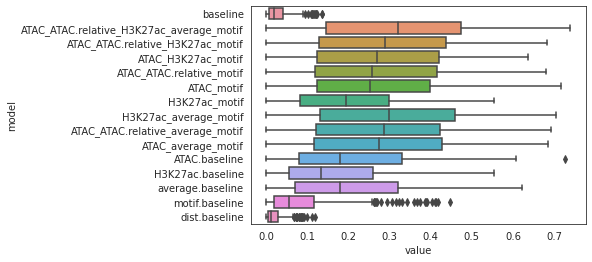

In [39]:

sns.boxplot(data=ct_benchmark_lr[ct_benchmark_lr["score"]=="pr_auc"], x="value", y="model")

# Second pass: training full models

Trained models are saved as pickles using joblib. Not sure if this is the most safe / optimal approach.

In [40]:
import joblib
factors = y_true.columns.str.replace("\..*", "").value_counts()
factors = factors.index


X_general = pd.DataFrame()

for factor in factors:
    if factor not in valid_factors or factor not in f2m:
        logger.debug(f"Skipping {factor}, not a TF or no motif known")
        continue
    print(factor)
    cols = y_true.columns[y_true.columns.str.contains(f"^{factor}\.")]
    cell_types = [col.split(".")[-1] for col in cols]
    cell_types = [ct for ct in cell_types if ct != "LNCaP"]
    #cell_types = [ct for ct in cell_types if ct != "MCF-7"]
    
    motif_frame = gimme[f2m[factor]].mean(1).to_frame("motif")
    X = X_base.join(motif_frame)
    
    tmp = pd.DataFrame()
    for ct in cell_types:         
        a = [tables[mark][[f"{ct}.{mark}"]].sub(meanref[mark], axis=0).apply(scale).rename(columns={f"{ct}.{mark}":f"{ct}.{mark}.relative"}) for mark in ["ATAC"]]
        b = [tables[mark][[f"{ct}.{mark}"]] for mark in marks] 

        ct_frame = pd.concat(a + b + [y_true[f"{factor}.{ct}"].rename("y_true")], axis=1)
        ct_frame.columns = ct_frame.columns.str.replace(f"{ct}.", "")
        ct_frame["cell_type"] = ct
        tmp = pd.concat([tmp, X.join(ct_frame)])
        #print(tmp.head())
    
    X = tmp
    if not "y_true" in X.columns:
        continue
    # Use all positive regions, and 100,000 randomly sampled negative regions
    X = pd.concat((X[X["y_true"] == 1], X[X["y_true"] == 0].sample(100000)))
    
    X_general = pd.concat((X_general, X.sample(5000))) # Use sample for general model
    y = X[["y_true"]]
    X = X.drop(columns=["y_true"])
    X = X.rename(columns={"remap.w50":"average"})
    
    for param_set in params:
        print(f"{factor}\tFitting model...")
        #print(X.head())
        model.fit(X[sorted(param_set)], y)
        dirname = os.path.join(out_dir, "_".join(sorted(param_set)))
        fname = os.path.join(dirname, f"{factor}.pkl"  )
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        joblib.dump(model, fname)

y = X_general[["y_true"]]
X = X_general.drop(columns=["y_true"])
X = X.rename(columns={"remap.w50":"average"})


# Make a general model, that is not TF specific
for param_set in params:
    print(f"Fitting general model...")
    #print(X.head())
    model.fit(X[sorted(param_set)], y)
    
    
    
    dirname = "_".join(sorted(param_set))
    fname = os.path.join(out_dir, dirname, "general.pkl"  )
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    joblib.dump(model, fname)
        

CTCF
CTCF	Fitting model...
CTCF	Fitting model...
CTCF	Fitting model...
CTCF	Fitting model...
CTCF	Fitting model...
CTCF	Fitting model...
CTCF	Fitting model...
CTCF	Fitting model...
CTCF	Fitting model...


2021-02-25 18:53:17.106 | DEBUG    | __main__:<module>:10 - Skipping EZH2, not a TF or no motif known
2021-02-25 18:53:17.107 | DEBUG    | __main__:<module>:10 - Skipping EP300, not a TF or no motif known


MYC
MYC	Fitting model...
MYC	Fitting model...
MYC	Fitting model...
MYC	Fitting model...
MYC	Fitting model...
MYC	Fitting model...
MYC	Fitting model...
MYC	Fitting model...
MYC	Fitting model...
CREB1
CREB1	Fitting model...
CREB1	Fitting model...
CREB1	Fitting model...
CREB1	Fitting model...
CREB1	Fitting model...
CREB1	Fitting model...
CREB1	Fitting model...
CREB1	Fitting model...
CREB1	Fitting model...
ZNF143
ZNF143	Fitting model...
ZNF143	Fitting model...
ZNF143	Fitting model...
ZNF143	Fitting model...
ZNF143	Fitting model...
ZNF143	Fitting model...
ZNF143	Fitting model...
ZNF143	Fitting model...
ZNF143	Fitting model...
NRF1
NRF1	Fitting model...
NRF1	Fitting model...
NRF1	Fitting model...
NRF1	Fitting model...
NRF1	Fitting model...
NRF1	Fitting model...
NRF1	Fitting model...
NRF1	Fitting model...
NRF1	Fitting model...
RFX5
RFX5	Fitting model...
RFX5	Fitting model...
RFX5	Fitting model...
RFX5	Fitting model...
RFX5	Fitting model...
RFX5	Fitting model...
RFX5	Fitting model...
RFX5	Fitt

2021-02-25 18:55:59.598 | DEBUG    | __main__:<module>:10 - Skipping TAF1, not a TF or no motif known
2021-02-25 18:55:59.602 | DEBUG    | __main__:<module>:10 - Skipping RAD21, not a TF or no motif known


TCF7L2
TCF7L2	Fitting model...
TCF7L2	Fitting model...
TCF7L2	Fitting model...
TCF7L2	Fitting model...
TCF7L2	Fitting model...
TCF7L2	Fitting model...
TCF7L2	Fitting model...
TCF7L2	Fitting model...
TCF7L2	Fitting model...
REST
REST	Fitting model...
REST	Fitting model...
REST	Fitting model...
REST	Fitting model...
REST	Fitting model...
REST	Fitting model...
REST	Fitting model...
REST	Fitting model...
REST	Fitting model...
FOS
FOS	Fitting model...
FOS	Fitting model...
FOS	Fitting model...
FOS	Fitting model...
FOS	Fitting model...
FOS	Fitting model...
FOS	Fitting model...
FOS	Fitting model...
FOS	Fitting model...
MAFK
MAFK	Fitting model...
MAFK	Fitting model...
MAFK	Fitting model...
MAFK	Fitting model...
MAFK	Fitting model...
MAFK	Fitting model...
MAFK	Fitting model...
MAFK	Fitting model...
MAFK	Fitting model...
JUND
JUND	Fitting model...
JUND	Fitting model...
JUND	Fitting model...
JUND	Fitting model...
JUND	Fitting model...
JUND	Fitting model...
JUND	Fitting model...
JUND	Fitting model.

2021-02-25 19:04:40.950 | DEBUG    | __main__:<module>:10 - Skipping HDAC2, not a TF or no motif known
2021-02-25 19:04:40.953 | DEBUG    | __main__:<module>:10 - Skipping BRCA1, not a TF or no motif known


ZNF24
ZNF24	Fitting model...
ZNF24	Fitting model...
ZNF24	Fitting model...
ZNF24	Fitting model...
ZNF24	Fitting model...
ZNF24	Fitting model...
ZNF24	Fitting model...
ZNF24	Fitting model...
ZNF24	Fitting model...
MAFF
MAFF	Fitting model...
MAFF	Fitting model...
MAFF	Fitting model...
MAFF	Fitting model...
MAFF	Fitting model...
MAFF	Fitting model...
MAFF	Fitting model...
MAFF	Fitting model...
MAFF	Fitting model...
TEAD4
TEAD4	Fitting model...
TEAD4	Fitting model...
TEAD4	Fitting model...
TEAD4	Fitting model...
TEAD4	Fitting model...
TEAD4	Fitting model...
TEAD4	Fitting model...
TEAD4	Fitting model...
TEAD4	Fitting model...
SP1
SP1	Fitting model...
SP1	Fitting model...
SP1	Fitting model...
SP1	Fitting model...
SP1	Fitting model...
SP1	Fitting model...
SP1	Fitting model...
SP1	Fitting model...
SP1	Fitting model...
ATF7
ATF7	Fitting model...
ATF7	Fitting model...
ATF7	Fitting model...
ATF7	Fitting model...
ATF7	Fitting model...
ATF7	Fitting model...
ATF7	Fitting model...
ATF7	Fitting model.

2021-02-25 19:06:51.572 | DEBUG    | __main__:<module>:10 - Skipping YBX1, not a TF or no motif known
2021-02-25 19:06:51.574 | DEBUG    | __main__:<module>:10 - Skipping CHD2, not a TF or no motif known
2021-02-25 19:06:51.575 | DEBUG    | __main__:<module>:10 - Skipping SIN3A, not a TF or no motif known


FOXK2
FOXK2	Fitting model...
FOXK2	Fitting model...
FOXK2	Fitting model...
FOXK2	Fitting model...
FOXK2	Fitting model...
FOXK2	Fitting model...
FOXK2	Fitting model...
FOXK2	Fitting model...
FOXK2	Fitting model...
ZBTB33
ZBTB33	Fitting model...
ZBTB33	Fitting model...
ZBTB33	Fitting model...
ZBTB33	Fitting model...
ZBTB33	Fitting model...
ZBTB33	Fitting model...
ZBTB33	Fitting model...
ZBTB33	Fitting model...
ZBTB33	Fitting model...
ETS1
ETS1	Fitting model...
ETS1	Fitting model...
ETS1	Fitting model...
ETS1	Fitting model...
ETS1	Fitting model...
ETS1	Fitting model...
ETS1	Fitting model...
ETS1	Fitting model...
ETS1	Fitting model...


2021-02-25 19:07:52.687 | DEBUG    | __main__:<module>:10 - Skipping TBP, not a TF or no motif known
2021-02-25 19:07:52.689 | DEBUG    | __main__:<module>:10 - Skipping ZBTB40, not a TF or no motif known


USF2
USF2	Fitting model...
USF2	Fitting model...
USF2	Fitting model...
USF2	Fitting model...
USF2	Fitting model...
USF2	Fitting model...
USF2	Fitting model...
USF2	Fitting model...
USF2	Fitting model...


2021-02-25 19:08:15.810 | DEBUG    | __main__:<module>:10 - Skipping ARID3A, not a TF or no motif known


CUX1
CUX1	Fitting model...
CUX1	Fitting model...
CUX1	Fitting model...
CUX1	Fitting model...
CUX1	Fitting model...
CUX1	Fitting model...
CUX1	Fitting model...
CUX1	Fitting model...
CUX1	Fitting model...


2021-02-25 19:08:35.939 | DEBUG    | __main__:<module>:10 - Skipping SMC3, not a TF or no motif known


NR3C1
NR3C1	Fitting model...
NR3C1	Fitting model...
NR3C1	Fitting model...
NR3C1	Fitting model...
NR3C1	Fitting model...
NR3C1	Fitting model...
NR3C1	Fitting model...
NR3C1	Fitting model...
NR3C1	Fitting model...
TCF12
TCF12	Fitting model...
TCF12	Fitting model...
TCF12	Fitting model...
TCF12	Fitting model...
TCF12	Fitting model...
TCF12	Fitting model...
TCF12	Fitting model...
TCF12	Fitting model...
TCF12	Fitting model...


2021-02-25 19:09:21.814 | DEBUG    | __main__:<module>:10 - Skipping ZFP36, not a TF or no motif known


SREBF1
SREBF1	Fitting model...
SREBF1	Fitting model...
SREBF1	Fitting model...
SREBF1	Fitting model...
SREBF1	Fitting model...
SREBF1	Fitting model...
SREBF1	Fitting model...
SREBF1	Fitting model...
SREBF1	Fitting model...
ZKSCAN1
ZKSCAN1	Fitting model...
ZKSCAN1	Fitting model...
ZKSCAN1	Fitting model...
ZKSCAN1	Fitting model...
ZKSCAN1	Fitting model...
ZKSCAN1	Fitting model...
ZKSCAN1	Fitting model...
ZKSCAN1	Fitting model...
ZKSCAN1	Fitting model...


2021-02-25 19:10:02.272 | DEBUG    | __main__:<module>:10 - Skipping TARDBP, not a TF or no motif known
2021-02-25 19:10:02.273 | DEBUG    | __main__:<module>:10 - Skipping TRIM22, not a TF or no motif known


YY1
YY1	Fitting model...
YY1	Fitting model...
YY1	Fitting model...
YY1	Fitting model...
YY1	Fitting model...
YY1	Fitting model...
YY1	Fitting model...
YY1	Fitting model...
YY1	Fitting model...
PKNOX1
PKNOX1	Fitting model...
PKNOX1	Fitting model...
PKNOX1	Fitting model...
PKNOX1	Fitting model...
PKNOX1	Fitting model...
PKNOX1	Fitting model...
PKNOX1	Fitting model...
PKNOX1	Fitting model...
PKNOX1	Fitting model...
NFIC
NFIC	Fitting model...
NFIC	Fitting model...
NFIC	Fitting model...
NFIC	Fitting model...
NFIC	Fitting model...
NFIC	Fitting model...
NFIC	Fitting model...
NFIC	Fitting model...
NFIC	Fitting model...
BHLHE40
BHLHE40	Fitting model...
BHLHE40	Fitting model...
BHLHE40	Fitting model...
BHLHE40	Fitting model...
BHLHE40	Fitting model...
BHLHE40	Fitting model...
BHLHE40	Fitting model...
BHLHE40	Fitting model...
BHLHE40	Fitting model...
NFYB
NFYB	Fitting model...
NFYB	Fitting model...
NFYB	Fitting model...
NFYB	Fitting model...
NFYB	Fitting model...
NFYB	Fitting model...
NFYB	Fittin

2021-02-25 19:14:39.869 | DEBUG    | __main__:<module>:10 - Skipping SMARCC2, not a TF or no motif known
2021-02-25 19:14:39.871 | DEBUG    | __main__:<module>:10 - Skipping TBL1XR1, not a TF or no motif known


STAT1
STAT1	Fitting model...
STAT1	Fitting model...
STAT1	Fitting model...
STAT1	Fitting model...
STAT1	Fitting model...
STAT1	Fitting model...
STAT1	Fitting model...
STAT1	Fitting model...
STAT1	Fitting model...
HSF1
HSF1	Fitting model...
HSF1	Fitting model...
HSF1	Fitting model...
HSF1	Fitting model...
HSF1	Fitting model...
HSF1	Fitting model...
HSF1	Fitting model...
HSF1	Fitting model...
HSF1	Fitting model...
RFX1
RFX1	Fitting model...
RFX1	Fitting model...
RFX1	Fitting model...
RFX1	Fitting model...
RFX1	Fitting model...
RFX1	Fitting model...
RFX1	Fitting model...
RFX1	Fitting model...
RFX1	Fitting model...
E2F4
E2F4	Fitting model...
E2F4	Fitting model...
E2F4	Fitting model...
E2F4	Fitting model...
E2F4	Fitting model...
E2F4	Fitting model...
E2F4	Fitting model...
E2F4	Fitting model...
E2F4	Fitting model...
SREBF2
SREBF2	Fitting model...
SREBF2	Fitting model...
SREBF2	Fitting model...
SREBF2	Fitting model...
SREBF2	Fitting model...
SREBF2	Fitting model...
SREBF2	Fitting model...
SRE

2021-02-25 19:18:05.632 | DEBUG    | __main__:<module>:10 - Skipping GATAD2B, not a TF or no motif known


TCF7
TCF7	Fitting model...
TCF7	Fitting model...
TCF7	Fitting model...
TCF7	Fitting model...
TCF7	Fitting model...
TCF7	Fitting model...
TCF7	Fitting model...
TCF7	Fitting model...
TCF7	Fitting model...
PAX8
PAX8	Fitting model...
PAX8	Fitting model...
PAX8	Fitting model...
PAX8	Fitting model...
PAX8	Fitting model...
PAX8	Fitting model...
PAX8	Fitting model...
PAX8	Fitting model...
PAX8	Fitting model...
IRF3
IRF3	Fitting model...
IRF3	Fitting model...
IRF3	Fitting model...
IRF3	Fitting model...
IRF3	Fitting model...
IRF3	Fitting model...
IRF3	Fitting model...
IRF3	Fitting model...
IRF3	Fitting model...
ZNF384
ZNF384	Fitting model...
ZNF384	Fitting model...
ZNF384	Fitting model...
ZNF384	Fitting model...
ZNF384	Fitting model...
ZNF384	Fitting model...
ZNF384	Fitting model...
ZNF384	Fitting model...
ZNF384	Fitting model...


2021-02-25 19:19:15.634 | DEBUG    | __main__:<module>:10 - Skipping SMARCA5, not a TF or no motif known


NR2F2
NR2F2	Fitting model...
NR2F2	Fitting model...
NR2F2	Fitting model...
NR2F2	Fitting model...
NR2F2	Fitting model...
NR2F2	Fitting model...
NR2F2	Fitting model...
NR2F2	Fitting model...
NR2F2	Fitting model...
E2F8
E2F8	Fitting model...
E2F8	Fitting model...
E2F8	Fitting model...
E2F8	Fitting model...
E2F8	Fitting model...
E2F8	Fitting model...
E2F8	Fitting model...
E2F8	Fitting model...
E2F8	Fitting model...
EGR1
EGR1	Fitting model...
EGR1	Fitting model...
EGR1	Fitting model...
EGR1	Fitting model...
EGR1	Fitting model...
EGR1	Fitting model...
EGR1	Fitting model...
EGR1	Fitting model...
EGR1	Fitting model...
IKZF1
IKZF1	Fitting model...
IKZF1	Fitting model...
IKZF1	Fitting model...
IKZF1	Fitting model...
IKZF1	Fitting model...
IKZF1	Fitting model...
IKZF1	Fitting model...
IKZF1	Fitting model...
IKZF1	Fitting model...
FOXM1
FOXM1	Fitting model...
FOXM1	Fitting model...
FOXM1	Fitting model...
FOXM1	Fitting model...
FOXM1	Fitting model...
FOXM1	Fitting model...
FOXM1	Fitting model...
F

2021-02-25 19:22:38.352 | DEBUG    | __main__:<module>:10 - Skipping SMARCB1, not a TF or no motif known
2021-02-25 19:22:38.353 | DEBUG    | __main__:<module>:10 - Skipping TSC22D4, not a TF or no motif known


CREM
CREM	Fitting model...
CREM	Fitting model...
CREM	Fitting model...
CREM	Fitting model...
CREM	Fitting model...
CREM	Fitting model...
CREM	Fitting model...
CREM	Fitting model...
CREM	Fitting model...


2021-02-25 19:23:05.476 | DEBUG    | __main__:<module>:10 - Skipping CEBPZ, not a TF or no motif known


FOSL2
FOSL2	Fitting model...
FOSL2	Fitting model...
FOSL2	Fitting model...
FOSL2	Fitting model...
FOSL2	Fitting model...
FOSL2	Fitting model...
FOSL2	Fitting model...
FOSL2	Fitting model...
FOSL2	Fitting model...
FOXP1
FOXP1	Fitting model...
FOXP1	Fitting model...
FOXP1	Fitting model...
FOXP1	Fitting model...
FOXP1	Fitting model...
FOXP1	Fitting model...
FOXP1	Fitting model...
FOXP1	Fitting model...
FOXP1	Fitting model...


2021-02-25 19:23:47.295 | DEBUG    | __main__:<module>:10 - Skipping GTF3C2, not a TF or no motif known


PBX2
PBX2	Fitting model...
PBX2	Fitting model...
PBX2	Fitting model...
PBX2	Fitting model...
PBX2	Fitting model...
PBX2	Fitting model...
PBX2	Fitting model...
PBX2	Fitting model...
PBX2	Fitting model...
POU5F1
POU5F1	Fitting model...
POU5F1	Fitting model...
POU5F1	Fitting model...
POU5F1	Fitting model...
POU5F1	Fitting model...
POU5F1	Fitting model...
POU5F1	Fitting model...
POU5F1	Fitting model...
POU5F1	Fitting model...
TP53
TP53	Fitting model...
TP53	Fitting model...
TP53	Fitting model...
TP53	Fitting model...
TP53	Fitting model...
TP53	Fitting model...
TP53	Fitting model...
TP53	Fitting model...
TP53	Fitting model...


2021-02-25 19:24:39.525 | DEBUG    | __main__:<module>:10 - Skipping ZBTB11, not a TF or no motif known


SMAD2
SMAD2	Fitting model...
SMAD2	Fitting model...
SMAD2	Fitting model...
SMAD2	Fitting model...
SMAD2	Fitting model...
SMAD2	Fitting model...
SMAD2	Fitting model...
SMAD2	Fitting model...
SMAD2	Fitting model...


2021-02-25 19:24:53.072 | DEBUG    | __main__:<module>:10 - Skipping GATAD2A, not a TF or no motif known


E2F6
E2F6	Fitting model...
E2F6	Fitting model...
E2F6	Fitting model...
E2F6	Fitting model...
E2F6	Fitting model...
E2F6	Fitting model...
E2F6	Fitting model...
E2F6	Fitting model...
E2F6	Fitting model...
TEAD1
TEAD1	Fitting model...
TEAD1	Fitting model...
TEAD1	Fitting model...
TEAD1	Fitting model...
TEAD1	Fitting model...
TEAD1	Fitting model...
TEAD1	Fitting model...
TEAD1	Fitting model...
TEAD1	Fitting model...
KLF10
KLF10	Fitting model...
KLF10	Fitting model...
KLF10	Fitting model...
KLF10	Fitting model...
KLF10	Fitting model...
KLF10	Fitting model...
KLF10	Fitting model...
KLF10	Fitting model...
KLF10	Fitting model...
SPI1
SPI1	Fitting model...
SPI1	Fitting model...
SPI1	Fitting model...
SPI1	Fitting model...
SPI1	Fitting model...
SPI1	Fitting model...
SPI1	Fitting model...
SPI1	Fitting model...
SPI1	Fitting model...


2021-02-25 19:26:20.095 | DEBUG    | __main__:<module>:10 - Skipping GABPB1, not a TF or no motif known
2021-02-25 19:26:20.096 | DEBUG    | __main__:<module>:10 - Skipping SMARCC1, not a TF or no motif known


ETV1
ETV1	Fitting model...
ETV1	Fitting model...
ETV1	Fitting model...
ETV1	Fitting model...
ETV1	Fitting model...
ETV1	Fitting model...
ETV1	Fitting model...
ETV1	Fitting model...
ETV1	Fitting model...
RXRA
RXRA	Fitting model...
RXRA	Fitting model...
RXRA	Fitting model...
RXRA	Fitting model...
RXRA	Fitting model...
RXRA	Fitting model...
RXRA	Fitting model...
RXRA	Fitting model...
RXRA	Fitting model...
ATF4
ATF4	Fitting model...
ATF4	Fitting model...
ATF4	Fitting model...
ATF4	Fitting model...
ATF4	Fitting model...
ATF4	Fitting model...
ATF4	Fitting model...
ATF4	Fitting model...
ATF4	Fitting model...
STAT3
STAT3	Fitting model...
STAT3	Fitting model...
STAT3	Fitting model...
STAT3	Fitting model...
STAT3	Fitting model...
STAT3	Fitting model...
STAT3	Fitting model...
STAT3	Fitting model...
STAT3	Fitting model...


2021-02-25 19:27:26.673 | DEBUG    | __main__:<module>:10 - Skipping BCLAF1, not a TF or no motif known


NR2F6
NR2F6	Fitting model...
NR2F6	Fitting model...
NR2F6	Fitting model...
NR2F6	Fitting model...
NR2F6	Fitting model...
NR2F6	Fitting model...
NR2F6	Fitting model...
NR2F6	Fitting model...
NR2F6	Fitting model...
RUNX1
RUNX1	Fitting model...
RUNX1	Fitting model...
RUNX1	Fitting model...
RUNX1	Fitting model...
RUNX1	Fitting model...
RUNX1	Fitting model...
RUNX1	Fitting model...
RUNX1	Fitting model...
RUNX1	Fitting model...
ZNF282
ZNF282	Fitting model...
ZNF282	Fitting model...
ZNF282	Fitting model...
ZNF282	Fitting model...
ZNF282	Fitting model...
ZNF282	Fitting model...
ZNF282	Fitting model...
ZNF282	Fitting model...
ZNF282	Fitting model...
GRHL2
GRHL2	Fitting model...
GRHL2	Fitting model...
GRHL2	Fitting model...
GRHL2	Fitting model...
GRHL2	Fitting model...
GRHL2	Fitting model...
GRHL2	Fitting model...
GRHL2	Fitting model...
GRHL2	Fitting model...
SP2
SP2	Fitting model...
SP2	Fitting model...
SP2	Fitting model...
SP2	Fitting model...
SP2	Fitting model...
SP2	Fitting model...
SP2	Fitt

2021-02-25 19:29:10.059 | DEBUG    | __main__:<module>:10 - Skipping ARID2, not a TF or no motif known
2021-02-25 19:29:10.061 | DEBUG    | __main__:<module>:10 - Skipping TLE3, not a TF or no motif known


KLF4
KLF4	Fitting model...
KLF4	Fitting model...
KLF4	Fitting model...
KLF4	Fitting model...
KLF4	Fitting model...
KLF4	Fitting model...
KLF4	Fitting model...
KLF4	Fitting model...
KLF4	Fitting model...
NFIA
NFIA	Fitting model...
NFIA	Fitting model...
NFIA	Fitting model...
NFIA	Fitting model...
NFIA	Fitting model...
NFIA	Fitting model...
NFIA	Fitting model...
NFIA	Fitting model...
NFIA	Fitting model...
ETV6
ETV6	Fitting model...
ETV6	Fitting model...
ETV6	Fitting model...
ETV6	Fitting model...
ETV6	Fitting model...
ETV6	Fitting model...
ETV6	Fitting model...
ETV6	Fitting model...
ETV6	Fitting model...
NR2C1
NR2C1	Fitting model...
NR2C1	Fitting model...
NR2C1	Fitting model...
NR2C1	Fitting model...
NR2C1	Fitting model...
NR2C1	Fitting model...
NR2C1	Fitting model...
NR2C1	Fitting model...
NR2C1	Fitting model...
CEBPD
CEBPD	Fitting model...
CEBPD	Fitting model...
CEBPD	Fitting model...
CEBPD	Fitting model...
CEBPD	Fitting model...
CEBPD	Fitting model...
CEBPD	Fitting model...
CEBPD	Fitti

2021-02-25 19:30:58.609 | DEBUG    | __main__:<module>:10 - Skipping MBD2, not a TF or no motif known


ZBED1
ZBED1	Fitting model...
ZBED1	Fitting model...
ZBED1	Fitting model...
ZBED1	Fitting model...
ZBED1	Fitting model...
ZBED1	Fitting model...
ZBED1	Fitting model...
ZBED1	Fitting model...
ZBED1	Fitting model...
STAT2
STAT2	Fitting model...
STAT2	Fitting model...
STAT2	Fitting model...
STAT2	Fitting model...
STAT2	Fitting model...
STAT2	Fitting model...
STAT2	Fitting model...
STAT2	Fitting model...
STAT2	Fitting model...


2021-02-25 19:31:30.874 | DEBUG    | __main__:<module>:10 - Skipping TAF15, not a TF or no motif known
2021-02-25 19:31:30.877 | DEBUG    | __main__:<module>:10 - Skipping CBX5, not a TF or no motif known


ATF1
ATF1	Fitting model...
ATF1	Fitting model...
ATF1	Fitting model...
ATF1	Fitting model...
ATF1	Fitting model...
ATF1	Fitting model...
ATF1	Fitting model...
ATF1	Fitting model...
ATF1	Fitting model...


2021-02-25 19:31:50.181 | DEBUG    | __main__:<module>:10 - Skipping PRPF4, not a TF or no motif known


SIX5
SIX5	Fitting model...
SIX5	Fitting model...
SIX5	Fitting model...
SIX5	Fitting model...
SIX5	Fitting model...
SIX5	Fitting model...
SIX5	Fitting model...
SIX5	Fitting model...
SIX5	Fitting model...


2021-02-25 19:32:05.215 | DEBUG    | __main__:<module>:10 - Skipping ARID1B, not a TF or no motif known


LEF1
LEF1	Fitting model...
LEF1	Fitting model...
LEF1	Fitting model...
LEF1	Fitting model...
LEF1	Fitting model...
LEF1	Fitting model...
LEF1	Fitting model...
LEF1	Fitting model...
LEF1	Fitting model...
NEUROD1
NEUROD1	Fitting model...
NEUROD1	Fitting model...
NEUROD1	Fitting model...
NEUROD1	Fitting model...
NEUROD1	Fitting model...
NEUROD1	Fitting model...
NEUROD1	Fitting model...
NEUROD1	Fitting model...
NEUROD1	Fitting model...
SOX6
SOX6	Fitting model...
SOX6	Fitting model...
SOX6	Fitting model...
SOX6	Fitting model...
SOX6	Fitting model...
SOX6	Fitting model...
SOX6	Fitting model...
SOX6	Fitting model...
SOX6	Fitting model...


2021-02-25 19:32:55.742 | DEBUG    | __main__:<module>:10 - Skipping CREBBP, not a TF or no motif known


ERG
ERG	Fitting model...
ERG	Fitting model...
ERG	Fitting model...
ERG	Fitting model...
ERG	Fitting model...
ERG	Fitting model...
ERG	Fitting model...
ERG	Fitting model...
ERG	Fitting model...
ZBTB7A
ZBTB7A	Fitting model...
ZBTB7A	Fitting model...
ZBTB7A	Fitting model...
ZBTB7A	Fitting model...
ZBTB7A	Fitting model...
ZBTB7A	Fitting model...
ZBTB7A	Fitting model...
ZBTB7A	Fitting model...
ZBTB7A	Fitting model...
SMAD1
SMAD1	Fitting model...
SMAD1	Fitting model...
SMAD1	Fitting model...
SMAD1	Fitting model...
SMAD1	Fitting model...
SMAD1	Fitting model...
SMAD1	Fitting model...
SMAD1	Fitting model...
SMAD1	Fitting model...
MEF2A
MEF2A	Fitting model...
MEF2A	Fitting model...
MEF2A	Fitting model...
MEF2A	Fitting model...
MEF2A	Fitting model...
MEF2A	Fitting model...
MEF2A	Fitting model...
MEF2A	Fitting model...
MEF2A	Fitting model...


2021-02-25 19:34:14.477 | DEBUG    | __main__:<module>:10 - Skipping BDP1, not a TF or no motif known


NFE2
NFE2	Fitting model...
NFE2	Fitting model...
NFE2	Fitting model...
NFE2	Fitting model...
NFE2	Fitting model...
NFE2	Fitting model...
NFE2	Fitting model...
NFE2	Fitting model...
NFE2	Fitting model...
ZEB1
ZEB1	Fitting model...
ZEB1	Fitting model...
ZEB1	Fitting model...
ZEB1	Fitting model...
ZEB1	Fitting model...
ZEB1	Fitting model...
ZEB1	Fitting model...
ZEB1	Fitting model...
ZEB1	Fitting model...
AR
AR	Fitting model...
AR	Fitting model...
AR	Fitting model...
AR	Fitting model...
AR	Fitting model...
AR	Fitting model...
AR	Fitting model...
AR	Fitting model...
AR	Fitting model...


2021-02-25 19:35:08.541 | DEBUG    | __main__:<module>:10 - Skipping BRF2, not a TF or no motif known


ZFX
ZFX	Fitting model...
ZFX	Fitting model...
ZFX	Fitting model...
ZFX	Fitting model...
ZFX	Fitting model...
ZFX	Fitting model...
ZFX	Fitting model...
ZFX	Fitting model...
ZFX	Fitting model...
FOXO3
FOXO3	Fitting model...
FOXO3	Fitting model...
FOXO3	Fitting model...
FOXO3	Fitting model...
FOXO3	Fitting model...
FOXO3	Fitting model...
FOXO3	Fitting model...
FOXO3	Fitting model...
FOXO3	Fitting model...
AHR
AHR	Fitting model...
AHR	Fitting model...
AHR	Fitting model...
AHR	Fitting model...
AHR	Fitting model...
AHR	Fitting model...
AHR	Fitting model...
AHR	Fitting model...
AHR	Fitting model...
STAT5A
STAT5A	Fitting model...
STAT5A	Fitting model...
STAT5A	Fitting model...
STAT5A	Fitting model...
STAT5A	Fitting model...
STAT5A	Fitting model...
STAT5A	Fitting model...
STAT5A	Fitting model...
STAT5A	Fitting model...
MYBL2
MYBL2	Fitting model...
MYBL2	Fitting model...
MYBL2	Fitting model...
MYBL2	Fitting model...
MYBL2	Fitting model...
MYBL2	Fitting model...
MYBL2	Fitting model...
MYBL2	Fitti

2021-02-25 19:36:49.150 | DEBUG    | __main__:<module>:10 - Skipping SMAD5, not a TF or no motif known


ZNF18
ZNF18	Fitting model...
ZNF18	Fitting model...
ZNF18	Fitting model...
ZNF18	Fitting model...
ZNF18	Fitting model...
ZNF18	Fitting model...
ZNF18	Fitting model...
ZNF18	Fitting model...
ZNF18	Fitting model...


2021-02-25 19:37:05.058 | DEBUG    | __main__:<module>:10 - Skipping ARID1A, not a TF or no motif known


SMAD4
SMAD4	Fitting model...
SMAD4	Fitting model...
SMAD4	Fitting model...
SMAD4	Fitting model...
SMAD4	Fitting model...
SMAD4	Fitting model...
SMAD4	Fitting model...
SMAD4	Fitting model...
SMAD4	Fitting model...


2021-02-25 19:37:27.728 | DEBUG    | __main__:<module>:10 - Skipping BRF1, not a TF or no motif known


IKZF2
IKZF2	Fitting model...
IKZF2	Fitting model...
IKZF2	Fitting model...
IKZF2	Fitting model...
IKZF2	Fitting model...
IKZF2	Fitting model...
IKZF2	Fitting model...
IKZF2	Fitting model...
IKZF2	Fitting model...
HBP1
HBP1	Fitting model...
HBP1	Fitting model...
HBP1	Fitting model...
HBP1	Fitting model...
HBP1	Fitting model...
HBP1	Fitting model...
HBP1	Fitting model...
HBP1	Fitting model...
HBP1	Fitting model...
TFE3
TFE3	Fitting model...
TFE3	Fitting model...
TFE3	Fitting model...
TFE3	Fitting model...
TFE3	Fitting model...
TFE3	Fitting model...
TFE3	Fitting model...
TFE3	Fitting model...
TFE3	Fitting model...
NFE2L1
NFE2L1	Fitting model...
NFE2L1	Fitting model...
NFE2L1	Fitting model...
NFE2L1	Fitting model...
NFE2L1	Fitting model...
NFE2L1	Fitting model...
NFE2L1	Fitting model...
NFE2L1	Fitting model...
NFE2L1	Fitting model...
ZNF263
ZNF263	Fitting model...
ZNF263	Fitting model...
ZNF263	Fitting model...
ZNF263	Fitting model...
ZNF263	Fitting model...
ZNF263	Fitting model...
ZNF263	

2021-02-25 19:40:21.129 | DEBUG    | __main__:<module>:10 - Skipping TAF7, not a TF or no motif known
2021-02-25 19:40:21.133 | DEBUG    | __main__:<module>:10 - Skipping PPARGC1A, not a TF or no motif known


TCF3
TCF3	Fitting model...
TCF3	Fitting model...
TCF3	Fitting model...
TCF3	Fitting model...
TCF3	Fitting model...
TCF3	Fitting model...
TCF3	Fitting model...
TCF3	Fitting model...
TCF3	Fitting model...
GATA1
GATA1	Fitting model...
GATA1	Fitting model...
GATA1	Fitting model...
GATA1	Fitting model...
GATA1	Fitting model...
GATA1	Fitting model...
GATA1	Fitting model...
GATA1	Fitting model...
GATA1	Fitting model...
TEAD2
TEAD2	Fitting model...
TEAD2	Fitting model...
TEAD2	Fitting model...
TEAD2	Fitting model...
TEAD2	Fitting model...
TEAD2	Fitting model...
TEAD2	Fitting model...
TEAD2	Fitting model...
TEAD2	Fitting model...
MLX
MLX	Fitting model...
MLX	Fitting model...
MLX	Fitting model...
MLX	Fitting model...
MLX	Fitting model...
MLX	Fitting model...
MLX	Fitting model...
MLX	Fitting model...
MLX	Fitting model...
PPARG
PPARG	Fitting model...
PPARG	Fitting model...
PPARG	Fitting model...
PPARG	Fitting model...
PPARG	Fitting model...
PPARG	Fitting model...
PPARG	Fitting model...
PPARG	Fitti

2021-02-25 19:45:32.482 | DEBUG    | __main__:<module>:10 - Skipping PGR_B, not a TF or no motif known


KLF13
KLF13	Fitting model...
KLF13	Fitting model...
KLF13	Fitting model...
KLF13	Fitting model...
KLF13	Fitting model...
KLF13	Fitting model...
KLF13	Fitting model...
KLF13	Fitting model...
KLF13	Fitting model...
MYB
MYB	Fitting model...
MYB	Fitting model...
MYB	Fitting model...
MYB	Fitting model...
MYB	Fitting model...
MYB	Fitting model...
MYB	Fitting model...
MYB	Fitting model...
MYB	Fitting model...
NFIB
NFIB	Fitting model...
NFIB	Fitting model...
NFIB	Fitting model...
NFIB	Fitting model...
NFIB	Fitting model...
NFIB	Fitting model...
NFIB	Fitting model...
NFIB	Fitting model...
NFIB	Fitting model...
GMEB1
GMEB1	Fitting model...
GMEB1	Fitting model...
GMEB1	Fitting model...
GMEB1	Fitting model...
GMEB1	Fitting model...
GMEB1	Fitting model...
GMEB1	Fitting model...
GMEB1	Fitting model...
GMEB1	Fitting model...
FOSL1
FOSL1	Fitting model...
FOSL1	Fitting model...
FOSL1	Fitting model...
FOSL1	Fitting model...
FOSL1	Fitting model...
FOSL1	Fitting model...
FOSL1	Fitting model...
FOSL1	Fitti

2021-02-25 19:46:45.369 | DEBUG    | __main__:<module>:10 - Skipping EWSR1, not a TF or no motif known
2021-02-25 19:46:45.372 | DEBUG    | __main__:<module>:10 - Skipping HMGN3, not a TF or no motif known


PDX1
PDX1	Fitting model...
PDX1	Fitting model...
PDX1	Fitting model...
PDX1	Fitting model...
PDX1	Fitting model...
PDX1	Fitting model...
PDX1	Fitting model...
PDX1	Fitting model...
PDX1	Fitting model...


2021-02-25 19:46:57.521 | DEBUG    | __main__:<module>:10 - Skipping ZNF83, not a TF or no motif known
2021-02-25 19:46:57.528 | DEBUG    | __main__:<module>:10 - Skipping WRNIP1, not a TF or no motif known


POU2F2
POU2F2	Fitting model...
POU2F2	Fitting model...
POU2F2	Fitting model...
POU2F2	Fitting model...
POU2F2	Fitting model...
POU2F2	Fitting model...
POU2F2	Fitting model...
POU2F2	Fitting model...
POU2F2	Fitting model...
ZNF652
ZNF652	Fitting model...
ZNF652	Fitting model...
ZNF652	Fitting model...
ZNF652	Fitting model...
ZNF652	Fitting model...
ZNF652	Fitting model...
ZNF652	Fitting model...
ZNF652	Fitting model...
ZNF652	Fitting model...
RBPJ
RBPJ	Fitting model...
RBPJ	Fitting model...
RBPJ	Fitting model...
RBPJ	Fitting model...
RBPJ	Fitting model...
RBPJ	Fitting model...
RBPJ	Fitting model...
RBPJ	Fitting model...
RBPJ	Fitting model...
FOXO1
FOXO1	Fitting model...
FOXO1	Fitting model...
FOXO1	Fitting model...
FOXO1	Fitting model...
FOXO1	Fitting model...
FOXO1	Fitting model...
FOXO1	Fitting model...
FOXO1	Fitting model...
FOXO1	Fitting model...
TEAD3
TEAD3	Fitting model...
TEAD3	Fitting model...
TEAD3	Fitting model...
TEAD3	Fitting model...
TEAD3	Fitting model...
TEAD3	Fitting mod

2021-02-25 19:51:07.743 | DEBUG    | __main__:<module>:10 - Skipping TOP1, not a TF or no motif known
2021-02-25 19:51:07.744 | DEBUG    | __main__:<module>:10 - Skipping PGR_A, not a TF or no motif known


THAP11
THAP11	Fitting model...
THAP11	Fitting model...
THAP11	Fitting model...
THAP11	Fitting model...
THAP11	Fitting model...
THAP11	Fitting model...
THAP11	Fitting model...
THAP11	Fitting model...
THAP11	Fitting model...
NR5A2
NR5A2	Fitting model...
NR5A2	Fitting model...
NR5A2	Fitting model...
NR5A2	Fitting model...
NR5A2	Fitting model...
NR5A2	Fitting model...
NR5A2	Fitting model...
NR5A2	Fitting model...
NR5A2	Fitting model...
RARA
RARA	Fitting model...
RARA	Fitting model...
RARA	Fitting model...
RARA	Fitting model...
RARA	Fitting model...
RARA	Fitting model...
RARA	Fitting model...
RARA	Fitting model...
RARA	Fitting model...
BATF3
BATF3	Fitting model...
BATF3	Fitting model...
BATF3	Fitting model...
BATF3	Fitting model...
BATF3	Fitting model...
BATF3	Fitting model...
BATF3	Fitting model...
BATF3	Fitting model...
BATF3	Fitting model...
SMAD3
SMAD3	Fitting model...
SMAD3	Fitting model...
SMAD3	Fitting model...
SMAD3	Fitting model...
SMAD3	Fitting model...
SMAD3	Fitting model...
SMAD

2021-02-25 19:53:45.545 | DEBUG    | __main__:<module>:10 - Skipping ARID4B, not a TF or no motif known


VDR


2021-02-25 19:53:46.148 | DEBUG    | __main__:<module>:10 - Skipping NFKBIZ, not a TF or no motif known


RUNX3
RUNX3	Fitting model...
RUNX3	Fitting model...
RUNX3	Fitting model...
RUNX3	Fitting model...
RUNX3	Fitting model...
RUNX3	Fitting model...
RUNX3	Fitting model...
RUNX3	Fitting model...
RUNX3	Fitting model...
CREB3L1
CREB3L1	Fitting model...
CREB3L1	Fitting model...
CREB3L1	Fitting model...
CREB3L1	Fitting model...
CREB3L1	Fitting model...
CREB3L1	Fitting model...
CREB3L1	Fitting model...
CREB3L1	Fitting model...
CREB3L1	Fitting model...


2021-02-25 19:54:19.909 | DEBUG    | __main__:<module>:10 - Skipping MBD1, not a TF or no motif known


SOX13
SOX13	Fitting model...
SOX13	Fitting model...
SOX13	Fitting model...
SOX13	Fitting model...
SOX13	Fitting model...
SOX13	Fitting model...
SOX13	Fitting model...
SOX13	Fitting model...
SOX13	Fitting model...
HLF
HLF	Fitting model...
HLF	Fitting model...
HLF	Fitting model...
HLF	Fitting model...
HLF	Fitting model...
HLF	Fitting model...
HLF	Fitting model...
HLF	Fitting model...
HLF	Fitting model...
CLOCK
CLOCK	Fitting model...
CLOCK	Fitting model...
CLOCK	Fitting model...
CLOCK	Fitting model...
CLOCK	Fitting model...
CLOCK	Fitting model...
CLOCK	Fitting model...
CLOCK	Fitting model...
CLOCK	Fitting model...
HNF4G
HNF4G	Fitting model...
HNF4G	Fitting model...
HNF4G	Fitting model...
HNF4G	Fitting model...
HNF4G	Fitting model...
HNF4G	Fitting model...
HNF4G	Fitting model...
HNF4G	Fitting model...
HNF4G	Fitting model...
FOXA3
FOXA3	Fitting model...
FOXA3	Fitting model...
FOXA3	Fitting model...
FOXA3	Fitting model...
FOXA3	Fitting model...
FOXA3	Fitting model...
FOXA3	Fitting model...
F

2021-02-25 19:56:12.831 | DEBUG    | __main__:<module>:10 - Skipping ARHGAP35, not a TF or no motif known


ELF3
ELF3	Fitting model...
ELF3	Fitting model...
ELF3	Fitting model...
ELF3	Fitting model...
ELF3	Fitting model...
ELF3	Fitting model...
ELF3	Fitting model...
ELF3	Fitting model...
ELF3	Fitting model...


2021-02-25 19:56:34.275 | DEBUG    | __main__:<module>:10 - Skipping TCF25, not a TF or no motif known
2021-02-25 19:56:34.287 | DEBUG    | __main__:<module>:10 - Skipping ZNF766, not a TF or no motif known


VEZF1
VEZF1	Fitting model...
VEZF1	Fitting model...
VEZF1	Fitting model...
VEZF1	Fitting model...
VEZF1	Fitting model...
VEZF1	Fitting model...
VEZF1	Fitting model...
VEZF1	Fitting model...
VEZF1	Fitting model...


2021-02-25 19:56:50.104 | DEBUG    | __main__:<module>:10 - Skipping TRIM24, not a TF or no motif known
2021-02-25 19:56:50.109 | DEBUG    | __main__:<module>:10 - Skipping CCNT2, not a TF or no motif known


NANOG
NANOG	Fitting model...
NANOG	Fitting model...
NANOG	Fitting model...
NANOG	Fitting model...
NANOG	Fitting model...
NANOG	Fitting model...
NANOG	Fitting model...
NANOG	Fitting model...
NANOG	Fitting model...
TGIF2
TGIF2	Fitting model...
TGIF2	Fitting model...
TGIF2	Fitting model...
TGIF2	Fitting model...
TGIF2	Fitting model...
TGIF2	Fitting model...
TGIF2	Fitting model...
TGIF2	Fitting model...
TGIF2	Fitting model...
ZNF75A
ZNF75A	Fitting model...
ZNF75A	Fitting model...
ZNF75A	Fitting model...
ZNF75A	Fitting model...
ZNF75A	Fitting model...
ZNF75A	Fitting model...
ZNF75A	Fitting model...
ZNF75A	Fitting model...
ZNF75A	Fitting model...


2021-02-25 19:57:31.797 | DEBUG    | __main__:<module>:10 - Skipping ZNF354B, not a TF or no motif known
2021-02-25 19:57:31.804 | DEBUG    | __main__:<module>:10 - Skipping THRAP3, not a TF or no motif known


KLF5
KLF5	Fitting model...
KLF5	Fitting model...
KLF5	Fitting model...
KLF5	Fitting model...
KLF5	Fitting model...
KLF5	Fitting model...
KLF5	Fitting model...
KLF5	Fitting model...
KLF5	Fitting model...


2021-02-25 19:57:45.695 | DEBUG    | __main__:<module>:10 - Skipping LCORL, not a TF or no motif known
2021-02-25 19:57:45.697 | DEBUG    | __main__:<module>:10 - Skipping HMBOX1, not a TF or no motif known
2021-02-25 19:57:45.698 | DEBUG    | __main__:<module>:10 - Skipping CBFB, not a TF or no motif known


ZNF148
ZNF148	Fitting model...
ZNF148	Fitting model...
ZNF148	Fitting model...
ZNF148	Fitting model...
ZNF148	Fitting model...
ZNF148	Fitting model...
ZNF148	Fitting model...
ZNF148	Fitting model...
ZNF148	Fitting model...
THAP1
THAP1	Fitting model...
THAP1	Fitting model...
THAP1	Fitting model...
THAP1	Fitting model...
THAP1	Fitting model...
THAP1	Fitting model...
THAP1	Fitting model...
THAP1	Fitting model...
THAP1	Fitting model...


2021-02-25 19:58:14.454 | DEBUG    | __main__:<module>:10 - Skipping PHF21A, not a TF or no motif known
2021-02-25 19:58:14.459 | DEBUG    | __main__:<module>:10 - Skipping ID3, not a TF or no motif known


ZNF8
ZNF8	Fitting model...
ZNF8	Fitting model...
ZNF8	Fitting model...
ZNF8	Fitting model...
ZNF8	Fitting model...
ZNF8	Fitting model...
ZNF8	Fitting model...
ZNF8	Fitting model...
ZNF8	Fitting model...


2021-02-25 19:58:28.039 | DEBUG    | __main__:<module>:10 - Skipping GATAD1, not a TF or no motif known


NFYC
NFYC	Fitting model...
NFYC	Fitting model...
NFYC	Fitting model...
NFYC	Fitting model...
NFYC	Fitting model...
NFYC	Fitting model...
NFYC	Fitting model...
NFYC	Fitting model...
NFYC	Fitting model...
EOMES
EOMES	Fitting model...
EOMES	Fitting model...
EOMES	Fitting model...
EOMES	Fitting model...
EOMES	Fitting model...
EOMES	Fitting model...
EOMES	Fitting model...
EOMES	Fitting model...
EOMES	Fitting model...
MAFG
MAFG	Fitting model...
MAFG	Fitting model...
MAFG	Fitting model...
MAFG	Fitting model...
MAFG	Fitting model...
MAFG	Fitting model...
MAFG	Fitting model...
MAFG	Fitting model...
MAFG	Fitting model...
GATA4
GATA4	Fitting model...
GATA4	Fitting model...
GATA4	Fitting model...
GATA4	Fitting model...
GATA4	Fitting model...
GATA4	Fitting model...
GATA4	Fitting model...
GATA4	Fitting model...
GATA4	Fitting model...


2021-02-25 19:59:32.784 | DEBUG    | __main__:<module>:10 - Skipping MBD1_ISOF1, not a TF or no motif known
2021-02-25 19:59:32.785 | DEBUG    | __main__:<module>:10 - Skipping SETDB1, not a TF or no motif known
2021-02-25 19:59:32.786 | DEBUG    | __main__:<module>:10 - Skipping ZNF830, not a TF or no motif known


ELK4
ELK4	Fitting model...
ELK4	Fitting model...
ELK4	Fitting model...
ELK4	Fitting model...
ELK4	Fitting model...
ELK4	Fitting model...
ELK4	Fitting model...
ELK4	Fitting model...
ELK4	Fitting model...
TBX3
TBX3	Fitting model...
TBX3	Fitting model...
TBX3	Fitting model...
TBX3	Fitting model...
TBX3	Fitting model...
TBX3	Fitting model...
TBX3	Fitting model...
TBX3	Fitting model...
TBX3	Fitting model...
MGA
MGA	Fitting model...
MGA	Fitting model...
MGA	Fitting model...
MGA	Fitting model...
MGA	Fitting model...
MGA	Fitting model...
MGA	Fitting model...
MGA	Fitting model...
MGA	Fitting model...
CTCFL
CTCFL	Fitting model...
CTCFL	Fitting model...
CTCFL	Fitting model...
CTCFL	Fitting model...
CTCFL	Fitting model...
CTCFL	Fitting model...
CTCFL	Fitting model...
CTCFL	Fitting model...
CTCFL	Fitting model...
ZBTB16
ZBTB16	Fitting model...
ZBTB16	Fitting model...
ZBTB16	Fitting model...
ZBTB16	Fitting model...
ZBTB16	Fitting model...
ZBTB16	Fitting model...
ZBTB16	Fitting model...
ZBTB16	Fittin

2021-02-25 20:01:14.075 | DEBUG    | __main__:<module>:10 - Skipping BCL3, not a TF or no motif known
2021-02-25 20:01:14.079 | DEBUG    | __main__:<module>:10 - Skipping TRIP13, not a TF or no motif known


HINFP
HINFP	Fitting model...
HINFP	Fitting model...
HINFP	Fitting model...
HINFP	Fitting model...
HINFP	Fitting model...
HINFP	Fitting model...
HINFP	Fitting model...
HINFP	Fitting model...
HINFP	Fitting model...
ETV5
ETV5	Fitting model...
ETV5	Fitting model...
ETV5	Fitting model...
ETV5	Fitting model...
ETV5	Fitting model...
ETV5	Fitting model...
ETV5	Fitting model...
ETV5	Fitting model...
ETV5	Fitting model...
KLF9
KLF9	Fitting model...
KLF9	Fitting model...
KLF9	Fitting model...
KLF9	Fitting model...
KLF9	Fitting model...
KLF9	Fitting model...
KLF9	Fitting model...
KLF9	Fitting model...
KLF9	Fitting model...
BCL11A
BCL11A	Fitting model...
BCL11A	Fitting model...
BCL11A	Fitting model...
BCL11A	Fitting model...
BCL11A	Fitting model...
BCL11A	Fitting model...
BCL11A	Fitting model...
BCL11A	Fitting model...
BCL11A	Fitting model...
MEF2D
MEF2D	Fitting model...
MEF2D	Fitting model...
MEF2D	Fitting model...
MEF2D	Fitting model...
MEF2D	Fitting model...
MEF2D	Fitting model...
MEF2D	Fitting 

2021-02-25 20:02:43.471 | DEBUG    | __main__:<module>:10 - Skipping SIRT6, not a TF or no motif known


MITF
MITF	Fitting model...
MITF	Fitting model...
MITF	Fitting model...
MITF	Fitting model...
MITF	Fitting model...
MITF	Fitting model...
MITF	Fitting model...
MITF	Fitting model...
MITF	Fitting model...
IRF2
IRF2	Fitting model...
IRF2	Fitting model...
IRF2	Fitting model...
IRF2	Fitting model...
IRF2	Fitting model...
IRF2	Fitting model...
IRF2	Fitting model...
IRF2	Fitting model...
IRF2	Fitting model...
ETV4
ETV4	Fitting model...
ETV4	Fitting model...
ETV4	Fitting model...
ETV4	Fitting model...
ETV4	Fitting model...
ETV4	Fitting model...
ETV4	Fitting model...
ETV4	Fitting model...
ETV4	Fitting model...
SOX2
SOX2	Fitting model...
SOX2	Fitting model...
SOX2	Fitting model...
SOX2	Fitting model...
SOX2	Fitting model...
SOX2	Fitting model...
SOX2	Fitting model...
SOX2	Fitting model...
SOX2	Fitting model...
SP5
SP5	Fitting model...
SP5	Fitting model...
SP5	Fitting model...
SP5	Fitting model...
SP5	Fitting model...
SP5	Fitting model...
SP5	Fitting model...
SP5	Fitting model...
SP5	Fitting mode

2021-02-25 20:03:56.970 | DEBUG    | __main__:<module>:10 - Skipping ZNF184, not a TF or no motif known


HNF1A
HNF1A	Fitting model...
HNF1A	Fitting model...
HNF1A	Fitting model...
HNF1A	Fitting model...
HNF1A	Fitting model...
HNF1A	Fitting model...
HNF1A	Fitting model...
HNF1A	Fitting model...
HNF1A	Fitting model...
TP73
TP73	Fitting model...
TP73	Fitting model...
TP73	Fitting model...
TP73	Fitting model...
TP73	Fitting model...
TP73	Fitting model...
TP73	Fitting model...
TP73	Fitting model...
TP73	Fitting model...
NFIL3
NFIL3	Fitting model...
NFIL3	Fitting model...
NFIL3	Fitting model...
NFIL3	Fitting model...
NFIL3	Fitting model...
NFIL3	Fitting model...
NFIL3	Fitting model...
NFIL3	Fitting model...
NFIL3	Fitting model...
HNF4A
HNF4A	Fitting model...
HNF4A	Fitting model...
HNF4A	Fitting model...
HNF4A	Fitting model...
HNF4A	Fitting model...
HNF4A	Fitting model...
HNF4A	Fitting model...
HNF4A	Fitting model...
HNF4A	Fitting model...


2021-02-25 20:05:00.488 | DEBUG    | __main__:<module>:10 - Skipping ZNF410, not a TF or no motif known
2021-02-25 20:05:00.490 | DEBUG    | __main__:<module>:10 - Skipping TRIM28, not a TF or no motif known


MEF2B
MEF2B	Fitting model...
MEF2B	Fitting model...
MEF2B	Fitting model...
MEF2B	Fitting model...
MEF2B	Fitting model...
MEF2B	Fitting model...
MEF2B	Fitting model...
MEF2B	Fitting model...
MEF2B	Fitting model...
BCL6
BCL6	Fitting model...
BCL6	Fitting model...
BCL6	Fitting model...
BCL6	Fitting model...
BCL6	Fitting model...
BCL6	Fitting model...
BCL6	Fitting model...
BCL6	Fitting model...
BCL6	Fitting model...
PRDM14
PRDM14	Fitting model...
PRDM14	Fitting model...
PRDM14	Fitting model...
PRDM14	Fitting model...
PRDM14	Fitting model...
PRDM14	Fitting model...
PRDM14	Fitting model...
PRDM14	Fitting model...
PRDM14	Fitting model...


2021-02-25 20:05:49.303 | DEBUG    | __main__:<module>:10 - Skipping TAF2, not a TF or no motif known


E2F7
E2F7	Fitting model...
E2F7	Fitting model...
E2F7	Fitting model...
E2F7	Fitting model...
E2F7	Fitting model...
E2F7	Fitting model...
E2F7	Fitting model...
E2F7	Fitting model...
E2F7	Fitting model...


2021-02-25 20:06:02.519 | DEBUG    | __main__:<module>:10 - Skipping TRPS1, not a TF or no motif known


TAL1
TAL1	Fitting model...
TAL1	Fitting model...
TAL1	Fitting model...
TAL1	Fitting model...
TAL1	Fitting model...
TAL1	Fitting model...
TAL1	Fitting model...
TAL1	Fitting model...
TAL1	Fitting model...
NR4A1
NR4A1	Fitting model...
NR4A1	Fitting model...
NR4A1	Fitting model...
NR4A1	Fitting model...
NR4A1	Fitting model...
NR4A1	Fitting model...
NR4A1	Fitting model...
NR4A1	Fitting model...
NR4A1	Fitting model...
IRF9
IRF9	Fitting model...
IRF9	Fitting model...
IRF9	Fitting model...
IRF9	Fitting model...
IRF9	Fitting model...
IRF9	Fitting model...
IRF9	Fitting model...
IRF9	Fitting model...
IRF9	Fitting model...
RFX3
RFX3	Fitting model...
RFX3	Fitting model...
RFX3	Fitting model...
RFX3	Fitting model...
RFX3	Fitting model...
RFX3	Fitting model...
RFX3	Fitting model...
RFX3	Fitting model...
RFX3	Fitting model...


2021-02-25 20:07:01.543 | DEBUG    | __main__:<module>:10 - Skipping GTF2A2, not a TF or no motif known


PAX5
PAX5	Fitting model...
PAX5	Fitting model...
PAX5	Fitting model...
PAX5	Fitting model...
PAX5	Fitting model...
PAX5	Fitting model...
PAX5	Fitting model...
PAX5	Fitting model...
PAX5	Fitting model...
MEF2C
MEF2C	Fitting model...
MEF2C	Fitting model...
MEF2C	Fitting model...
MEF2C	Fitting model...
MEF2C	Fitting model...
MEF2C	Fitting model...
MEF2C	Fitting model...
MEF2C	Fitting model...
MEF2C	Fitting model...


2021-02-25 20:07:36.487 | DEBUG    | __main__:<module>:10 - Skipping TAF9B, not a TF or no motif known


GATA3
GATA3	Fitting model...
GATA3	Fitting model...
GATA3	Fitting model...
GATA3	Fitting model...
GATA3	Fitting model...
GATA3	Fitting model...
GATA3	Fitting model...
GATA3	Fitting model...
GATA3	Fitting model...


2021-02-25 20:07:58.315 | DEBUG    | __main__:<module>:10 - Skipping PRDM10, not a TF or no motif known


ZBTB7B
ZBTB7B	Fitting model...
ZBTB7B	Fitting model...
ZBTB7B	Fitting model...
ZBTB7B	Fitting model...
ZBTB7B	Fitting model...
ZBTB7B	Fitting model...
ZBTB7B	Fitting model...
ZBTB7B	Fitting model...
ZBTB7B	Fitting model...
CREB3
CREB3	Fitting model...
CREB3	Fitting model...
CREB3	Fitting model...
CREB3	Fitting model...
CREB3	Fitting model...
CREB3	Fitting model...
CREB3	Fitting model...
CREB3	Fitting model...
CREB3	Fitting model...
Fitting general model...
Fitting general model...
Fitting general model...
Fitting general model...
Fitting general model...
Fitting general model...
Fitting general model...
Fitting general model...
Fitting general model...


# Third part: benchmarking the trained general model

In [41]:
factors = y_true.columns.str.replace("\..*", "").value_counts()
factors = factors[factors > 1].index

test_idx = y_true.index[y_true.index.str.contains(test_chrom_regex)]
train_idx = y_true.index[~y_true.index.str.contains(test_chrom_regex)]

marks = list(tables.keys())
meanref = {mark:tables[mark].mean(1) for mark in marks}
common_f = [f for f in factors if f in valid_factors]
for factor in common_f:
    
    if factor not in valid_factors or factor not in f2m:
        logger.debug(f"Skipping {factor}, not a TF or no motif known")
        continue
#     if factor in set([x[0] for x in ct_benchmark]):
#         logger.debug(f"Skipping {factor}, already done")
#         continue
    logger.info(f"Model benchmark: {factor}")
    
    cols = y_true.columns[y_true.columns.str.contains(f"^{factor}\.")]
    cell_types = [col.split(".")[-1] for col in cols]
    
    cell_types = [ct for ct in cell_types if ct != "LNCaP"]
    print(cell_types)
    if len(cell_types) == 1:
        # Can't check in other cell-types
        continue
    motif_frame = gimme[f2m[factor]].mean(1).to_frame("motif")
    X = X_base.join(motif_frame)
    
    tmp = pd.DataFrame()
    for ct in cell_types:
        a = [tables[mark][[f"{ct}.{mark}"]] for mark in marks] 
        b = [tables[mark][[f"{ct}.{mark}"]].sub(meanref[mark], axis=0).rename(columns={f"{ct}.{mark}":f"{ct}.{mark}.relative"}) for mark in ["ATAC"]]
        ct_frame = pd.concat(a + b + [y_true[f"{factor}.{ct}"].rename("y_true")], axis=1)
        ct_frame.columns = ct_frame.columns.str.replace(f"{ct}.", "")
        ct_frame["cell_type"] = ct
        tmp = pd.concat([tmp, X.join(ct_frame)])
    
    X = tmp
    for test_cell in cell_types:
        test = X.loc[test_idx]
        X_test = test[test["cell_type"] == test_cell].drop(columns=["cell_type"])
        y_test = X_test[["y_true"]]
        
        if y_test.sum()[0] < 50:
            print("skipping, not enough peaks")
            continue
        
        X_test = X_test.drop(columns=["y_true"])
        
        for param_set in params:
            param_columns = sorted(param_set)
            model_name = "_".join(param_columns)
            
            dirname = "_".join(sorted(param_set))
            fname = os.path.join(out_dir, dirname, "general.pkl"  )
            model = joblib.load(fname)
            
            y_pred = model.predict_proba(X_test[param_columns])[:,1]
            for name, func in scores.items():
                score = func(y_test, y_pred)
                ct_benchmark.append([factor, test_cell, f"{model_name}.general", name, score])
                print(f"{factor}\t{test_cell}\t{model_name}.general\t{name}\t{score:.3f}")
    ct_benchmark_lr = pd.DataFrame(ct_benchmark, columns=["factor", "test_cell_type", "model", "score", "value"])
    ct_benchmark_lr.to_csv(f"{out_dir}/benchmark.with_general.txt", sep="\t")

2021-02-25 20:09:50.100 | INFO     | __main__:<module>:18 - Model benchmark: CTCF


['GM12878', 'K-562', 'HeLa-S3', 'MCF-7', 'hESC', 'Hep-G2']
CTCF	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.297
CTCF	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.834
CTCF	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.199
CTCF	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.799
CTCF	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.179
CTCF	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.781
CTCF	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.334
CTCF	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.823
CTCF	GM12878	ATAC_motif.general	pr_auc	0.281
CTCF	GM12878	ATAC_motif.general	roc_auc	0.799
CTCF	GM12878	H3K27ac_motif.general	pr_auc	0.130
CTCF	GM12878	H3K27ac_motif.general	roc_auc	0.711
CTCF	GM12878	H3K27ac_average_motif.general	pr_auc	0.300
CTCF	GM12878	H3K27ac_average_motif.general	roc_auc	0.827
CTCF	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.440
CTCF	GM12878	ATAC_ATAC.relative_average_motif.general	roc_auc

2021-02-25 20:10:20.585 | INFO     | __main__:<module>:18 - Model benchmark: MYC


CTCF	Hep-G2	ATAC_average_motif.general	roc_auc	0.891
['K-562', 'GM12878', 'Hep-G2', 'MCF-7', 'hESC', 'HeLa-S3']
MYC	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.723
MYC	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.954
MYC	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.646
MYC	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.935
MYC	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.624
MYC	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.929
MYC	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.581
MYC	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.877
MYC	K-562	ATAC_motif.general	pr_auc	0.544
MYC	K-562	ATAC_motif.general	roc_auc	0.864
MYC	K-562	H3K27ac_motif.general	pr_auc	0.471
MYC	K-562	H3K27ac_motif.general	roc_auc	0.901
MYC	K-562	H3K27ac_average_motif.general	pr_auc	0.692
MYC	K-562	H3K27ac_average_motif.general	roc_auc	0.950
MYC	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.613
MYC	K-562	ATAC_ATAC.relative_average_motif.general	ro

2021-02-25 20:10:51.641 | INFO     | __main__:<module>:18 - Model benchmark: CREB1


MYC	HeLa-S3	ATAC_average_motif.general	pr_auc	0.545
MYC	HeLa-S3	ATAC_average_motif.general	roc_auc	0.946
['GM12878', 'K-562', 'MCF-7', 'Hep-G2']
CREB1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.563
CREB1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.953
CREB1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.530
CREB1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.950
CREB1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.525
CREB1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.951
CREB1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.549
CREB1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.930
CREB1	GM12878	ATAC_motif.general	pr_auc	0.570
CREB1	GM12878	ATAC_motif.general	roc_auc	0.932
CREB1	GM12878	H3K27ac_motif.general	pr_auc	0.334
CREB1	GM12878	H3K27ac_motif.general	roc_auc	0.913
CREB1	GM12878	H3K27ac_average_motif.general	pr_auc	0.495
CREB1	GM12878	H3K27ac_average_motif.general	roc_auc	0.932
CREB1	GM12878	ATAC_ATAC.rela

2021-02-25 20:11:10.689 | INFO     | __main__:<module>:18 - Model benchmark: ZNF143


CREB1	Hep-G2	ATAC_average_motif.general	pr_auc	0.609
CREB1	Hep-G2	ATAC_average_motif.general	roc_auc	0.874
['Hep-G2', 'MCF-7', 'K-562', 'HeLa-S3', 'GM12878']
ZNF143	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.420
ZNF143	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.921
ZNF143	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.271
ZNF143	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.862
ZNF143	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.238
ZNF143	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.844
ZNF143	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.418
ZNF143	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.899
ZNF143	Hep-G2	ATAC_motif.general	pr_auc	0.362
ZNF143	Hep-G2	ATAC_motif.general	roc_auc	0.881
ZNF143	Hep-G2	H3K27ac_motif.general	pr_auc	0.119
ZNF143	Hep-G2	H3K27ac_motif.general	roc_auc	0.686
ZNF143	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.400
ZNF143	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.907
ZNF143	Hep-G2	A

2021-02-25 20:11:34.575 | INFO     | __main__:<module>:18 - Model benchmark: NRF1


['MCF-7', 'GM12878', 'HeLa-S3', 'K-562', 'Hep-G2']
NRF1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.292
NRF1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.965
NRF1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.294
NRF1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.960
NRF1	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.241
NRF1	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.958
NRF1	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.382
NRF1	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.933
NRF1	MCF-7	ATAC_motif.general	pr_auc	0.325
NRF1	MCF-7	ATAC_motif.general	roc_auc	0.933
NRF1	MCF-7	H3K27ac_motif.general	pr_auc	0.128
NRF1	MCF-7	H3K27ac_motif.general	roc_auc	0.937
NRF1	MCF-7	H3K27ac_average_motif.general	pr_auc	0.274
NRF1	MCF-7	H3K27ac_average_motif.general	roc_auc	0.961
NRF1	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.259
NRF1	MCF-7	ATAC_ATAC.relative_average_motif.general	roc_auc	0.947
NRF1	MCF-7	ATAC_average_motif.gen

2021-02-25 20:11:58.995 | INFO     | __main__:<module>:18 - Model benchmark: RFX5


['GM12878', 'K-562', 'HeLa-S3', 'MCF-7', 'Hep-G2']
RFX5	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.032
RFX5	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.960
RFX5	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.078
RFX5	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.961
RFX5	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.051
RFX5	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.957
RFX5	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.080
RFX5	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.968
RFX5	GM12878	ATAC_motif.general	pr_auc	0.059
RFX5	GM12878	ATAC_motif.general	roc_auc	0.964
RFX5	GM12878	H3K27ac_motif.general	pr_auc	0.018
RFX5	GM12878	H3K27ac_motif.general	roc_auc	0.930
RFX5	GM12878	H3K27ac_average_motif.general	pr_auc	0.026
RFX5	GM12878	H3K27ac_average_motif.general	roc_auc	0.949
RFX5	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.026
RFX5	GM12878	ATAC_ATAC.relative_average_motif.general	roc_auc	0.964
R

2021-02-25 20:12:23.830 | INFO     | __main__:<module>:18 - Model benchmark: TCF7L2


RFX5	Hep-G2	ATAC_average_motif.general	pr_auc	0.344
RFX5	Hep-G2	ATAC_average_motif.general	roc_auc	0.931
['MCF-7', 'HeLa-S3', 'Hep-G2', 'K-562']
TCF7L2	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.094
TCF7L2	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.914
TCF7L2	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.088
TCF7L2	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.895
TCF7L2	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.099
TCF7L2	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.897
TCF7L2	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.060
TCF7L2	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.862
TCF7L2	MCF-7	ATAC_motif.general	pr_auc	0.075
TCF7L2	MCF-7	ATAC_motif.general	roc_auc	0.868
TCF7L2	MCF-7	H3K27ac_motif.general	pr_auc	0.091
TCF7L2	MCF-7	H3K27ac_motif.general	roc_auc	0.876
TCF7L2	MCF-7	H3K27ac_average_motif.general	pr_auc	0.093
TCF7L2	MCF-7	H3K27ac_average_motif.general	roc_auc	0.908
TCF7L2	MCF-7	ATAC_ATAC.relative_average_mo

2021-02-25 20:12:42.219 | INFO     | __main__:<module>:18 - Model benchmark: REST


TCF7L2	K-562	ATAC_average_motif.general	pr_auc	0.206
TCF7L2	K-562	ATAC_average_motif.general	roc_auc	0.924
['GM12878', 'K-562', 'MCF-7', 'HeLa-S3', 'Hep-G2']
REST	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.334
REST	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.868
REST	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.250
REST	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.863
REST	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.221
REST	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.856
REST	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.267
REST	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.862
REST	GM12878	ATAC_motif.general	pr_auc	0.229
REST	GM12878	ATAC_motif.general	roc_auc	0.850
REST	GM12878	H3K27ac_motif.general	pr_auc	0.130
REST	GM12878	H3K27ac_motif.general	roc_auc	0.834
REST	GM12878	H3K27ac_average_motif.general	pr_auc	0.316
REST	GM12878	H3K27ac_average_motif.general	roc_auc	0.863
REST	GM12878	ATAC_ATAC.relati

2021-02-25 20:13:05.485 | INFO     | __main__:<module>:18 - Model benchmark: FOS


REST	Hep-G2	ATAC_average_motif.general	pr_auc	0.325
REST	Hep-G2	ATAC_average_motif.general	roc_auc	0.903
['MCF-7', 'HeLa-S3', 'GM12878', 'Hep-G2', 'K-562']
FOS	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.234
FOS	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.834
FOS	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.215
FOS	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.815
FOS	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.219
FOS	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.810
FOS	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.176
FOS	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.775
FOS	MCF-7	ATAC_motif.general	pr_auc	0.182
FOS	MCF-7	ATAC_motif.general	roc_auc	0.765
FOS	MCF-7	H3K27ac_motif.general	pr_auc	0.241
FOS	MCF-7	H3K27ac_motif.general	roc_auc	0.828
FOS	MCF-7	H3K27ac_average_motif.general	pr_auc	0.253
FOS	MCF-7	H3K27ac_average_motif.general	roc_auc	0.848
FOS	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.196
FOS	MCF-7

2021-02-25 20:13:26.640 | INFO     | __main__:<module>:18 - Model benchmark: MAFK


FOS	K-562	ATAC_average_motif.general	roc_auc	0.859
['MCF-7', 'GM12878', 'Hep-G2', 'HeLa-S3', 'K-562']
MAFK	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.027
MAFK	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.755
MAFK	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.026
MAFK	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.726
MAFK	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.028
MAFK	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.732
MAFK	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.024
MAFK	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.705
MAFK	MCF-7	ATAC_motif.general	pr_auc	0.027
MAFK	MCF-7	ATAC_motif.general	roc_auc	0.713
MAFK	MCF-7	H3K27ac_motif.general	pr_auc	0.033
MAFK	MCF-7	H3K27ac_motif.general	roc_auc	0.765
MAFK	MCF-7	H3K27ac_average_motif.general	pr_auc	0.029
MAFK	MCF-7	H3K27ac_average_motif.general	roc_auc	0.775
MAFK	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.025
MAFK	MCF-7	ATAC_ATAC.relative_average_motif.gene

2021-02-25 20:13:48.368 | INFO     | __main__:<module>:18 - Model benchmark: JUND


MAFK	K-562	ATAC_average_motif.general	roc_auc	0.819
['Hep-G2', 'MCF-7', 'HeLa-S3', 'GM12878', 'K-562']
JUND	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.493
JUND	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.859
JUND	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.442
JUND	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.837
JUND	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.441
JUND	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.837
JUND	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.411
JUND	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.804
JUND	Hep-G2	ATAC_motif.general	pr_auc	0.417
JUND	Hep-G2	ATAC_motif.general	roc_auc	0.804
JUND	Hep-G2	H3K27ac_motif.general	pr_auc	0.325
JUND	Hep-G2	H3K27ac_motif.general	roc_auc	0.814
JUND	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.461
JUND	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.854
JUND	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.440
JUND	Hep-G2	ATAC_ATAC.relative_a

2021-02-25 20:14:10.187 | INFO     | __main__:<module>:18 - Model benchmark: GABPA


JUND	K-562	ATAC_average_motif.general	pr_auc	0.567
JUND	K-562	ATAC_average_motif.general	roc_auc	0.835
['MCF-7', 'Hep-G2', 'K-562', 'HeLa-S3', 'GM12878']
GABPA	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.506
GABPA	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.926
GABPA	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.443
GABPA	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.918
GABPA	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.401
GABPA	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.915
GABPA	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.466
GABPA	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.902
GABPA	MCF-7	ATAC_motif.general	pr_auc	0.431
GABPA	MCF-7	ATAC_motif.general	roc_auc	0.898
GABPA	MCF-7	H3K27ac_motif.general	pr_auc	0.240
GABPA	MCF-7	H3K27ac_motif.general	roc_auc	0.892
GABPA	MCF-7	H3K27ac_average_motif.general	pr_auc	0.490
GABPA	MCF-7	H3K27ac_average_motif.general	roc_auc	0.923
GABPA	MCF-7	ATAC_ATAC.relative_average_motif.ge

2021-02-25 20:14:35.352 | INFO     | __main__:<module>:18 - Model benchmark: MAZ


GABPA	GM12878	ATAC_ATAC.relative_average_motif.general	roc_auc	0.936
GABPA	GM12878	ATAC_average_motif.general	pr_auc	0.314
GABPA	GM12878	ATAC_average_motif.general	roc_auc	0.936
['K-562', 'GM12878', 'Hep-G2', 'HeLa-S3', 'MCF-7']
MAZ	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.675
MAZ	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.943
MAZ	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.571
MAZ	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.913
MAZ	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.537
MAZ	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.901
MAZ	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.578
MAZ	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.881
MAZ	K-562	ATAC_motif.general	pr_auc	0.514
MAZ	K-562	ATAC_motif.general	roc_auc	0.860
MAZ	K-562	H3K27ac_motif.general	pr_auc	0.375
MAZ	K-562	H3K27ac_motif.general	roc_auc	0.848
MAZ	K-562	H3K27ac_average_motif.general	pr_auc	0.645
MAZ	K-562	H3K27ac_average_motif.general	roc_auc	0.937


2021-02-25 20:14:58.448 | INFO     | __main__:<module>:18 - Model benchmark: CEBPB


['K-562', 'Hep-G2', 'GM12878', 'MCF-7', 'HeLa-S3']
CEBPB	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.342
CEBPB	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.796
CEBPB	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.308
CEBPB	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.767
CEBPB	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.315
CEBPB	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.770
CEBPB	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.251
CEBPB	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.702
CEBPB	K-562	ATAC_motif.general	pr_auc	0.260
CEBPB	K-562	ATAC_motif.general	roc_auc	0.703
CEBPB	K-562	H3K27ac_motif.general	pr_auc	0.317
CEBPB	K-562	H3K27ac_motif.general	roc_auc	0.788
CEBPB	K-562	H3K27ac_average_motif.general	pr_auc	0.344
CEBPB	K-562	H3K27ac_average_motif.general	roc_auc	0.803
CEBPB	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.283
CEBPB	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.734
CEBPB	K-562	ATAC_

2021-02-25 20:15:22.750 | INFO     | __main__:<module>:18 - Model benchmark: MAX


CEBPB	HeLa-S3	ATAC_average_motif.general	roc_auc	0.849
['K-562', 'HeLa-S3', 'Hep-G2', 'GM12878', 'MCF-7']
MAX	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.694
MAX	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.904
MAX	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.650
MAX	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.889
MAX	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.632
MAX	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.880
MAX	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.551
MAX	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.815
MAX	K-562	ATAC_motif.general	pr_auc	0.517
MAX	K-562	ATAC_motif.general	roc_auc	0.796
MAX	K-562	H3K27ac_motif.general	pr_auc	0.548
MAX	K-562	H3K27ac_motif.general	roc_auc	0.859
MAX	K-562	H3K27ac_average_motif.general	pr_auc	0.671
MAX	K-562	H3K27ac_average_motif.general	roc_auc	0.900
MAX	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.574
MAX	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	

2021-02-25 20:15:45.310 | INFO     | __main__:<module>:18 - Model benchmark: ESRRA


['MCF-7', 'K-562', 'Hep-G2', 'GM12878']
ESRRA	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.135
ESRRA	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.832
ESRRA	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.129
ESRRA	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.831
ESRRA	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.134
ESRRA	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.829
ESRRA	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.110
ESRRA	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.810
ESRRA	MCF-7	ATAC_motif.general	pr_auc	0.122
ESRRA	MCF-7	ATAC_motif.general	roc_auc	0.807
ESRRA	MCF-7	H3K27ac_motif.general	pr_auc	0.105
ESRRA	MCF-7	H3K27ac_motif.general	roc_auc	0.800
ESRRA	MCF-7	H3K27ac_average_motif.general	pr_auc	0.130
ESRRA	MCF-7	H3K27ac_average_motif.general	roc_auc	0.821
ESRRA	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.107
ESRRA	MCF-7	ATAC_ATAC.relative_average_motif.general	roc_auc	0.812
ESRRA	MCF-7	ATAC_average_mot

2021-02-25 20:16:03.928 | INFO     | __main__:<module>:18 - Model benchmark: NR2C2


ESRRA	GM12878	ATAC_average_motif.general	roc_auc	0.953
['K-562', 'HeLa-S3', 'Hep-G2', 'GM12878']
NR2C2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.369
NR2C2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.915
NR2C2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.366
NR2C2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.907
NR2C2	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.360
NR2C2	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.904
NR2C2	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.276
NR2C2	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.839
NR2C2	K-562	ATAC_motif.general	pr_auc	0.271
NR2C2	K-562	ATAC_motif.general	roc_auc	0.829
NR2C2	K-562	H3K27ac_motif.general	pr_auc	0.275
NR2C2	K-562	H3K27ac_motif.general	roc_auc	0.900
NR2C2	K-562	H3K27ac_average_motif.general	pr_auc	0.357
NR2C2	K-562	H3K27ac_average_motif.general	roc_auc	0.915
NR2C2	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.269
NR2C2	K-562	ATAC_ATAC.relative_average

2021-02-25 20:16:21.365 | INFO     | __main__:<module>:18 - Model benchmark: MXI1


NR2C2	GM12878	ATAC_average_motif.general	pr_auc	0.099
NR2C2	GM12878	ATAC_average_motif.general	roc_auc	0.959
['HeLa-S3', 'GM12878', 'K-562', 'Hep-G2']
MXI1	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.626
MXI1	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.982
MXI1	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.572
MXI1	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.973
MXI1	HeLa-S3	ATAC_H3K27ac_motif.general	pr_auc	0.526
MXI1	HeLa-S3	ATAC_H3K27ac_motif.general	roc_auc	0.973
MXI1	HeLa-S3	ATAC_ATAC.relative_motif.general	pr_auc	0.609
MXI1	HeLa-S3	ATAC_ATAC.relative_motif.general	roc_auc	0.957
MXI1	HeLa-S3	ATAC_motif.general	pr_auc	0.567
MXI1	HeLa-S3	ATAC_motif.general	roc_auc	0.956
MXI1	HeLa-S3	H3K27ac_motif.general	pr_auc	0.330
MXI1	HeLa-S3	H3K27ac_motif.general	roc_auc	0.958
MXI1	HeLa-S3	H3K27ac_average_motif.general	pr_auc	0.596
MXI1	HeLa-S3	H3K27ac_average_motif.general	roc_auc	0.980
MXI1	HeLa-S3	ATAC_ATAC.relative_aver

2021-02-25 20:16:40.346 | INFO     | __main__:<module>:18 - Model benchmark: ELK1


MXI1	Hep-G2	ATAC_average_motif.general	roc_auc	0.955
['MCF-7', 'GM12878', 'K-562', 'HeLa-S3']
ELK1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.441
ELK1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.975
ELK1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.396
ELK1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.971
ELK1	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.338
ELK1	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.970
ELK1	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.471
ELK1	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.950
ELK1	MCF-7	ATAC_motif.general	pr_auc	0.416
ELK1	MCF-7	ATAC_motif.general	roc_auc	0.949
ELK1	MCF-7	H3K27ac_motif.general	pr_auc	0.166
ELK1	MCF-7	H3K27ac_motif.general	roc_auc	0.952
ELK1	MCF-7	H3K27ac_average_motif.general	pr_auc	0.413
ELK1	MCF-7	H3K27ac_average_motif.general	roc_auc	0.971
ELK1	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.389
ELK1	MCF-7	ATAC_ATAC.relative_average_motif.general	roc_

2021-02-25 20:16:59.681 | INFO     | __main__:<module>:18 - Model benchmark: ARNT


['MCF-7', 'GM12878', 'Hep-G2', 'K-562']
ARNT	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.139
ARNT	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.610
ARNT	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.134
ARNT	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.608
ARNT	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.138
ARNT	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.608
ARNT	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.118
ARNT	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.587
ARNT	MCF-7	ATAC_motif.general	pr_auc	0.124
ARNT	MCF-7	ATAC_motif.general	roc_auc	0.589
ARNT	MCF-7	H3K27ac_motif.general	pr_auc	0.134
ARNT	MCF-7	H3K27ac_motif.general	roc_auc	0.603
ARNT	MCF-7	H3K27ac_average_motif.general	pr_auc	0.137
ARNT	MCF-7	H3K27ac_average_motif.general	roc_auc	0.608
ARNT	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.126
ARNT	MCF-7	ATAC_ATAC.relative_average_motif.general	roc_auc	0.593
ARNT	MCF-7	ATAC_average_motif.general	pr_auc

2021-02-25 20:17:18.968 | INFO     | __main__:<module>:18 - Model benchmark: FOXA1


ARNT	K-562	ATAC_average_motif.general	roc_auc	0.797
['K-562', 'MCF-7', 'Hep-G2']
FOXA1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.007
FOXA1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.917
FOXA1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.006
FOXA1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.882
FOXA1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.018
FOXA1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.877
FOXA1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.015
FOXA1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.870
FOXA1	K-562	ATAC_motif.general	pr_auc	0.021
FOXA1	K-562	ATAC_motif.general	roc_auc	0.864
FOXA1	K-562	H3K27ac_motif.general	pr_auc	0.009
FOXA1	K-562	H3K27ac_motif.general	roc_auc	0.853
FOXA1	K-562	H3K27ac_average_motif.general	pr_auc	0.006
FOXA1	K-562	H3K27ac_average_motif.general	roc_auc	0.912
FOXA1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.010
FOXA1	K-562	ATAC_ATAC.relative_average_motif.general	r

2021-02-25 20:17:32.147 | INFO     | __main__:<module>:18 - Model benchmark: SRF


['K-562', 'MCF-7', 'Hep-G2', 'GM12878']
SRF	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.337
SRF	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.933
SRF	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.219
SRF	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.922
SRF	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.210
SRF	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.918
SRF	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.209
SRF	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.887
SRF	K-562	ATAC_motif.general	pr_auc	0.201
SRF	K-562	ATAC_motif.general	roc_auc	0.880
SRF	K-562	H3K27ac_motif.general	pr_auc	0.120
SRF	K-562	H3K27ac_motif.general	roc_auc	0.899
SRF	K-562	H3K27ac_average_motif.general	pr_auc	0.326
SRF	K-562	H3K27ac_average_motif.general	roc_auc	0.932
SRF	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.311
SRF	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.907
SRF	K-562	ATAC_average_motif.general	pr_auc	0.311
SRF	K-562	

2021-02-25 20:17:49.289 | INFO     | __main__:<module>:18 - Model benchmark: JUN


SRF	GM12878	ATAC_average_motif.general	pr_auc	0.282
SRF	GM12878	ATAC_average_motif.general	roc_auc	0.850
['K-562', 'Hep-G2', 'HeLa-S3', 'MCF-7']
JUN	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.589
JUN	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.933
JUN	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.479
JUN	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.907
JUN	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.464
JUN	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.900
JUN	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.480
JUN	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.865
JUN	K-562	ATAC_motif.general	pr_auc	0.459
JUN	K-562	ATAC_motif.general	roc_auc	0.853
JUN	K-562	H3K27ac_motif.general	pr_auc	0.329
JUN	K-562	H3K27ac_motif.general	roc_auc	0.874
JUN	K-562	H3K27ac_average_motif.general	pr_auc	0.568
JUN	K-562	H3K27ac_average_motif.general	roc_auc	0.931
JUN	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.564
JUN	K-562	ATAC_ATAC.

2021-02-25 20:18:08.204 | INFO     | __main__:<module>:18 - Model benchmark: ELF1


JUN	MCF-7	ATAC_average_motif.general	pr_auc	0.052
JUN	MCF-7	ATAC_average_motif.general	roc_auc	0.923
['K-562', 'MCF-7', 'Hep-G2', 'GM12878']
ELF1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.513
ELF1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.908
ELF1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.464
ELF1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.897
ELF1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.452
ELF1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.891
ELF1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.438
ELF1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.842
ELF1	K-562	ATAC_motif.general	pr_auc	0.427
ELF1	K-562	ATAC_motif.general	roc_auc	0.831
ELF1	K-562	H3K27ac_motif.general	pr_auc	0.358
ELF1	K-562	H3K27ac_motif.general	roc_auc	0.882
ELF1	K-562	H3K27ac_average_motif.general	pr_auc	0.499
ELF1	K-562	H3K27ac_average_motif.general	roc_auc	0.907
ELF1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.443
ELF1	K-56

2021-02-25 20:18:26.222 | INFO     | __main__:<module>:18 - Model benchmark: ZNF24


ELF1	GM12878	ATAC_average_motif.general	roc_auc	0.846
['Hep-G2', 'K-562', 'GM12878', 'MCF-7']
ZNF24	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.255
ZNF24	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.938
ZNF24	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.215
ZNF24	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.924
ZNF24	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.230
ZNF24	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.924
ZNF24	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.120
ZNF24	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.837
ZNF24	Hep-G2	ATAC_motif.general	pr_auc	0.128
ZNF24	Hep-G2	ATAC_motif.general	roc_auc	0.840
ZNF24	Hep-G2	H3K27ac_motif.general	pr_auc	0.193
ZNF24	Hep-G2	H3K27ac_motif.general	roc_auc	0.901
ZNF24	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.249
ZNF24	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.935
ZNF24	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.168
ZNF24	Hep-G2	ATAC_ATAC.rel

2021-02-25 20:18:43.732 | INFO     | __main__:<module>:18 - Model benchmark: MAFF


['HeLa-S3', 'K-562', 'Hep-G2', 'GM12878']
MAFF	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.414
MAFF	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.832
MAFF	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.342
MAFF	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.797
MAFF	HeLa-S3	ATAC_H3K27ac_motif.general	pr_auc	0.341
MAFF	HeLa-S3	ATAC_H3K27ac_motif.general	roc_auc	0.802
MAFF	HeLa-S3	ATAC_ATAC.relative_motif.general	pr_auc	0.362
MAFF	HeLa-S3	ATAC_ATAC.relative_motif.general	roc_auc	0.780
MAFF	HeLa-S3	ATAC_motif.general	pr_auc	0.375
MAFF	HeLa-S3	ATAC_motif.general	roc_auc	0.788
MAFF	HeLa-S3	H3K27ac_motif.general	pr_auc	0.267
MAFF	HeLa-S3	H3K27ac_motif.general	roc_auc	0.811
MAFF	HeLa-S3	H3K27ac_average_motif.general	pr_auc	0.406
MAFF	HeLa-S3	H3K27ac_average_motif.general	roc_auc	0.848
MAFF	HeLa-S3	ATAC_ATAC.relative_average_motif.general	pr_auc	0.406
MAFF	HeLa-S3	ATAC_ATAC.relative_average_motif.general	roc_auc	0.810
MAFF	HeLa-

2021-02-25 20:19:00.524 | INFO     | __main__:<module>:18 - Model benchmark: TEAD4


MAFF	GM12878	ATAC_average_motif.general	pr_auc	0.096
MAFF	GM12878	ATAC_average_motif.general	roc_auc	0.843
['K-562', 'Hep-G2', 'hESC', 'MCF-7']
TEAD4	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.569
TEAD4	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.869
TEAD4	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.513
TEAD4	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.848
TEAD4	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.512
TEAD4	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.845
TEAD4	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.389
TEAD4	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.756
TEAD4	K-562	ATAC_motif.general	pr_auc	0.381
TEAD4	K-562	ATAC_motif.general	roc_auc	0.748
TEAD4	K-562	H3K27ac_motif.general	pr_auc	0.450
TEAD4	K-562	H3K27ac_motif.general	roc_auc	0.831
TEAD4	K-562	H3K27ac_average_motif.general	pr_auc	0.557
TEAD4	K-562	H3K27ac_average_motif.general	roc_auc	0.866
TEAD4	K-562	ATAC_ATAC.relative_average_motif.general	pr_a

2021-02-25 20:19:17.907 | INFO     | __main__:<module>:18 - Model benchmark: SP1


TEAD4	MCF-7	ATAC_average_motif.general	pr_auc	0.079
TEAD4	MCF-7	ATAC_average_motif.general	roc_auc	0.895
['GM12878', 'MCF-7', 'K-562', 'Hep-G2']
SP1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.661
SP1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.965
SP1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.590
SP1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.955
SP1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.561
SP1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.950
SP1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.621
SP1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.937
SP1	GM12878	ATAC_motif.general	pr_auc	0.577
SP1	GM12878	ATAC_motif.general	roc_auc	0.931
SP1	GM12878	H3K27ac_motif.general	pr_auc	0.363
SP1	GM12878	H3K27ac_motif.general	roc_auc	0.905
SP1	GM12878	H3K27ac_average_motif.general	pr_auc	0.606
SP1	GM12878	H3K27ac_average_motif.general	roc_auc	0.953
SP1	GM12878	ATAC_ATAC.relative_average_motif.general	pr_

2021-02-25 20:19:36.490 | INFO     | __main__:<module>:18 - Model benchmark: ATF7


['K-562', 'MCF-7', 'GM12878', 'Hep-G2']
ATF7	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.634
ATF7	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.917
ATF7	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.588
ATF7	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.906
ATF7	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.573
ATF7	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.901
ATF7	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.474
ATF7	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.831
ATF7	K-562	ATAC_motif.general	pr_auc	0.442
ATF7	K-562	ATAC_motif.general	roc_auc	0.819
ATF7	K-562	H3K27ac_motif.general	pr_auc	0.471
ATF7	K-562	H3K27ac_motif.general	roc_auc	0.885
ATF7	K-562	H3K27ac_average_motif.general	pr_auc	0.611
ATF7	K-562	H3K27ac_average_motif.general	roc_auc	0.915
ATF7	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.499
ATF7	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.846
ATF7	K-562	ATAC_average_motif.general	pr_auc

2021-02-25 20:19:55.051 | INFO     | __main__:<module>:18 - Model benchmark: FOXK2


ATF7	Hep-G2	ATAC_average_motif.general	pr_auc	0.076
ATF7	Hep-G2	ATAC_average_motif.general	roc_auc	0.720
['MCF-7', 'K-562', 'GM12878', 'Hep-G2']
FOXK2	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.006
FOXK2	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.582
FOXK2	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.006
FOXK2	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.600
FOXK2	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.005
FOXK2	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.598
FOXK2	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.009
FOXK2	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.570
FOXK2	MCF-7	ATAC_motif.general	pr_auc	0.008
FOXK2	MCF-7	ATAC_motif.general	roc_auc	0.568
FOXK2	MCF-7	H3K27ac_motif.general	pr_auc	0.004
FOXK2	MCF-7	H3K27ac_motif.general	roc_auc	0.604
FOXK2	MCF-7	H3K27ac_average_motif.general	pr_auc	0.005
FOXK2	MCF-7	H3K27ac_average_motif.general	roc_auc	0.578
FOXK2	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_

2021-02-25 20:20:13.404 | INFO     | __main__:<module>:18 - Model benchmark: ZBTB33


['Hep-G2', 'MCF-7', 'GM12878', 'K-562']
ZBTB33	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.179
ZBTB33	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.953
ZBTB33	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.178
ZBTB33	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.936
ZBTB33	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.149
ZBTB33	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.936
ZBTB33	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.142
ZBTB33	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.909
ZBTB33	Hep-G2	ATAC_motif.general	pr_auc	0.134
ZBTB33	Hep-G2	ATAC_motif.general	roc_auc	0.907
ZBTB33	Hep-G2	H3K27ac_motif.general	pr_auc	0.068
ZBTB33	Hep-G2	H3K27ac_motif.general	roc_auc	0.913
ZBTB33	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.171
ZBTB33	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.947
ZBTB33	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.142
ZBTB33	Hep-G2	ATAC_ATAC.relative_average_motif.general	roc_auc	0.

2021-02-25 20:20:32.154 | INFO     | __main__:<module>:18 - Model benchmark: ETS1


['Hep-G2', 'K-562', 'GM12878', 'hESC']
ETS1	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.445
ETS1	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.957
ETS1	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.385
ETS1	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.949
ETS1	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.399
ETS1	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.950
ETS1	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.268
ETS1	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.900
ETS1	Hep-G2	ATAC_motif.general	pr_auc	0.286
ETS1	Hep-G2	ATAC_motif.general	roc_auc	0.903
ETS1	Hep-G2	H3K27ac_motif.general	pr_auc	0.250
ETS1	Hep-G2	H3K27ac_motif.general	roc_auc	0.919
ETS1	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.415
ETS1	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.947
ETS1	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.325
ETS1	Hep-G2	ATAC_ATAC.relative_average_motif.general	roc_auc	0.914
ETS1	Hep-G2	ATAC_average_moti

2021-02-25 20:20:49.450 | DEBUG    | __main__:<module>:13 - Skipping ZBTB40, not a TF or no motif known
2021-02-25 20:20:49.451 | INFO     | __main__:<module>:18 - Model benchmark: USF2


['HeLa-S3', 'K-562', 'GM12878', 'Hep-G2']
USF2	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.329
USF2	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.939
USF2	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.288
USF2	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.929
USF2	HeLa-S3	ATAC_H3K27ac_motif.general	pr_auc	0.294
USF2	HeLa-S3	ATAC_H3K27ac_motif.general	roc_auc	0.929
USF2	HeLa-S3	ATAC_ATAC.relative_motif.general	pr_auc	0.330
USF2	HeLa-S3	ATAC_ATAC.relative_motif.general	roc_auc	0.925
USF2	HeLa-S3	ATAC_motif.general	pr_auc	0.370
USF2	HeLa-S3	ATAC_motif.general	roc_auc	0.928
USF2	HeLa-S3	H3K27ac_motif.general	pr_auc	0.205
USF2	HeLa-S3	H3K27ac_motif.general	roc_auc	0.890
USF2	HeLa-S3	H3K27ac_average_motif.general	pr_auc	0.303
USF2	HeLa-S3	H3K27ac_average_motif.general	roc_auc	0.929
USF2	HeLa-S3	ATAC_ATAC.relative_average_motif.general	pr_auc	0.325
USF2	HeLa-S3	ATAC_ATAC.relative_average_motif.general	roc_auc	0.928
USF2	HeLa-

2021-02-25 20:21:05.732 | INFO     | __main__:<module>:18 - Model benchmark: CUX1


USF2	Hep-G2	ATAC_average_motif.general	pr_auc	0.187
USF2	Hep-G2	ATAC_average_motif.general	roc_auc	0.875
['GM12878', 'MCF-7', 'K-562', 'Hep-G2']
CUX1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.027
CUX1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.964
CUX1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.032
CUX1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.966
CUX1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.062
CUX1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.969
CUX1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.014
CUX1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.932
CUX1	GM12878	ATAC_motif.general	pr_auc	0.020
CUX1	GM12878	ATAC_motif.general	roc_auc	0.941
CUX1	GM12878	H3K27ac_motif.general	pr_auc	0.029
CUX1	GM12878	H3K27ac_motif.general	roc_auc	0.948
CUX1	GM12878	H3K27ac_average_motif.general	pr_auc	0.025
CUX1	GM12878	H3K27ac_average_motif.general	roc_auc	0.946
CUX1	GM12878	ATAC_ATAC.relative_average_mo

2021-02-25 20:21:23.744 | INFO     | __main__:<module>:18 - Model benchmark: NR3C1


CUX1	Hep-G2	ATAC_average_motif.general	roc_auc	0.921
['Hep-G2', 'GM12878', 'K-562', 'MCF-7']
skipping, not enough peaks
NR3C1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.528
NR3C1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.972
NR3C1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.352
NR3C1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.956
NR3C1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.300
NR3C1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.951
NR3C1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.347
NR3C1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.931
NR3C1	GM12878	ATAC_motif.general	pr_auc	0.264
NR3C1	GM12878	ATAC_motif.general	roc_auc	0.925
NR3C1	GM12878	H3K27ac_motif.general	pr_auc	0.162
NR3C1	GM12878	H3K27ac_motif.general	roc_auc	0.916
NR3C1	GM12878	H3K27ac_average_motif.general	pr_auc	0.510
NR3C1	GM12878	H3K27ac_average_motif.general	roc_auc	0.969
NR3C1	GM12878	ATAC_ATAC.relative_average_motif.genera

2021-02-25 20:21:40.554 | INFO     | __main__:<module>:18 - Model benchmark: TCF12


['Hep-G2', 'MCF-7', 'K-562', 'GM12878']
TCF12	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.160
TCF12	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.818
TCF12	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.154
TCF12	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.829
TCF12	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.175
TCF12	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.828
TCF12	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.084
TCF12	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.815
TCF12	Hep-G2	ATAC_motif.general	pr_auc	0.102
TCF12	Hep-G2	ATAC_motif.general	roc_auc	0.817
TCF12	Hep-G2	H3K27ac_motif.general	pr_auc	0.104
TCF12	Hep-G2	H3K27ac_motif.general	roc_auc	0.781
TCF12	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.146
TCF12	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.789
TCF12	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.108
TCF12	Hep-G2	ATAC_ATAC.relative_average_motif.general	roc_auc	0.813
TCF12	Hep-G2

2021-02-25 20:21:56.700 | INFO     | __main__:<module>:18 - Model benchmark: SREBF1


['K-562', 'GM12878', 'Hep-G2', 'MCF-7']
SREBF1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.395
SREBF1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.942
SREBF1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.283
SREBF1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.926
SREBF1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.250
SREBF1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.917
SREBF1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.321
SREBF1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.898
SREBF1	K-562	ATAC_motif.general	pr_auc	0.280
SREBF1	K-562	ATAC_motif.general	roc_auc	0.884
SREBF1	K-562	H3K27ac_motif.general	pr_auc	0.127
SREBF1	K-562	H3K27ac_motif.general	roc_auc	0.875
SREBF1	K-562	H3K27ac_average_motif.general	pr_auc	0.385
SREBF1	K-562	H3K27ac_average_motif.general	roc_auc	0.939
SREBF1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.407
SREBF1	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.919
SREBF1	K-562

2021-02-25 20:22:14.294 | INFO     | __main__:<module>:18 - Model benchmark: ZKSCAN1


SREBF1	MCF-7	ATAC_average_motif.general	roc_auc	0.869
['MCF-7', 'K-562', 'Hep-G2', 'HeLa-S3']
ZKSCAN1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.039
ZKSCAN1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.714
ZKSCAN1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.041
ZKSCAN1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.725
ZKSCAN1	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.043
ZKSCAN1	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.724
ZKSCAN1	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.036
ZKSCAN1	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.694
ZKSCAN1	MCF-7	ATAC_motif.general	pr_auc	0.040
ZKSCAN1	MCF-7	ATAC_motif.general	roc_auc	0.695
ZKSCAN1	MCF-7	H3K27ac_motif.general	pr_auc	0.035
ZKSCAN1	MCF-7	H3K27ac_motif.general	roc_auc	0.702
ZKSCAN1	MCF-7	H3K27ac_average_motif.general	pr_auc	0.036
ZKSCAN1	MCF-7	H3K27ac_average_motif.general	roc_auc	0.702
ZKSCAN1	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.032
ZKSCAN1	MCF

2021-02-25 20:22:32.954 | INFO     | __main__:<module>:18 - Model benchmark: YY1


ZKSCAN1	HeLa-S3	ATAC_average_motif.general	pr_auc	0.232
ZKSCAN1	HeLa-S3	ATAC_average_motif.general	roc_auc	0.934
['GM12878', 'K-562', 'Hep-G2']
YY1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.708
YY1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.941
YY1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.627
YY1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.919
YY1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.592
YY1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.908
YY1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.631
YY1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.899
YY1	GM12878	ATAC_motif.general	pr_auc	0.554
YY1	GM12878	ATAC_motif.general	roc_auc	0.882
YY1	GM12878	H3K27ac_motif.general	pr_auc	0.469
YY1	GM12878	H3K27ac_motif.general	roc_auc	0.844
YY1	GM12878	H3K27ac_average_motif.general	pr_auc	0.680
YY1	GM12878	H3K27ac_average_motif.general	roc_auc	0.932
YY1	GM12878	ATAC_ATAC.relative_average_motif.general	pr_a

2021-02-25 20:22:46.815 | INFO     | __main__:<module>:18 - Model benchmark: PKNOX1


['GM12878', 'K-562', 'MCF-7']
PKNOX1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.538
PKNOX1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.914
PKNOX1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.536
PKNOX1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.915
PKNOX1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.527
PKNOX1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.912
PKNOX1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.463
PKNOX1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.869
PKNOX1	GM12878	ATAC_motif.general	pr_auc	0.454
PKNOX1	GM12878	ATAC_motif.general	roc_auc	0.863
PKNOX1	GM12878	H3K27ac_motif.general	pr_auc	0.423
PKNOX1	GM12878	H3K27ac_motif.general	roc_auc	0.883
PKNOX1	GM12878	H3K27ac_average_motif.general	pr_auc	0.496
PKNOX1	GM12878	H3K27ac_average_motif.general	roc_auc	0.898
PKNOX1	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.412
PKNOX1	GM12878	ATAC_ATAC.relative_average_motif.general	roc_

2021-02-25 20:23:00.240 | INFO     | __main__:<module>:18 - Model benchmark: NFIC


PKNOX1	MCF-7	ATAC_average_motif.general	roc_auc	0.830
['K-562', 'GM12878', 'Hep-G2']
NFIC	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.272
NFIC	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.827
NFIC	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.240
NFIC	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.818
NFIC	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.244
NFIC	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.813
NFIC	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.206
NFIC	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.764
NFIC	K-562	ATAC_motif.general	pr_auc	0.213
NFIC	K-562	ATAC_motif.general	roc_auc	0.755
NFIC	K-562	H3K27ac_motif.general	pr_auc	0.196
NFIC	K-562	H3K27ac_motif.general	roc_auc	0.806
NFIC	K-562	H3K27ac_average_motif.general	pr_auc	0.258
NFIC	K-562	H3K27ac_average_motif.general	roc_auc	0.823
NFIC	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.230
NFIC	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.777

2021-02-25 20:23:12.482 | INFO     | __main__:<module>:18 - Model benchmark: BHLHE40


NFIC	Hep-G2	ATAC_average_motif.general	roc_auc	0.816
['Hep-G2', 'K-562', 'GM12878']
BHLHE40	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.479
BHLHE40	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.940
BHLHE40	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.387
BHLHE40	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.921
BHLHE40	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.365
BHLHE40	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.916
BHLHE40	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.417
BHLHE40	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.911
BHLHE40	Hep-G2	ATAC_motif.general	pr_auc	0.393
BHLHE40	Hep-G2	ATAC_motif.general	roc_auc	0.905
BHLHE40	Hep-G2	H3K27ac_motif.general	pr_auc	0.211
BHLHE40	Hep-G2	H3K27ac_motif.general	roc_auc	0.850
BHLHE40	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.445
BHLHE40	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.926
BHLHE40	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.470
BHLHE4

2021-02-25 20:23:26.157 | INFO     | __main__:<module>:18 - Model benchmark: NFYB


BHLHE40	GM12878	ATAC_average_motif.general	pr_auc	0.521
BHLHE40	GM12878	ATAC_average_motif.general	roc_auc	0.874
['GM12878', 'HeLa-S3', 'K-562']
NFYB	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.227
NFYB	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.937
NFYB	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.301
NFYB	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.936
NFYB	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.253
NFYB	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.932
NFYB	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.395
NFYB	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.920
NFYB	GM12878	ATAC_motif.general	pr_auc	0.343
NFYB	GM12878	ATAC_motif.general	roc_auc	0.913
NFYB	GM12878	H3K27ac_motif.general	pr_auc	0.126
NFYB	GM12878	H3K27ac_motif.general	roc_auc	0.913
NFYB	GM12878	H3K27ac_average_motif.general	pr_auc	0.192
NFYB	GM12878	H3K27ac_average_motif.general	roc_auc	0.932
NFYB	GM12878	ATAC_ATAC.relative_average_mo

2021-02-25 20:23:38.400 | INFO     | __main__:<module>:18 - Model benchmark: USF1


NFYB	K-562	ATAC_average_motif.general	pr_auc	0.380
NFYB	K-562	ATAC_average_motif.general	roc_auc	0.915
['K-562', 'GM12878', 'Hep-G2']
USF1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.289
USF1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.862
USF1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.262
USF1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.853
USF1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.258
USF1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.848
USF1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.273
USF1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.815
USF1	K-562	ATAC_motif.general	pr_auc	0.278
USF1	K-562	ATAC_motif.general	roc_auc	0.804
USF1	K-562	H3K27ac_motif.general	pr_auc	0.194
USF1	K-562	H3K27ac_motif.general	roc_auc	0.843
USF1	K-562	H3K27ac_average_motif.general	pr_auc	0.276
USF1	K-562	H3K27ac_average_motif.general	roc_auc	0.859
USF1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.271
USF1	K-562	ATAC_

2021-02-25 20:23:51.071 | INFO     | __main__:<module>:18 - Model benchmark: E2F1


['K-562', 'HeLa-S3', 'MCF-7']
E2F1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.395
E2F1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.884
E2F1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.379
E2F1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.874
E2F1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.375
E2F1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.873
E2F1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.308
E2F1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.806
E2F1	K-562	ATAC_motif.general	pr_auc	0.307
E2F1	K-562	ATAC_motif.general	roc_auc	0.803
E2F1	K-562	H3K27ac_motif.general	pr_auc	0.293
E2F1	K-562	H3K27ac_motif.general	roc_auc	0.859
E2F1	K-562	H3K27ac_average_motif.general	pr_auc	0.380
E2F1	K-562	H3K27ac_average_motif.general	roc_auc	0.878
E2F1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.307
E2F1	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.827
E2F1	K-562	ATAC_average_motif.general	pr_auc	0.307
E2F

2021-02-25 20:24:04.214 | INFO     | __main__:<module>:18 - Model benchmark: HES1


['K-562', 'Hep-G2', 'MCF-7']
HES1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.114
HES1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.894
HES1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.110
HES1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.878
HES1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.122
HES1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.877
HES1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.076
HES1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.820
HES1	K-562	ATAC_motif.general	pr_auc	0.089
HES1	K-562	ATAC_motif.general	roc_auc	0.817
HES1	K-562	H3K27ac_motif.general	pr_auc	0.088
HES1	K-562	H3K27ac_motif.general	roc_auc	0.858
HES1	K-562	H3K27ac_average_motif.general	pr_auc	0.103
HES1	K-562	H3K27ac_average_motif.general	roc_auc	0.884
HES1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.084
HES1	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.848
HES1	K-562	ATAC_average_motif.general	pr_auc	0.083
HES1

2021-02-25 20:24:16.641 | INFO     | __main__:<module>:18 - Model benchmark: MNT


HES1	MCF-7	ATAC_average_motif.general	pr_auc	0.010
HES1	MCF-7	ATAC_average_motif.general	roc_auc	0.598
['Hep-G2', 'MCF-7', 'K-562']
MNT	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.382
MNT	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.861
MNT	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.350
MNT	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.860
MNT	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.327
MNT	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.859
MNT	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.301
MNT	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.843
MNT	Hep-G2	ATAC_motif.general	pr_auc	0.276
MNT	Hep-G2	ATAC_motif.general	roc_auc	0.838
MNT	Hep-G2	H3K27ac_motif.general	pr_auc	0.214
MNT	Hep-G2	H3K27ac_motif.general	roc_auc	0.834
MNT	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.363
MNT	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.848
MNT	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.304
MNT	Hep-G2	ATAC_AT

2021-02-25 20:24:29.208 | INFO     | __main__:<module>:18 - Model benchmark: JUNB


MNT	K-562	ATAC_average_motif.general	pr_auc	0.453
MNT	K-562	ATAC_average_motif.general	roc_auc	0.865
['GM12878', 'hESC', 'K-562']
JUNB	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.264
JUNB	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.899
JUNB	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.302
JUNB	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.903
JUNB	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.344
JUNB	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.911
JUNB	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.282
JUNB	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.870
JUNB	GM12878	ATAC_motif.general	pr_auc	0.378
JUNB	GM12878	ATAC_motif.general	roc_auc	0.885
JUNB	GM12878	H3K27ac_motif.general	pr_auc	0.247
JUNB	GM12878	H3K27ac_motif.general	roc_auc	0.866
JUNB	GM12878	H3K27ac_average_motif.general	pr_auc	0.205
JUNB	GM12878	H3K27ac_average_motif.general	roc_auc	0.858
JUNB	GM12878	ATAC_ATAC.relative_average_motif.general	pr_

2021-02-25 20:24:42.301 | INFO     | __main__:<module>:18 - Model benchmark: CEBPG


['K-562', 'Hep-G2', 'MCF-7']
CEBPG	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.154
CEBPG	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.789
CEBPG	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.138
CEBPG	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.755
CEBPG	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.143
CEBPG	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.762
CEBPG	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.114
CEBPG	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.703
CEBPG	K-562	ATAC_motif.general	pr_auc	0.121
CEBPG	K-562	ATAC_motif.general	roc_auc	0.707
CEBPG	K-562	H3K27ac_motif.general	pr_auc	0.156
CEBPG	K-562	H3K27ac_motif.general	roc_auc	0.782
CEBPG	K-562	H3K27ac_average_motif.general	pr_auc	0.158
CEBPG	K-562	H3K27ac_average_motif.general	roc_auc	0.797
CEBPG	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.130
CEBPG	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.745
CEBPG	K-562	ATAC_average_motif.general	

2021-02-25 20:24:54.525 | INFO     | __main__:<module>:18 - Model benchmark: RELA


CEBPG	MCF-7	ATAC_average_motif.general	pr_auc	0.032
CEBPG	MCF-7	ATAC_average_motif.general	roc_auc	0.846
['GM12878', 'MCF-7', 'K-562']
RELA	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.574
RELA	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.953
RELA	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.538
RELA	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.949
RELA	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.531
RELA	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.946
RELA	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.487
RELA	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.919
RELA	GM12878	ATAC_motif.general	pr_auc	0.481
RELA	GM12878	ATAC_motif.general	roc_auc	0.915
RELA	GM12878	H3K27ac_motif.general	pr_auc	0.383
RELA	GM12878	H3K27ac_motif.general	roc_auc	0.914
RELA	GM12878	H3K27ac_average_motif.general	pr_auc	0.520
RELA	GM12878	H3K27ac_average_motif.general	roc_auc	0.941
RELA	GM12878	ATAC_ATAC.relative_average_motif.genera

2021-02-25 20:25:07.562 | INFO     | __main__:<module>:18 - Model benchmark: STAT1


['HeLa-S3', 'K-562', 'GM12878']
STAT1	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.147
STAT1	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.876
STAT1	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.134
STAT1	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.867
STAT1	HeLa-S3	ATAC_H3K27ac_motif.general	pr_auc	0.144
STAT1	HeLa-S3	ATAC_H3K27ac_motif.general	roc_auc	0.869
STAT1	HeLa-S3	ATAC_ATAC.relative_motif.general	pr_auc	0.130
STAT1	HeLa-S3	ATAC_ATAC.relative_motif.general	roc_auc	0.854
STAT1	HeLa-S3	ATAC_motif.general	pr_auc	0.157
STAT1	HeLa-S3	ATAC_motif.general	roc_auc	0.860
STAT1	HeLa-S3	H3K27ac_motif.general	pr_auc	0.110
STAT1	HeLa-S3	H3K27ac_motif.general	roc_auc	0.835
STAT1	HeLa-S3	H3K27ac_average_motif.general	pr_auc	0.133
STAT1	HeLa-S3	H3K27ac_average_motif.general	roc_auc	0.861
STAT1	HeLa-S3	ATAC_ATAC.relative_average_motif.general	pr_auc	0.135
STAT1	HeLa-S3	ATAC_ATAC.relative_average_motif.general	roc_auc	0.860
STAT

2021-02-25 20:25:21.066 | INFO     | __main__:<module>:18 - Model benchmark: HSF1


STAT1	GM12878	ATAC_average_motif.general	roc_auc	0.925
['Hep-G2', 'GM12878', 'MCF-7']
HSF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.059
HSF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.953
HSF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.056
HSF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.947
HSF1	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.054
HSF1	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.943
HSF1	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.044
HSF1	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.936
HSF1	Hep-G2	ATAC_motif.general	pr_auc	0.049
HSF1	Hep-G2	ATAC_motif.general	roc_auc	0.934
HSF1	Hep-G2	H3K27ac_motif.general	pr_auc	0.028
HSF1	Hep-G2	H3K27ac_motif.general	roc_auc	0.897
HSF1	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.054
HSF1	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.940
HSF1	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.051
HSF1	Hep-G2	ATAC_ATAC.relative_average_motif.gene

2021-02-25 20:25:33.241 | INFO     | __main__:<module>:18 - Model benchmark: RFX1


['MCF-7', 'Hep-G2', 'K-562']
RFX1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.241
RFX1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.827
RFX1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.239
RFX1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.828
RFX1	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.223
RFX1	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.824
RFX1	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.260
RFX1	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.813
RFX1	MCF-7	ATAC_motif.general	pr_auc	0.246
RFX1	MCF-7	ATAC_motif.general	roc_auc	0.806
RFX1	MCF-7	H3K27ac_motif.general	pr_auc	0.165
RFX1	MCF-7	H3K27ac_motif.general	roc_auc	0.802
RFX1	MCF-7	H3K27ac_average_motif.general	pr_auc	0.231
RFX1	MCF-7	H3K27ac_average_motif.general	roc_auc	0.819
RFX1	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.213
RFX1	MCF-7	ATAC_ATAC.relative_average_motif.general	roc_auc	0.811
RFX1	MCF-7	ATAC_average_motif.general	pr_auc	0.214
RFX1

2021-02-25 20:25:45.779 | INFO     | __main__:<module>:18 - Model benchmark: E2F4


['K-562', 'GM12878', 'HeLa-S3']
E2F4	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.628
E2F4	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.926
E2F4	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.567
E2F4	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.921
E2F4	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.527
E2F4	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.914
E2F4	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.602
E2F4	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.894
E2F4	K-562	ATAC_motif.general	pr_auc	0.550
E2F4	K-562	ATAC_motif.general	roc_auc	0.882
E2F4	K-562	H3K27ac_motif.general	pr_auc	0.339
E2F4	K-562	H3K27ac_motif.general	roc_auc	0.881
E2F4	K-562	H3K27ac_average_motif.general	pr_auc	0.595
E2F4	K-562	H3K27ac_average_motif.general	roc_auc	0.921
E2F4	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.580
E2F4	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.904
E2F4	K-562	ATAC_average_motif.general	pr_auc	0.583
E

2021-02-25 20:25:57.564 | INFO     | __main__:<module>:18 - Model benchmark: SREBF2


E2F4	HeLa-S3	ATAC_average_motif.general	pr_auc	0.120
E2F4	HeLa-S3	ATAC_average_motif.general	roc_auc	0.968
['Hep-G2', 'HeLa-S3', 'GM12878']
skipping, not enough peaks
SREBF2	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.184
SREBF2	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.839
SREBF2	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.191
SREBF2	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.856
SREBF2	HeLa-S3	ATAC_H3K27ac_motif.general	pr_auc	0.176
SREBF2	HeLa-S3	ATAC_H3K27ac_motif.general	roc_auc	0.852
SREBF2	HeLa-S3	ATAC_ATAC.relative_motif.general	pr_auc	0.167
SREBF2	HeLa-S3	ATAC_ATAC.relative_motif.general	roc_auc	0.847
SREBF2	HeLa-S3	ATAC_motif.general	pr_auc	0.144
SREBF2	HeLa-S3	ATAC_motif.general	roc_auc	0.839
SREBF2	HeLa-S3	H3K27ac_motif.general	pr_auc	0.144
SREBF2	HeLa-S3	H3K27ac_motif.general	roc_auc	0.809
SREBF2	HeLa-S3	H3K27ac_average_motif.general	pr_auc	0.179
SREBF2	HeLa-S3	H3K27ac_average_motif.general	roc_au

2021-02-25 20:26:08.694 | INFO     | __main__:<module>:18 - Model benchmark: ZNF274


SREBF2	GM12878	ATAC_ATAC.relative_average_motif.general	roc_auc	0.964
SREBF2	GM12878	ATAC_average_motif.general	pr_auc	0.072
SREBF2	GM12878	ATAC_average_motif.general	roc_auc	0.964
['HeLa-S3', 'GM12878', 'K-562']
skipping, not enough peaks
skipping, not enough peaks
ZNF274	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.051
ZNF274	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.940
ZNF274	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.047
ZNF274	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.936
ZNF274	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.057
ZNF274	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.939
ZNF274	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.039
ZNF274	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.917
ZNF274	K-562	ATAC_motif.general	pr_auc	0.057
ZNF274	K-562	ATAC_motif.general	roc_auc	0.921
ZNF274	K-562	H3K27ac_motif.general	pr_auc	0.032
ZNF274	K-562	H3K27ac_motif.general	roc_auc	0.919
ZNF274	K-562	H3K27ac_average_moti

2021-02-25 20:26:17.051 | INFO     | __main__:<module>:18 - Model benchmark: BACH1


ZNF274	K-562	ATAC_average_motif.general	roc_auc	0.924
['K-562', 'Hep-G2', 'GM12878']
BACH1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.138
BACH1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.914
BACH1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.145
BACH1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.903
BACH1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.166
BACH1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.904
BACH1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.093
BACH1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.810
BACH1	K-562	ATAC_motif.general	pr_auc	0.121
BACH1	K-562	ATAC_motif.general	roc_auc	0.808
BACH1	K-562	H3K27ac_motif.general	pr_auc	0.166
BACH1	K-562	H3K27ac_motif.general	roc_auc	0.908
BACH1	K-562	H3K27ac_average_motif.general	pr_auc	0.135
BACH1	K-562	H3K27ac_average_motif.general	roc_auc	0.917
BACH1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.091
BACH1	K-562	ATAC_ATAC.relative_average_motif.gener

2021-02-25 20:26:30.384 | INFO     | __main__:<module>:18 - Model benchmark: ATF3


['GM12878', 'K-562', 'Hep-G2']
ATF3	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.169
ATF3	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.961
ATF3	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.112
ATF3	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.935
ATF3	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.080
ATF3	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.929
ATF3	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.175
ATF3	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.929
ATF3	GM12878	ATAC_motif.general	pr_auc	0.138
ATF3	GM12878	ATAC_motif.general	roc_auc	0.922
ATF3	GM12878	H3K27ac_motif.general	pr_auc	0.033
ATF3	GM12878	H3K27ac_motif.general	roc_auc	0.879
ATF3	GM12878	H3K27ac_average_motif.general	pr_auc	0.160
ATF3	GM12878	H3K27ac_average_motif.general	roc_auc	0.959
ATF3	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.184
ATF3	GM12878	ATAC_ATAC.relative_average_motif.general	roc_auc	0.950
ATF3	GM12878	ATAC_ave

2021-02-25 20:26:43.594 | INFO     | __main__:<module>:18 - Model benchmark: E4F1


ATF3	Hep-G2	ATAC_average_motif.general	roc_auc	0.951
['GM12878', 'K-562', 'MCF-7']
E4F1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.314
E4F1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.866
E4F1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.207
E4F1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.862
E4F1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.161
E4F1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.857
E4F1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.211
E4F1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.833
E4F1	GM12878	ATAC_motif.general	pr_auc	0.146
E4F1	GM12878	ATAC_motif.general	roc_auc	0.820
E4F1	GM12878	H3K27ac_motif.general	pr_auc	0.092
E4F1	GM12878	H3K27ac_motif.general	roc_auc	0.848
E4F1	GM12878	H3K27ac_average_motif.general	pr_auc	0.314
E4F1	GM12878	H3K27ac_average_motif.general	roc_auc	0.869
E4F1	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.276
E4F1	GM12878	ATAC_ATAC.relative_avera

2021-02-25 20:26:56.137 | INFO     | __main__:<module>:18 - Model benchmark: NFYA


E4F1	MCF-7	ATAC_average_motif.general	roc_auc	0.559
['K-562', 'HeLa-S3', 'GM12878']
NFYA	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.538
NFYA	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.949
NFYA	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.418
NFYA	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.919
NFYA	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.387
NFYA	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.907
NFYA	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.485
NFYA	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.909
NFYA	K-562	ATAC_motif.general	pr_auc	0.434
NFYA	K-562	ATAC_motif.general	roc_auc	0.891
NFYA	K-562	H3K27ac_motif.general	pr_auc	0.218
NFYA	K-562	H3K27ac_motif.general	roc_auc	0.852
NFYA	K-562	H3K27ac_average_motif.general	pr_auc	0.508
NFYA	K-562	H3K27ac_average_motif.general	roc_auc	0.945
NFYA	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.586
NFYA	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.939


2021-02-25 20:27:09.993 | INFO     | __main__:<module>:18 - Model benchmark: ATF2


['K-562', 'GM12878', 'Hep-G2']
ATF2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.159
ATF2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.812
ATF2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.154
ATF2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.799
ATF2	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.160
ATF2	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.800
ATF2	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.141
ATF2	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.758
ATF2	K-562	ATAC_motif.general	pr_auc	0.153
ATF2	K-562	ATAC_motif.general	roc_auc	0.755
ATF2	K-562	H3K27ac_motif.general	pr_auc	0.147
ATF2	K-562	H3K27ac_motif.general	roc_auc	0.804
ATF2	K-562	H3K27ac_average_motif.general	pr_auc	0.153
ATF2	K-562	H3K27ac_average_motif.general	roc_auc	0.812
ATF2	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.138
ATF2	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.779
ATF2	K-562	ATAC_average_motif.general	pr_auc	0.138
AT

2021-02-25 20:27:22.295 | INFO     | __main__:<module>:18 - Model benchmark: TCF7


ATF2	Hep-G2	ATAC_average_motif.general	roc_auc	0.694
['Hep-G2', 'GM12878', 'K-562']
TCF7	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.212
TCF7	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.928
TCF7	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.245
TCF7	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.918
TCF7	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.290
TCF7	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.923
TCF7	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.136
TCF7	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.837
TCF7	Hep-G2	ATAC_motif.general	pr_auc	0.188
TCF7	Hep-G2	ATAC_motif.general	roc_auc	0.849
TCF7	Hep-G2	H3K27ac_motif.general	pr_auc	0.263
TCF7	Hep-G2	H3K27ac_motif.general	roc_auc	0.911
TCF7	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.192
TCF7	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.921
TCF7	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.125
TCF7	Hep-G2	ATAC_ATAC.relative_average_motif.genera

2021-02-25 20:27:34.550 | INFO     | __main__:<module>:18 - Model benchmark: PAX8


['GM12878', 'MCF-7', 'K-562']
PAX8	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.015
PAX8	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.900
PAX8	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.016
PAX8	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.892
PAX8	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.017
PAX8	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.896
PAX8	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.010
PAX8	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.798
PAX8	GM12878	ATAC_motif.general	pr_auc	0.013
PAX8	GM12878	ATAC_motif.general	roc_auc	0.805
PAX8	GM12878	H3K27ac_motif.general	pr_auc	0.014
PAX8	GM12878	H3K27ac_motif.general	roc_auc	0.896
PAX8	GM12878	H3K27ac_average_motif.general	pr_auc	0.014
PAX8	GM12878	H3K27ac_average_motif.general	roc_auc	0.894
PAX8	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.009
PAX8	GM12878	ATAC_ATAC.relative_average_motif.general	roc_auc	0.807
PAX8	GM12878	ATAC_aver

2021-02-25 20:27:47.116 | INFO     | __main__:<module>:18 - Model benchmark: IRF3


PAX8	K-562	ATAC_average_motif.general	roc_auc	0.829
['HeLa-S3', 'Hep-G2', 'GM12878']
IRF3	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.046
IRF3	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.981
IRF3	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.057
IRF3	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.976
IRF3	HeLa-S3	ATAC_H3K27ac_motif.general	pr_auc	0.043
IRF3	HeLa-S3	ATAC_H3K27ac_motif.general	roc_auc	0.975
IRF3	HeLa-S3	ATAC_ATAC.relative_motif.general	pr_auc	0.103
IRF3	HeLa-S3	ATAC_ATAC.relative_motif.general	roc_auc	0.958
IRF3	HeLa-S3	ATAC_motif.general	pr_auc	0.074
IRF3	HeLa-S3	ATAC_motif.general	roc_auc	0.956
IRF3	HeLa-S3	H3K27ac_motif.general	pr_auc	0.021
IRF3	HeLa-S3	H3K27ac_motif.general	roc_auc	0.960
IRF3	HeLa-S3	H3K27ac_average_motif.general	pr_auc	0.042
IRF3	HeLa-S3	H3K27ac_average_motif.general	roc_auc	0.978
IRF3	HeLa-S3	ATAC_ATAC.relative_average_motif.general	pr_auc	0.045
IRF3	HeLa-S3	ATAC_ATAC.relative_ave

2021-02-25 20:27:58.425 | INFO     | __main__:<module>:18 - Model benchmark: ZNF384


IRF3	GM12878	ATAC_average_motif.general	pr_auc	0.165
IRF3	GM12878	ATAC_average_motif.general	roc_auc	0.939
['Hep-G2', 'GM12878', 'K-562']
ZNF384	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.349
ZNF384	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.903
ZNF384	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.260
ZNF384	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.877
ZNF384	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.259
ZNF384	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.874
ZNF384	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.212
ZNF384	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.818
ZNF384	Hep-G2	ATAC_motif.general	pr_auc	0.209
ZNF384	Hep-G2	ATAC_motif.general	roc_auc	0.814
ZNF384	Hep-G2	H3K27ac_motif.general	pr_auc	0.199
ZNF384	Hep-G2	H3K27ac_motif.general	roc_auc	0.843
ZNF384	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.349
ZNF384	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.902
ZNF384	Hep-G2	ATAC_ATAC.relative_av

2021-02-25 20:28:10.970 | INFO     | __main__:<module>:18 - Model benchmark: NR2F2


['K-562', 'Hep-G2', 'MCF-7']
NR2F2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.558
NR2F2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.915
NR2F2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.516
NR2F2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.903
NR2F2	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.515
NR2F2	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.899
NR2F2	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.395
NR2F2	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.824
NR2F2	K-562	ATAC_motif.general	pr_auc	0.389
NR2F2	K-562	ATAC_motif.general	roc_auc	0.814
NR2F2	K-562	H3K27ac_motif.general	pr_auc	0.425
NR2F2	K-562	H3K27ac_motif.general	roc_auc	0.886
NR2F2	K-562	H3K27ac_average_motif.general	pr_auc	0.535
NR2F2	K-562	H3K27ac_average_motif.general	roc_auc	0.911
NR2F2	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.425
NR2F2	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.841
NR2F2	K-562	ATAC_average_motif.general	

2021-02-25 20:28:22.428 | INFO     | __main__:<module>:18 - Model benchmark: E2F8


['GM12878', 'K-562', 'MCF-7']
E2F8	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.322
E2F8	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.901
E2F8	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.301
E2F8	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.900
E2F8	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.300
E2F8	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.899
E2F8	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.200
E2F8	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.823
E2F8	GM12878	ATAC_motif.general	pr_auc	0.197
E2F8	GM12878	ATAC_motif.general	roc_auc	0.822
E2F8	GM12878	H3K27ac_motif.general	pr_auc	0.252
E2F8	GM12878	H3K27ac_motif.general	roc_auc	0.887
E2F8	GM12878	H3K27ac_average_motif.general	pr_auc	0.308
E2F8	GM12878	H3K27ac_average_motif.general	roc_auc	0.894
E2F8	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.217
E2F8	GM12878	ATAC_ATAC.relative_average_motif.general	roc_auc	0.819
E2F8	GM12878	ATAC_aver

2021-02-25 20:28:34.165 | INFO     | __main__:<module>:18 - Model benchmark: EGR1


E2F8	MCF-7	ATAC_average_motif.general	roc_auc	0.925
['K-562', 'MCF-7', 'GM12878']
EGR1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.499
EGR1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.900
EGR1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.482
EGR1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.898
EGR1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.463
EGR1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.889
EGR1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.480
EGR1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.856
EGR1	K-562	ATAC_motif.general	pr_auc	0.457
EGR1	K-562	ATAC_motif.general	roc_auc	0.842
EGR1	K-562	H3K27ac_motif.general	pr_auc	0.344
EGR1	K-562	H3K27ac_motif.general	roc_auc	0.870
EGR1	K-562	H3K27ac_average_motif.general	pr_auc	0.469
EGR1	K-562	H3K27ac_average_motif.general	roc_auc	0.893
EGR1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.438
EGR1	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.860
EG

2021-02-25 20:28:45.687 | INFO     | __main__:<module>:18 - Model benchmark: IKZF1


EGR1	GM12878	ATAC_average_motif.general	roc_auc	0.928
['Hep-G2', 'GM12878', 'K-562']
IKZF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.001
IKZF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.268
IKZF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.001
IKZF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.335
IKZF1	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.001
IKZF1	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.336
IKZF1	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.002
IKZF1	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.386
IKZF1	Hep-G2	ATAC_motif.general	pr_auc	0.002
IKZF1	Hep-G2	ATAC_motif.general	roc_auc	0.393
IKZF1	Hep-G2	H3K27ac_motif.general	pr_auc	0.001
IKZF1	Hep-G2	H3K27ac_motif.general	roc_auc	0.262
IKZF1	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.001
IKZF1	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.217
IKZF1	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.001
IKZF1	Hep-G2	ATAC_ATAC.relative_ave

2021-02-25 20:28:56.966 | INFO     | __main__:<module>:18 - Model benchmark: FOXM1


IKZF1	K-562	ATAC_average_motif.general	roc_auc	0.723
['MCF-7', 'K-562', 'GM12878']
FOXM1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.209
FOXM1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.944
FOXM1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.167
FOXM1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.925
FOXM1	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.187
FOXM1	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.928
FOXM1	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.099
FOXM1	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.866
FOXM1	MCF-7	ATAC_motif.general	pr_auc	0.124
FOXM1	MCF-7	ATAC_motif.general	roc_auc	0.875
FOXM1	MCF-7	H3K27ac_motif.general	pr_auc	0.163
FOXM1	MCF-7	H3K27ac_motif.general	roc_auc	0.917
FOXM1	MCF-7	H3K27ac_average_motif.general	pr_auc	0.204
FOXM1	MCF-7	H3K27ac_average_motif.general	roc_auc	0.945
FOXM1	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.139
FOXM1	MCF-7	ATAC_ATAC.relative_average_motif.general

2021-02-25 20:29:07.544 | INFO     | __main__:<module>:18 - Model benchmark: NFATC3


FOXM1	GM12878	ATAC_average_motif.general	roc_auc	0.893
['K-562', 'GM12878', 'Hep-G2']
NFATC3	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.277
NFATC3	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.910
NFATC3	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.259
NFATC3	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.903
NFATC3	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.273
NFATC3	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.903
NFATC3	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.148
NFATC3	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.797
NFATC3	K-562	ATAC_motif.general	pr_auc	0.156
NFATC3	K-562	ATAC_motif.general	roc_auc	0.795
NFATC3	K-562	H3K27ac_motif.general	pr_auc	0.251
NFATC3	K-562	H3K27ac_motif.general	roc_auc	0.904
NFATC3	K-562	H3K27ac_average_motif.general	pr_auc	0.272
NFATC3	K-562	H3K27ac_average_motif.general	roc_auc	0.911
NFATC3	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.176
NFATC3	K-562	ATAC_ATAC.relative_av

2021-02-25 20:29:18.945 | INFO     | __main__:<module>:18 - Model benchmark: NR2F1


NFATC3	Hep-G2	ATAC_average_motif.general	roc_auc	0.839
['GM12878', 'K-562', 'MCF-7']
NR2F1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.417
NR2F1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.902
NR2F1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.398
NR2F1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.901
NR2F1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.382
NR2F1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.895
NR2F1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.386
NR2F1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.875
NR2F1	GM12878	ATAC_motif.general	pr_auc	0.365
NR2F1	GM12878	ATAC_motif.general	roc_auc	0.863
NR2F1	GM12878	H3K27ac_motif.general	pr_auc	0.282
NR2F1	GM12878	H3K27ac_motif.general	roc_auc	0.860
NR2F1	GM12878	H3K27ac_average_motif.general	pr_auc	0.385
NR2F1	GM12878	H3K27ac_average_motif.general	roc_auc	0.885
NR2F1	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.348
NR2F1	GM12878	ATAC_A

2021-02-25 20:29:30.021 | INFO     | __main__:<module>:18 - Model benchmark: NFE2L2


['K-562', 'HeLa-S3', 'Hep-G2']
NFE2L2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.632
NFE2L2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.941
NFE2L2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.522
NFE2L2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.914
NFE2L2	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.506
NFE2L2	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.907
NFE2L2	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.496
NFE2L2	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.868
NFE2L2	K-562	ATAC_motif.general	pr_auc	0.464
NFE2L2	K-562	ATAC_motif.general	roc_auc	0.855
NFE2L2	K-562	H3K27ac_motif.general	pr_auc	0.369
NFE2L2	K-562	H3K27ac_motif.general	roc_auc	0.870
NFE2L2	K-562	H3K27ac_average_motif.general	pr_auc	0.609
NFE2L2	K-562	H3K27ac_average_motif.general	roc_auc	0.939
NFE2L2	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.593
NFE2L2	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.901
NFE2L2	K-562	ATAC_ave

2021-02-25 20:29:40.527 | INFO     | __main__:<module>:18 - Model benchmark: CREM


NFE2L2	Hep-G2	ATAC_average_motif.general	pr_auc	0.128
NFE2L2	Hep-G2	ATAC_average_motif.general	roc_auc	0.849
['GM12878', 'K-562', 'Hep-G2']
CREM	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.591
CREM	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.951
CREM	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.554
CREM	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.948
CREM	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.551
CREM	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.949
CREM	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.531
CREM	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.922
CREM	GM12878	ATAC_motif.general	pr_auc	0.545
CREM	GM12878	ATAC_motif.general	roc_auc	0.926
CREM	GM12878	H3K27ac_motif.general	pr_auc	0.361
CREM	GM12878	H3K27ac_motif.general	roc_auc	0.905
CREM	GM12878	H3K27ac_average_motif.general	pr_auc	0.517
CREM	GM12878	H3K27ac_average_motif.general	roc_auc	0.926
CREM	GM12878	ATAC_ATAC.relative_average_motif.g

2021-02-25 20:29:52.292 | INFO     | __main__:<module>:18 - Model benchmark: FOSL2


['hESC', 'MCF-7', 'Hep-G2']
FOSL2	hESC	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.091
FOSL2	hESC	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.726
FOSL2	hESC	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.070
FOSL2	hESC	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.676
FOSL2	hESC	ATAC_H3K27ac_motif.general	pr_auc	0.068
FOSL2	hESC	ATAC_H3K27ac_motif.general	roc_auc	0.667
FOSL2	hESC	ATAC_ATAC.relative_motif.general	pr_auc	0.073
FOSL2	hESC	ATAC_ATAC.relative_motif.general	roc_auc	0.668
FOSL2	hESC	ATAC_motif.general	pr_auc	0.068
FOSL2	hESC	ATAC_motif.general	roc_auc	0.650
FOSL2	hESC	H3K27ac_motif.general	pr_auc	0.076
FOSL2	hESC	H3K27ac_motif.general	roc_auc	0.712
FOSL2	hESC	H3K27ac_average_motif.general	pr_auc	0.107
FOSL2	hESC	H3K27ac_average_motif.general	roc_auc	0.761
FOSL2	hESC	ATAC_ATAC.relative_average_motif.general	pr_auc	0.096
FOSL2	hESC	ATAC_ATAC.relative_average_motif.general	roc_auc	0.725
FOSL2	hESC	ATAC_average_motif.general	pr_auc	0.095
FOSL2

2021-02-25 20:30:02.926 | INFO     | __main__:<module>:18 - Model benchmark: FOXP1
2021-02-25 20:30:02.928 | INFO     | __main__:<module>:18 - Model benchmark: PBX2


FOSL2	Hep-G2	ATAC_average_motif.general	pr_auc	0.386
FOSL2	Hep-G2	ATAC_average_motif.general	roc_auc	0.891
['Hep-G2']
['K-562', 'Hep-G2']
PBX2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.509
PBX2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.831
PBX2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.454
PBX2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.811
PBX2	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.446
PBX2	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.805
PBX2	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.404
PBX2	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.737
PBX2	K-562	ATAC_motif.general	pr_auc	0.392
PBX2	K-562	ATAC_motif.general	roc_auc	0.726
PBX2	K-562	H3K27ac_motif.general	pr_auc	0.381
PBX2	K-562	H3K27ac_motif.general	roc_auc	0.796
PBX2	K-562	H3K27ac_average_motif.general	pr_auc	0.495
PBX2	K-562	H3K27ac_average_motif.general	roc_auc	0.832
PBX2	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.449
PBX2	K-562	A

2021-02-25 20:30:10.622 | INFO     | __main__:<module>:18 - Model benchmark: POU5F1


['K-562', 'hESC']
POU5F1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.391
POU5F1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.970
POU5F1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.187
POU5F1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.955
POU5F1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.155
POU5F1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.949
POU5F1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.231
POU5F1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.935
POU5F1	K-562	ATAC_motif.general	pr_auc	0.185
POU5F1	K-562	ATAC_motif.general	roc_auc	0.928
POU5F1	K-562	H3K27ac_motif.general	pr_auc	0.066
POU5F1	K-562	H3K27ac_motif.general	roc_auc	0.905
POU5F1	K-562	H3K27ac_average_motif.general	pr_auc	0.386
POU5F1	K-562	H3K27ac_average_motif.general	roc_auc	0.967
POU5F1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.424
POU5F1	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.959
POU5F1	K-562	ATAC_average_motif.ge

2021-02-25 20:30:18.865 | INFO     | __main__:<module>:18 - Model benchmark: TP53


POU5F1	hESC	ATAC_average_motif.general	pr_auc	0.090
POU5F1	hESC	ATAC_average_motif.general	roc_auc	0.923
['Hep-G2', 'MCF-7']
skipping, not enough peaks


2021-02-25 20:30:23.270 | DEBUG    | __main__:<module>:13 - Skipping ZBTB11, not a TF or no motif known
2021-02-25 20:30:23.271 | INFO     | __main__:<module>:18 - Model benchmark: SMAD2


skipping, not enough peaks
['K-562', 'hESC']
SMAD2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.027
SMAD2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.960
SMAD2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.008
SMAD2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.925
SMAD2	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.006
SMAD2	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.911
SMAD2	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.011
SMAD2	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.895
SMAD2	K-562	ATAC_motif.general	pr_auc	0.009
SMAD2	K-562	ATAC_motif.general	roc_auc	0.875
SMAD2	K-562	H3K27ac_motif.general	pr_auc	0.003
SMAD2	K-562	H3K27ac_motif.general	roc_auc	0.856
SMAD2	K-562	H3K27ac_average_motif.general	pr_auc	0.027
SMAD2	K-562	H3K27ac_average_motif.general	roc_auc	0.966
SMAD2	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.036
SMAD2	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.934
SMAD2	K-562	ATAC_averag

2021-02-25 20:30:30.472 | INFO     | __main__:<module>:18 - Model benchmark: E2F6


SMAD2	hESC	ATAC_average_motif.general	roc_auc	0.938
['K-562', 'HeLa-S3']
E2F6	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.584
E2F6	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.904
E2F6	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.560
E2F6	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.901
E2F6	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.534
E2F6	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.893
E2F6	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.516
E2F6	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.847
E2F6	K-562	ATAC_motif.general	pr_auc	0.477
E2F6	K-562	ATAC_motif.general	roc_auc	0.831
E2F6	K-562	H3K27ac_motif.general	pr_auc	0.410
E2F6	K-562	H3K27ac_motif.general	roc_auc	0.867
E2F6	K-562	H3K27ac_average_motif.general	pr_auc	0.557
E2F6	K-562	H3K27ac_average_motif.general	roc_auc	0.896
E2F6	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.485
E2F6	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.852
E2F6	K-562	

2021-02-25 20:30:37.730 | INFO     | __main__:<module>:18 - Model benchmark: TEAD1


E2F6	HeLa-S3	ATAC_average_motif.general	roc_auc	0.924
['MCF-7', 'Hep-G2']
TEAD1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.357
TEAD1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.878
TEAD1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.317
TEAD1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.857
TEAD1	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.326
TEAD1	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.858
TEAD1	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.300
TEAD1	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.833
TEAD1	MCF-7	ATAC_motif.general	pr_auc	0.330
TEAD1	MCF-7	ATAC_motif.general	roc_auc	0.838
TEAD1	MCF-7	H3K27ac_motif.general	pr_auc	0.286
TEAD1	MCF-7	H3K27ac_motif.general	roc_auc	0.828
TEAD1	MCF-7	H3K27ac_average_motif.general	pr_auc	0.347
TEAD1	MCF-7	H3K27ac_average_motif.general	roc_auc	0.871
TEAD1	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.332
TEAD1	MCF-7	ATAC_ATAC.relative_average_motif.general	roc_auc	

2021-02-25 20:30:45.258 | INFO     | __main__:<module>:18 - Model benchmark: KLF10


['Hep-G2', 'MCF-7']
KLF10	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.453
KLF10	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.962
KLF10	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.381
KLF10	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.955
KLF10	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.370
KLF10	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.956
KLF10	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.267
KLF10	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.902
KLF10	Hep-G2	ATAC_motif.general	pr_auc	0.252
KLF10	Hep-G2	ATAC_motif.general	roc_auc	0.902
KLF10	Hep-G2	H3K27ac_motif.general	pr_auc	0.219
KLF10	Hep-G2	H3K27ac_motif.general	roc_auc	0.938
KLF10	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.429
KLF10	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.956
KLF10	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.331
KLF10	Hep-G2	ATAC_ATAC.relative_average_motif.general	roc_auc	0.916
KLF10	Hep-G2	ATAC_average_motif.

2021-02-25 20:30:52.649 | INFO     | __main__:<module>:18 - Model benchmark: SPI1


['GM12878', 'K-562']
SPI1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.419
SPI1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.898
SPI1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.429
SPI1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.895
SPI1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.439
SPI1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.896
SPI1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.451
SPI1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.873
SPI1	GM12878	ATAC_motif.general	pr_auc	0.487
SPI1	GM12878	ATAC_motif.general	roc_auc	0.873
SPI1	GM12878	H3K27ac_motif.general	pr_auc	0.354
SPI1	GM12878	H3K27ac_motif.general	roc_auc	0.873
SPI1	GM12878	H3K27ac_average_motif.general	pr_auc	0.374
SPI1	GM12878	H3K27ac_average_motif.general	roc_auc	0.880
SPI1	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.385
SPI1	GM12878	ATAC_ATAC.relative_average_motif.general	roc_auc	0.876
SPI1	GM12878	ATAC_average_motif

2021-02-25 20:30:59.527 | INFO     | __main__:<module>:18 - Model benchmark: ETV1
2021-02-25 20:30:59.529 | INFO     | __main__:<module>:18 - Model benchmark: RXRA


SPI1	K-562	ATAC_average_motif.general	pr_auc	0.297
SPI1	K-562	ATAC_average_motif.general	roc_auc	0.807
['K-562']
['GM12878', 'Hep-G2']
RXRA	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.372
RXRA	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.939
RXRA	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.224
RXRA	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.924
RXRA	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.192
RXRA	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.920
RXRA	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.261
RXRA	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.912
RXRA	GM12878	ATAC_motif.general	pr_auc	0.218
RXRA	GM12878	ATAC_motif.general	roc_auc	0.905
RXRA	GM12878	H3K27ac_motif.general	pr_auc	0.094
RXRA	GM12878	H3K27ac_motif.general	roc_auc	0.880
RXRA	GM12878	H3K27ac_average_motif.general	pr_auc	0.354
RXRA	GM12878	H3K27ac_average_motif.general	roc_auc	0.933
RXRA	GM12878	ATAC_ATAC.relative_average_motif.genera

2021-02-25 20:31:06.423 | INFO     | __main__:<module>:18 - Model benchmark: ATF4


RXRA	Hep-G2	ATAC_average_motif.general	roc_auc	0.885
['K-562', 'Hep-G2']
ATF4	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.224
ATF4	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.851
ATF4	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.216
ATF4	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.841
ATF4	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.226
ATF4	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.842
ATF4	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.154
ATF4	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.771
ATF4	K-562	ATAC_motif.general	pr_auc	0.163
ATF4	K-562	ATAC_motif.general	roc_auc	0.766
ATF4	K-562	H3K27ac_motif.general	pr_auc	0.242
ATF4	K-562	H3K27ac_motif.general	roc_auc	0.853
ATF4	K-562	H3K27ac_average_motif.general	pr_auc	0.225
ATF4	K-562	H3K27ac_average_motif.general	roc_auc	0.855
ATF4	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.163
ATF4	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.787
ATF4	K-562	

2021-02-25 20:31:13.481 | INFO     | __main__:<module>:18 - Model benchmark: STAT3


ATF4	Hep-G2	ATAC_average_motif.general	roc_auc	0.937
['HeLa-S3', 'GM12878']
STAT3	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.175
STAT3	HeLa-S3	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.927
STAT3	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.162
STAT3	HeLa-S3	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.915
STAT3	HeLa-S3	ATAC_H3K27ac_motif.general	pr_auc	0.184
STAT3	HeLa-S3	ATAC_H3K27ac_motif.general	roc_auc	0.921
STAT3	HeLa-S3	ATAC_ATAC.relative_motif.general	pr_auc	0.158
STAT3	HeLa-S3	ATAC_ATAC.relative_motif.general	roc_auc	0.904
STAT3	HeLa-S3	ATAC_motif.general	pr_auc	0.220
STAT3	HeLa-S3	ATAC_motif.general	roc_auc	0.919
STAT3	HeLa-S3	H3K27ac_motif.general	pr_auc	0.131
STAT3	HeLa-S3	H3K27ac_motif.general	roc_auc	0.879
STAT3	HeLa-S3	H3K27ac_average_motif.general	pr_auc	0.150
STAT3	HeLa-S3	H3K27ac_average_motif.general	roc_auc	0.907
STAT3	HeLa-S3	ATAC_ATAC.relative_average_motif.general	pr_auc	0.161
STAT3	HeLa-S3	ATAC_ATAC.relat

2021-02-25 20:31:19.254 | INFO     | __main__:<module>:18 - Model benchmark: NR2F6


skipping, not enough peaks
['K-562', 'Hep-G2']
NR2F6	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.210
NR2F6	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.875
NR2F6	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.195
NR2F6	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.860
NR2F6	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.207
NR2F6	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.858
NR2F6	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.151
NR2F6	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.791
NR2F6	K-562	ATAC_motif.general	pr_auc	0.171
NR2F6	K-562	ATAC_motif.general	roc_auc	0.787
NR2F6	K-562	H3K27ac_motif.general	pr_auc	0.175
NR2F6	K-562	H3K27ac_motif.general	roc_auc	0.852
NR2F6	K-562	H3K27ac_average_motif.general	pr_auc	0.197
NR2F6	K-562	H3K27ac_average_motif.general	roc_auc	0.872
NR2F6	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.165
NR2F6	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.814
NR2F6	K-562	ATAC_aver

2021-02-25 20:31:26.110 | INFO     | __main__:<module>:18 - Model benchmark: RUNX1


NR2F6	Hep-G2	ATAC_average_motif.general	pr_auc	0.595
NR2F6	Hep-G2	ATAC_average_motif.general	roc_auc	0.883
['K-562', 'MCF-7']
RUNX1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.291
RUNX1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.881
RUNX1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.218
RUNX1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.877
RUNX1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.212
RUNX1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.870
RUNX1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.217
RUNX1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.851
RUNX1	K-562	ATAC_motif.general	pr_auc	0.217
RUNX1	K-562	ATAC_motif.general	roc_auc	0.840
RUNX1	K-562	H3K27ac_motif.general	pr_auc	0.123
RUNX1	K-562	H3K27ac_motif.general	roc_auc	0.843
RUNX1	K-562	H3K27ac_average_motif.general	pr_auc	0.274
RUNX1	K-562	H3K27ac_average_motif.general	roc_auc	0.875
RUNX1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.271
RUNX1	K-5

2021-02-25 20:31:32.099 | INFO     | __main__:<module>:18 - Model benchmark: ZNF282


skipping, not enough peaks
['K-562', 'Hep-G2']
ZNF282	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.220
ZNF282	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.913
ZNF282	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.187
ZNF282	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.913
ZNF282	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.177
ZNF282	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.908
ZNF282	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.148
ZNF282	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.858
ZNF282	K-562	ATAC_motif.general	pr_auc	0.128
ZNF282	K-562	ATAC_motif.general	roc_auc	0.845
ZNF282	K-562	H3K27ac_motif.general	pr_auc	0.116
ZNF282	K-562	H3K27ac_motif.general	roc_auc	0.887
ZNF282	K-562	H3K27ac_average_motif.general	pr_auc	0.206
ZNF282	K-562	H3K27ac_average_motif.general	roc_auc	0.909
ZNF282	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.174
ZNF282	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.861
ZNF28

2021-02-25 20:31:39.649 | INFO     | __main__:<module>:18 - Model benchmark: GRHL2
2021-02-25 20:31:39.651 | INFO     | __main__:<module>:18 - Model benchmark: SP2


ZNF282	Hep-G2	ATAC_average_motif.general	pr_auc	0.001
ZNF282	Hep-G2	ATAC_average_motif.general	roc_auc	0.509
['MCF-7']
['K-562', 'Hep-G2']
SP2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.096
SP2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.804
SP2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.107
SP2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.803
SP2	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.089
SP2	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.800
SP2	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.155
SP2	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.784
SP2	K-562	ATAC_motif.general	pr_auc	0.140
SP2	K-562	ATAC_motif.general	roc_auc	0.782
SP2	K-562	H3K27ac_motif.general	pr_auc	0.038
SP2	K-562	H3K27ac_motif.general	roc_auc	0.781
SP2	K-562	H3K27ac_average_motif.general	pr_auc	0.087
SP2	K-562	H3K27ac_average_motif.general	roc_auc	0.798
SP2	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.100
SP2	K-562	ATAC_ATAC.relati

2021-02-25 20:31:46.811 | INFO     | __main__:<module>:18 - Model benchmark: GATA2
2021-02-25 20:31:46.813 | INFO     | __main__:<module>:18 - Model benchmark: KLF4


SP2	Hep-G2	ATAC_average_motif.general	pr_auc	0.090
SP2	Hep-G2	ATAC_average_motif.general	roc_auc	0.942
['K-562']
['MCF-7', 'hESC']
KLF4	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.220
KLF4	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.945
KLF4	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.224
KLF4	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.948
KLF4	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.208
KLF4	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.944
KLF4	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.205
KLF4	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.940
KLF4	MCF-7	ATAC_motif.general	pr_auc	0.196
KLF4	MCF-7	ATAC_motif.general	roc_auc	0.935
KLF4	MCF-7	H3K27ac_motif.general	pr_auc	0.126
KLF4	MCF-7	H3K27ac_motif.general	roc_auc	0.914
KLF4	MCF-7	H3K27ac_average_motif.general	pr_auc	0.201
KLF4	MCF-7	H3K27ac_average_motif.general	roc_auc	0.934
KLF4	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.171
KLF4	MCF-7	ATAC_ATA

2021-02-25 20:31:53.502 | INFO     | __main__:<module>:18 - Model benchmark: NFIA


skipping, not enough peaks
['K-562', 'Hep-G2']
NFIA	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.106
NFIA	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.831
NFIA	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.096
NFIA	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.819
NFIA	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.098
NFIA	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.814
NFIA	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.098
NFIA	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.782
NFIA	K-562	ATAC_motif.general	pr_auc	0.108
NFIA	K-562	ATAC_motif.general	roc_auc	0.768
NFIA	K-562	H3K27ac_motif.general	pr_auc	0.084
NFIA	K-562	H3K27ac_motif.general	roc_auc	0.810
NFIA	K-562	H3K27ac_average_motif.general	pr_auc	0.103
NFIA	K-562	H3K27ac_average_motif.general	roc_auc	0.830
NFIA	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.100
NFIA	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.798
NFIA	K-562	ATAC_average_motif.general

2021-02-25 20:32:01.364 | INFO     | __main__:<module>:18 - Model benchmark: ETV6


NFIA	Hep-G2	ATAC_average_motif.general	pr_auc	0.543
NFIA	Hep-G2	ATAC_average_motif.general	roc_auc	0.857
['GM12878', 'K-562']
ETV6	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.339
ETV6	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.868
ETV6	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.352
ETV6	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.866
ETV6	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.380
ETV6	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.868
ETV6	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.302
ETV6	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.841
ETV6	GM12878	ATAC_motif.general	pr_auc	0.359
ETV6	GM12878	ATAC_motif.general	roc_auc	0.847
ETV6	GM12878	H3K27ac_motif.general	pr_auc	0.287
ETV6	GM12878	H3K27ac_motif.general	roc_auc	0.836
ETV6	GM12878	H3K27ac_average_motif.general	pr_auc	0.290
ETV6	GM12878	H3K27ac_average_motif.general	roc_auc	0.844
ETV6	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	

2021-02-25 20:32:09.411 | INFO     | __main__:<module>:18 - Model benchmark: NR2C1


ETV6	K-562	ATAC_average_motif.general	pr_auc	0.227
ETV6	K-562	ATAC_average_motif.general	roc_auc	0.904
['K-562', 'GM12878']
NR2C1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.252
NR2C1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.892
NR2C1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.235
NR2C1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.885
NR2C1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.243
NR2C1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.884
NR2C1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.159
NR2C1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.795
NR2C1	K-562	ATAC_motif.general	pr_auc	0.168
NR2C1	K-562	ATAC_motif.general	roc_auc	0.790
NR2C1	K-562	H3K27ac_motif.general	pr_auc	0.210
NR2C1	K-562	H3K27ac_motif.general	roc_auc	0.887
NR2C1	K-562	H3K27ac_average_motif.general	pr_auc	0.245
NR2C1	K-562	H3K27ac_average_motif.general	roc_auc	0.893
NR2C1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.176
NR2C1	K-562

2021-02-25 20:32:17.273 | INFO     | __main__:<module>:18 - Model benchmark: CEBPD


NR2C1	GM12878	ATAC_average_motif.general	roc_auc	0.920
['K-562', 'Hep-G2']
CEBPD	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.362
CEBPD	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.885
CEBPD	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.327
CEBPD	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.877
CEBPD	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.331
CEBPD	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.879
CEBPD	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.260
CEBPD	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.812
CEBPD	K-562	ATAC_motif.general	pr_auc	0.268
CEBPD	K-562	ATAC_motif.general	roc_auc	0.815
CEBPD	K-562	H3K27ac_motif.general	pr_auc	0.233
CEBPD	K-562	H3K27ac_motif.general	roc_auc	0.861
CEBPD	K-562	H3K27ac_average_motif.general	pr_auc	0.334
CEBPD	K-562	H3K27ac_average_motif.general	roc_auc	0.873
CEBPD	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.284
CEBPD	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc

2021-02-25 20:32:24.365 | INFO     | __main__:<module>:18 - Model benchmark: TFAP4
2021-02-25 20:32:24.366 | INFO     | __main__:<module>:18 - Model benchmark: ZBED1


CEBPD	Hep-G2	ATAC_average_motif.general	pr_auc	0.419
CEBPD	Hep-G2	ATAC_average_motif.general	roc_auc	0.909
['Hep-G2']
['GM12878', 'K-562']
ZBED1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.200
ZBED1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.932
ZBED1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.216
ZBED1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.936
ZBED1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.248
ZBED1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.940
ZBED1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.138
ZBED1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.889
ZBED1	GM12878	ATAC_motif.general	pr_auc	0.178
ZBED1	GM12878	ATAC_motif.general	roc_auc	0.897
ZBED1	GM12878	H3K27ac_motif.general	pr_auc	0.181
ZBED1	GM12878	H3K27ac_motif.general	roc_auc	0.907
ZBED1	GM12878	H3K27ac_average_motif.general	pr_auc	0.166
ZBED1	GM12878	H3K27ac_average_motif.general	roc_auc	0.905
ZBED1	GM12878	ATAC_ATAC.relative_a

2021-02-25 20:32:31.679 | INFO     | __main__:<module>:18 - Model benchmark: STAT2


ZBED1	K-562	ATAC_average_motif.general	roc_auc	0.924
['K-562', 'GM12878']
STAT2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.084
STAT2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.932
STAT2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.081
STAT2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.921
STAT2	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.095
STAT2	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.923
STAT2	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.049
STAT2	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.866
STAT2	K-562	ATAC_motif.general	pr_auc	0.063
STAT2	K-562	ATAC_motif.general	roc_auc	0.868
STAT2	K-562	H3K27ac_motif.general	pr_auc	0.070
STAT2	K-562	H3K27ac_motif.general	roc_auc	0.920
STAT2	K-562	H3K27ac_average_motif.general	pr_auc	0.077
STAT2	K-562	H3K27ac_average_motif.general	roc_auc	0.931
STAT2	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.057
STAT2	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	

2021-02-25 20:32:39.901 | INFO     | __main__:<module>:18 - Model benchmark: ATF1


['Hep-G2', 'K-562']
ATF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.225
ATF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.990
ATF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.227
ATF1	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.989
ATF1	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.186
ATF1	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.988
ATF1	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.203
ATF1	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.967
ATF1	Hep-G2	ATAC_motif.general	pr_auc	0.171
ATF1	Hep-G2	ATAC_motif.general	roc_auc	0.965
ATF1	Hep-G2	H3K27ac_motif.general	pr_auc	0.099
ATF1	Hep-G2	H3K27ac_motif.general	roc_auc	0.977
ATF1	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.212
ATF1	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.988
ATF1	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.175
ATF1	Hep-G2	ATAC_ATAC.relative_average_motif.general	roc_auc	0.973
ATF1	Hep-G2	ATAC_average_motif.general	pr_auc	0.

2021-02-25 20:32:47.707 | INFO     | __main__:<module>:18 - Model benchmark: SIX5


ATF1	K-562	ATAC_average_motif.general	pr_auc	0.475
ATF1	K-562	ATAC_average_motif.general	roc_auc	0.826
['GM12878', 'K-562']
SIX5	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.479
SIX5	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.955
SIX5	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.294
SIX5	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.943
SIX5	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.220
SIX5	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.940
SIX5	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.383
SIX5	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.930
SIX5	GM12878	ATAC_motif.general	pr_auc	0.279
SIX5	GM12878	ATAC_motif.general	roc_auc	0.926
SIX5	GM12878	H3K27ac_motif.general	pr_auc	0.096
SIX5	GM12878	H3K27ac_motif.general	roc_auc	0.920
SIX5	GM12878	H3K27ac_average_motif.general	pr_auc	0.463
SIX5	GM12878	H3K27ac_average_motif.general	roc_auc	0.953
SIX5	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.

2021-02-25 20:32:54.851 | INFO     | __main__:<module>:18 - Model benchmark: LEF1


SIX5	K-562	ATAC_average_motif.general	pr_auc	0.361
SIX5	K-562	ATAC_average_motif.general	roc_auc	0.959
['K-562', 'hESC']
LEF1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.288
LEF1	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.921
LEF1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.261
LEF1	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.912
LEF1	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.278
LEF1	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.913
LEF1	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.157
LEF1	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.819
LEF1	K-562	ATAC_motif.general	pr_auc	0.174
LEF1	K-562	ATAC_motif.general	roc_auc	0.819
LEF1	K-562	H3K27ac_motif.general	pr_auc	0.237
LEF1	K-562	H3K27ac_motif.general	roc_auc	0.909
LEF1	K-562	H3K27ac_average_motif.general	pr_auc	0.273
LEF1	K-562	H3K27ac_average_motif.general	roc_auc	0.919
LEF1	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.189
LEF1	K-562	ATAC_ATAC.relative

2021-02-25 20:33:02.306 | INFO     | __main__:<module>:18 - Model benchmark: NEUROD1


LEF1	hESC	ATAC_average_motif.general	roc_auc	0.952
['MCF-7', 'K-562']
NEUROD1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.147
NEUROD1	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.871
NEUROD1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.134
NEUROD1	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.869
NEUROD1	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.144
NEUROD1	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.869
NEUROD1	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.068
NEUROD1	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.820
NEUROD1	MCF-7	ATAC_motif.general	pr_auc	0.079
NEUROD1	MCF-7	ATAC_motif.general	roc_auc	0.823
NEUROD1	MCF-7	H3K27ac_motif.general	pr_auc	0.108
NEUROD1	MCF-7	H3K27ac_motif.general	roc_auc	0.855
NEUROD1	MCF-7	H3K27ac_average_motif.general	pr_auc	0.142
NEUROD1	MCF-7	H3K27ac_average_motif.general	roc_auc	0.866
NEUROD1	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.084
NEUROD1	MCF-7	ATAC_ATAC.relative_av

2021-02-25 20:33:09.677 | INFO     | __main__:<module>:18 - Model benchmark: SOX6


['K-562', 'Hep-G2']
SOX6	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.455
SOX6	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.883
SOX6	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.398
SOX6	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.867
SOX6	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.399
SOX6	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.866
SOX6	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.304
SOX6	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.784
SOX6	K-562	ATAC_motif.general	pr_auc	0.304
SOX6	K-562	ATAC_motif.general	roc_auc	0.781
SOX6	K-562	H3K27ac_motif.general	pr_auc	0.322
SOX6	K-562	H3K27ac_motif.general	roc_auc	0.855
SOX6	K-562	H3K27ac_average_motif.general	pr_auc	0.437
SOX6	K-562	H3K27ac_average_motif.general	roc_auc	0.880
SOX6	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.357
SOX6	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.809
SOX6	K-562	ATAC_average_motif.general	pr_auc	0.356
SOX6	K-562	AT

2021-02-25 20:33:16.612 | INFO     | __main__:<module>:18 - Model benchmark: ERG


['MCF-7', 'K-562']
ERG	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.308
ERG	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.792
ERG	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.287
ERG	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.809
ERG	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.244
ERG	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.794
ERG	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.406
ERG	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.857
ERG	MCF-7	ATAC_motif.general	pr_auc	0.343
ERG	MCF-7	ATAC_motif.general	roc_auc	0.839
ERG	MCF-7	H3K27ac_motif.general	pr_auc	0.128
ERG	MCF-7	H3K27ac_motif.general	roc_auc	0.708
ERG	MCF-7	H3K27ac_average_motif.general	pr_auc	0.280
ERG	MCF-7	H3K27ac_average_motif.general	roc_auc	0.758
ERG	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.335
ERG	MCF-7	ATAC_ATAC.relative_average_motif.general	roc_auc	0.833
ERG	MCF-7	ATAC_average_motif.general	pr_auc	0.339
ERG	MCF-7	ATAC_average_motif.ge

2021-02-25 20:33:24.456 | INFO     | __main__:<module>:18 - Model benchmark: ZBTB7A


['K-562', 'Hep-G2']
ZBTB7A	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.605
ZBTB7A	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.896
ZBTB7A	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.589
ZBTB7A	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.893
ZBTB7A	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.569
ZBTB7A	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.882
ZBTB7A	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.513
ZBTB7A	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.834
ZBTB7A	K-562	ATAC_motif.general	pr_auc	0.481
ZBTB7A	K-562	ATAC_motif.general	roc_auc	0.813
ZBTB7A	K-562	H3K27ac_motif.general	pr_auc	0.464
ZBTB7A	K-562	H3K27ac_motif.general	roc_auc	0.859
ZBTB7A	K-562	H3K27ac_average_motif.general	pr_auc	0.576
ZBTB7A	K-562	H3K27ac_average_motif.general	roc_auc	0.890
ZBTB7A	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.490
ZBTB7A	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.835
ZBTB7A	K-562	ATAC_average_motif.

2021-02-25 20:33:32.495 | INFO     | __main__:<module>:18 - Model benchmark: SMAD1


['GM12878', 'K-562']
SMAD1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.282
SMAD1	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.928
SMAD1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.318
SMAD1	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.929
SMAD1	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.333
SMAD1	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.929
SMAD1	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.155
SMAD1	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.852
SMAD1	GM12878	ATAC_motif.general	pr_auc	0.159
SMAD1	GM12878	ATAC_motif.general	roc_auc	0.850
SMAD1	GM12878	H3K27ac_motif.general	pr_auc	0.313
SMAD1	GM12878	H3K27ac_motif.general	roc_auc	0.922
SMAD1	GM12878	H3K27ac_average_motif.general	pr_auc	0.269
SMAD1	GM12878	H3K27ac_average_motif.general	roc_auc	0.922
SMAD1	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.149
SMAD1	GM12878	ATAC_ATAC.relative_average_motif.general	roc_auc	0.844
SMAD1	GM12878	A

2021-02-25 20:33:39.864 | INFO     | __main__:<module>:18 - Model benchmark: MEF2A


['GM12878', 'K-562']
MEF2A	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.362
MEF2A	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.943
MEF2A	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.355
MEF2A	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.940
MEF2A	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.392
MEF2A	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.944
MEF2A	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.336
MEF2A	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.923
MEF2A	GM12878	ATAC_motif.general	pr_auc	0.425
MEF2A	GM12878	ATAC_motif.general	roc_auc	0.932
MEF2A	GM12878	H3K27ac_motif.general	pr_auc	0.259
MEF2A	GM12878	H3K27ac_motif.general	roc_auc	0.900
MEF2A	GM12878	H3K27ac_average_motif.general	pr_auc	0.301
MEF2A	GM12878	H3K27ac_average_motif.general	roc_auc	0.913
MEF2A	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.312
MEF2A	GM12878	ATAC_ATAC.relative_average_motif.general	roc_auc	0.924
MEF2A	GM12878	A

2021-02-25 20:33:46.914 | INFO     | __main__:<module>:18 - Model benchmark: NFE2


['K-562', 'GM12878']
NFE2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.294
NFE2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.854
NFE2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.259
NFE2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.837
NFE2	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.269
NFE2	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.838
NFE2	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.230
NFE2	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.783
NFE2	K-562	ATAC_motif.general	pr_auc	0.255
NFE2	K-562	ATAC_motif.general	roc_auc	0.781
NFE2	K-562	H3K27ac_motif.general	pr_auc	0.229
NFE2	K-562	H3K27ac_motif.general	roc_auc	0.835
NFE2	K-562	H3K27ac_average_motif.general	pr_auc	0.281
NFE2	K-562	H3K27ac_average_motif.general	roc_auc	0.851
NFE2	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.255
NFE2	K-562	ATAC_ATAC.relative_average_motif.general	roc_auc	0.808
NFE2	K-562	ATAC_average_motif.general	pr_auc	0.254
NFE2	K-562	A

2021-02-25 20:33:52.722 | INFO     | __main__:<module>:18 - Model benchmark: ZEB1


skipping, not enough peaks
['Hep-G2', 'GM12878']
ZEB1	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.162
ZEB1	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.933
ZEB1	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.154
ZEB1	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.926
ZEB1	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.169
ZEB1	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.927
ZEB1	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.108
ZEB1	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.877
ZEB1	Hep-G2	ATAC_motif.general	pr_auc	0.126
ZEB1	Hep-G2	ATAC_motif.general	roc_auc	0.880
ZEB1	Hep-G2	H3K27ac_motif.general	pr_auc	0.112
ZEB1	Hep-G2	H3K27ac_motif.general	roc_auc	0.897
ZEB1	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.147
ZEB1	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.922
ZEB1	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.117
ZEB1	Hep-G2	ATAC_ATAC.relative_average_motif.general	roc_auc	0.890
ZEB1	Hep-G2	ATAC_av

2021-02-25 20:33:59.767 | INFO     | __main__:<module>:18 - Model benchmark: AR
2021-02-25 20:33:59.769 | INFO     | __main__:<module>:18 - Model benchmark: ZFX


ZEB1	GM12878	ATAC_average_motif.general	roc_auc	0.854
['MCF-7']
['MCF-7', 'K-562']
ZFX	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.386
ZFX	MCF-7	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.907
ZFX	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.406
ZFX	MCF-7	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.915
ZFX	MCF-7	ATAC_H3K27ac_motif.general	pr_auc	0.367
ZFX	MCF-7	ATAC_H3K27ac_motif.general	roc_auc	0.911
ZFX	MCF-7	ATAC_ATAC.relative_motif.general	pr_auc	0.363
ZFX	MCF-7	ATAC_ATAC.relative_motif.general	roc_auc	0.881
ZFX	MCF-7	ATAC_motif.general	pr_auc	0.317
ZFX	MCF-7	ATAC_motif.general	roc_auc	0.874
ZFX	MCF-7	H3K27ac_motif.general	pr_auc	0.261
ZFX	MCF-7	H3K27ac_motif.general	roc_auc	0.892
ZFX	MCF-7	H3K27ac_average_motif.general	pr_auc	0.367
ZFX	MCF-7	H3K27ac_average_motif.general	roc_auc	0.898
ZFX	MCF-7	ATAC_ATAC.relative_average_motif.general	pr_auc	0.292
ZFX	MCF-7	ATAC_ATAC.relative_average_motif.general	roc_auc	0.868
ZFX	MCF-7	ATAC_av

2021-02-25 20:34:06.976 | INFO     | __main__:<module>:18 - Model benchmark: FOXO3


['Hep-G2', 'K-562']
FOXO3	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.351
FOXO3	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.955
FOXO3	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.310
FOXO3	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.954
FOXO3	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.310
FOXO3	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.953
FOXO3	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.203
FOXO3	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.911
FOXO3	Hep-G2	ATAC_motif.general	pr_auc	0.196
FOXO3	Hep-G2	ATAC_motif.general	roc_auc	0.908
FOXO3	Hep-G2	H3K27ac_motif.general	pr_auc	0.213
FOXO3	Hep-G2	H3K27ac_motif.general	roc_auc	0.926
FOXO3	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.336
FOXO3	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.944
FOXO3	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.243
FOXO3	Hep-G2	ATAC_ATAC.relative_average_motif.general	roc_auc	0.913
FOXO3	Hep-G2	ATAC_average_motif.

2021-02-25 20:34:14.540 | INFO     | __main__:<module>:18 - Model benchmark: AHR


FOXO3	K-562	ATAC_average_motif.general	pr_auc	0.036
FOXO3	K-562	ATAC_average_motif.general	roc_auc	0.877
['Hep-G2', 'MCF-7']
AHR	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.529
AHR	Hep-G2	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.810
AHR	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.539
AHR	Hep-G2	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.834
AHR	Hep-G2	ATAC_H3K27ac_motif.general	pr_auc	0.516
AHR	Hep-G2	ATAC_H3K27ac_motif.general	roc_auc	0.822
AHR	Hep-G2	ATAC_ATAC.relative_motif.general	pr_auc	0.541
AHR	Hep-G2	ATAC_ATAC.relative_motif.general	roc_auc	0.841
AHR	Hep-G2	ATAC_motif.general	pr_auc	0.506
AHR	Hep-G2	ATAC_motif.general	roc_auc	0.824
AHR	Hep-G2	H3K27ac_motif.general	pr_auc	0.377
AHR	Hep-G2	H3K27ac_motif.general	roc_auc	0.713
AHR	Hep-G2	H3K27ac_average_motif.general	pr_auc	0.474
AHR	Hep-G2	H3K27ac_average_motif.general	roc_auc	0.753
AHR	Hep-G2	ATAC_ATAC.relative_average_motif.general	pr_auc	0.511
AHR	Hep-G2	ATAC_ATAC.rela

2021-02-25 20:34:21.053 | INFO     | __main__:<module>:18 - Model benchmark: STAT5A


AHR	MCF-7	ATAC_average_motif.general	pr_auc	0.130
AHR	MCF-7	ATAC_average_motif.general	roc_auc	0.682
['K-562', 'GM12878']
STAT5A	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.187
STAT5A	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.894
STAT5A	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.162
STAT5A	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.885
STAT5A	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.182
STAT5A	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.889
STAT5A	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.116
STAT5A	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.828
STAT5A	K-562	ATAC_motif.general	pr_auc	0.144
STAT5A	K-562	ATAC_motif.general	roc_auc	0.835
STAT5A	K-562	H3K27ac_motif.general	pr_auc	0.136
STAT5A	K-562	H3K27ac_motif.general	roc_auc	0.864
STAT5A	K-562	H3K27ac_average_motif.general	pr_auc	0.168
STAT5A	K-562	H3K27ac_average_motif.general	roc_auc	0.879
STAT5A	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.14

2021-02-25 20:34:27.894 | INFO     | __main__:<module>:18 - Model benchmark: MYBL2


STAT5A	GM12878	ATAC_average_motif.general	pr_auc	0.056
STAT5A	GM12878	ATAC_average_motif.general	roc_auc	0.767
['K-562', 'Hep-G2']
MYBL2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.057
MYBL2	K-562	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.874
MYBL2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.082
MYBL2	K-562	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.870
MYBL2	K-562	ATAC_H3K27ac_motif.general	pr_auc	0.084
MYBL2	K-562	ATAC_H3K27ac_motif.general	roc_auc	0.874
MYBL2	K-562	ATAC_ATAC.relative_motif.general	pr_auc	0.052
MYBL2	K-562	ATAC_ATAC.relative_motif.general	roc_auc	0.801
MYBL2	K-562	ATAC_motif.general	pr_auc	0.059
MYBL2	K-562	ATAC_motif.general	roc_auc	0.808
MYBL2	K-562	H3K27ac_motif.general	pr_auc	0.058
MYBL2	K-562	H3K27ac_motif.general	roc_auc	0.874
MYBL2	K-562	H3K27ac_average_motif.general	pr_auc	0.052
MYBL2	K-562	H3K27ac_average_motif.general	roc_auc	0.870
MYBL2	K-562	ATAC_ATAC.relative_average_motif.general	pr_auc	0.038
MYBL

2021-02-25 20:34:34.421 | DEBUG    | __main__:<module>:13 - Skipping SMAD5, not a TF or no motif known
2021-02-25 20:34:34.422 | INFO     | __main__:<module>:18 - Model benchmark: ZNF18


MYBL2	Hep-G2	ATAC_average_motif.general	roc_auc	0.860
['GM12878', 'K-562']
ZNF18	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.314
ZNF18	GM12878	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.966
ZNF18	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.174
ZNF18	GM12878	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.948
ZNF18	GM12878	ATAC_H3K27ac_motif.general	pr_auc	0.153
ZNF18	GM12878	ATAC_H3K27ac_motif.general	roc_auc	0.943
ZNF18	GM12878	ATAC_ATAC.relative_motif.general	pr_auc	0.181
ZNF18	GM12878	ATAC_ATAC.relative_motif.general	roc_auc	0.934
ZNF18	GM12878	ATAC_motif.general	pr_auc	0.146
ZNF18	GM12878	ATAC_motif.general	roc_auc	0.923
ZNF18	GM12878	H3K27ac_motif.general	pr_auc	0.084
ZNF18	GM12878	H3K27ac_motif.general	roc_auc	0.904
ZNF18	GM12878	H3K27ac_average_motif.general	pr_auc	0.304
ZNF18	GM12878	H3K27ac_average_motif.general	roc_auc	0.961
ZNF18	GM12878	ATAC_ATAC.relative_average_motif.general	pr_auc	0.298
ZNF18	GM12878	ATAC_ATAC.relati

2021-02-25 20:34:42.596 | INFO     | __main__:<module>:18 - Model benchmark: SMAD4


ZNF18	K-562	ATAC_average_motif.general	pr_auc	0.415
ZNF18	K-562	ATAC_average_motif.general	roc_auc	0.940
['hESC', 'Hep-G2']
SMAD4	hESC	ATAC_ATAC.relative_H3K27ac_average_motif.general	pr_auc	0.088
SMAD4	hESC	ATAC_ATAC.relative_H3K27ac_average_motif.general	roc_auc	0.940
SMAD4	hESC	ATAC_ATAC.relative_H3K27ac_motif.general	pr_auc	0.068
SMAD4	hESC	ATAC_ATAC.relative_H3K27ac_motif.general	roc_auc	0.943
SMAD4	hESC	ATAC_H3K27ac_motif.general	pr_auc	0.069
SMAD4	hESC	ATAC_H3K27ac_motif.general	roc_auc	0.941
SMAD4	hESC	ATAC_ATAC.relative_motif.general	pr_auc	0.094
SMAD4	hESC	ATAC_ATAC.relative_motif.general	roc_auc	0.968
SMAD4	hESC	ATAC_motif.general	pr_auc	0.105
SMAD4	hESC	ATAC_motif.general	roc_auc	0.970
SMAD4	hESC	H3K27ac_motif.general	pr_auc	0.028
SMAD4	hESC	H3K27ac_motif.general	roc_auc	0.847
SMAD4	hESC	H3K27ac_average_motif.general	pr_auc	0.076
SMAD4	hESC	H3K27ac_average_motif.general	roc_auc	0.901
SMAD4	hESC	ATAC_ATAC.relative_average_motif.general	pr_auc	0.088
SMAD4	hESC	ATAC_ATAC.relat